### Model verification status

In [19]:
import os
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import spatial
import time
import torch
import ml_collections
import torch.nn.functional as F
from cnn_mixnet import *
#from function import pull_baseline
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 1  # 图框宽度
#plt.rcParams['figure.dpi'] = 300  # plt.show显示分辨率
plt.rcParams['mathtext.fontset'] = 'stix' # 公式的字体可以是这样 formula font
''''''
font = {'family': 'serif',
        'serif': 'Times New Roman', 
        'weight': 'normal',
        #'size': 10
        }
plt.rc('font', **font)

def set_config():
    """
    Return the init configuration.
    """
    config = ml_collections.ConfigDict()
    config.hidden_size = 128
    #config.channel_size = 128 # cnn_mixnet_3
    config.channel_size = 64 # cnn_mixnet
    config.transformer = ml_collections.ConfigDict()
    config.transformer.mlp_dim = 256
    config.transformer.num_heads = 8
    config.transformer.num_layers = 16
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    return config
config = set_config()

def similar_data(data_1,data_2):#做个相似度对比一下
    similar_score = 1 - spatial.distance.cosine(data_1, data_2)
    return similar_score

def inter(x, y):
    '''
    -x: Raman Shift
    -y: Raman Intensity

    Returns:
    - x_pred, y_pred, the interpolated x, y
    '''
    x = np.array(x)[0:2001]
    y = np.array(y)[0:2001]
    #x = np.array(x)[0:1001]
    #y = np.array(y)[0:1001]
    #y = (y - np.min(y))/(np.max(y) - np.min(y)) # maxmin norm

    f1 = interpolate.interp1d(x, y, kind='linear')
    x_pred = np.linspace(np.min(x), np.max(x), num=4096)
    y_pred = f1(x_pred)
    # print(y_pred)
    return x_pred, y_pred

def find_name(datapath):
    basename = os.path.split(os.path.split(datapath)[0])[1]
    if '_' in basename:
        basename = basename.split('_')[1]
    name_mess = pd.read_csv('name_idx.csv', header=None,sep=',')
    name_idx = name_mess.iloc[:,0].values.tolist()
    name_eng = name_mess.iloc[:,1].values.tolist()
    name_index = name_idx.index(basename)
    eng_basename = name_eng[name_index]

    return eng_basename, basename

def testmodel(data):
    y = data#
    noisy_spectrum = np.reshape(y, (1,-1))
    noisy_spectrum = ( noisy_spectrum - np.min(noisy_spectrum) )/( np.max(noisy_spectrum) - np.min(noisy_spectrum) )
    raman_shift = np.linspace(200, 2200, 4096)
    raman_shift = raman_shift/2200
    raman_shift = raman_shift.reshape(1,4096)  # Shape: [1, 1, 4096]
    noisy_spectrum = np.concatenate((noisy_spectrum, raman_shift), axis=0)# 双通道
#
    noisy_spectrum = torch.tensor(noisy_spectrum, dtype=torch.float32)
    noisy_spectrum = torch.unsqueeze(noisy_spectrum, dim=0)

    transmodel = Transformer(config=config, num_classes=14,vis=True,flag=1) 
    transmodel.load_state_dict(torch.load('save_model\\num4_model_120.pt', map_location='cpu')) # num4_model_300.pt #num3_model_270.pt 
    transmodel.eval()

    with torch.no_grad():
        outputs, weights, data, final_data = transmodel(noisy_spectrum)
        outputs = np.squeeze(np.round(outputs.numpy(), 3)) 
        #print('输出标签为：', outputs)

    ###################################################################3
    # 比对余弦相似度
    #idx = pd.read_csv('idx.csv')
    idx = pd.read_csv('pure_idx.csv')
    mess_inddex = idx.iloc[:,0].values # 行标签
    idx_top5 = np.argsort(outputs)[-5:][::-1]
    score = [] # 含量分数
    name = [] # 输出的化学品名称
    for i in range(5):
        level_score = outputs[idx_top5[i]] 
        if level_score > 0.095:
            score.append(level_score)
            chemical_name = mess_inddex[idx_top5[i]] # 输出化学品名称
            name.append(chemical_name)
    return outputs, name, score, weights, data, final_data 



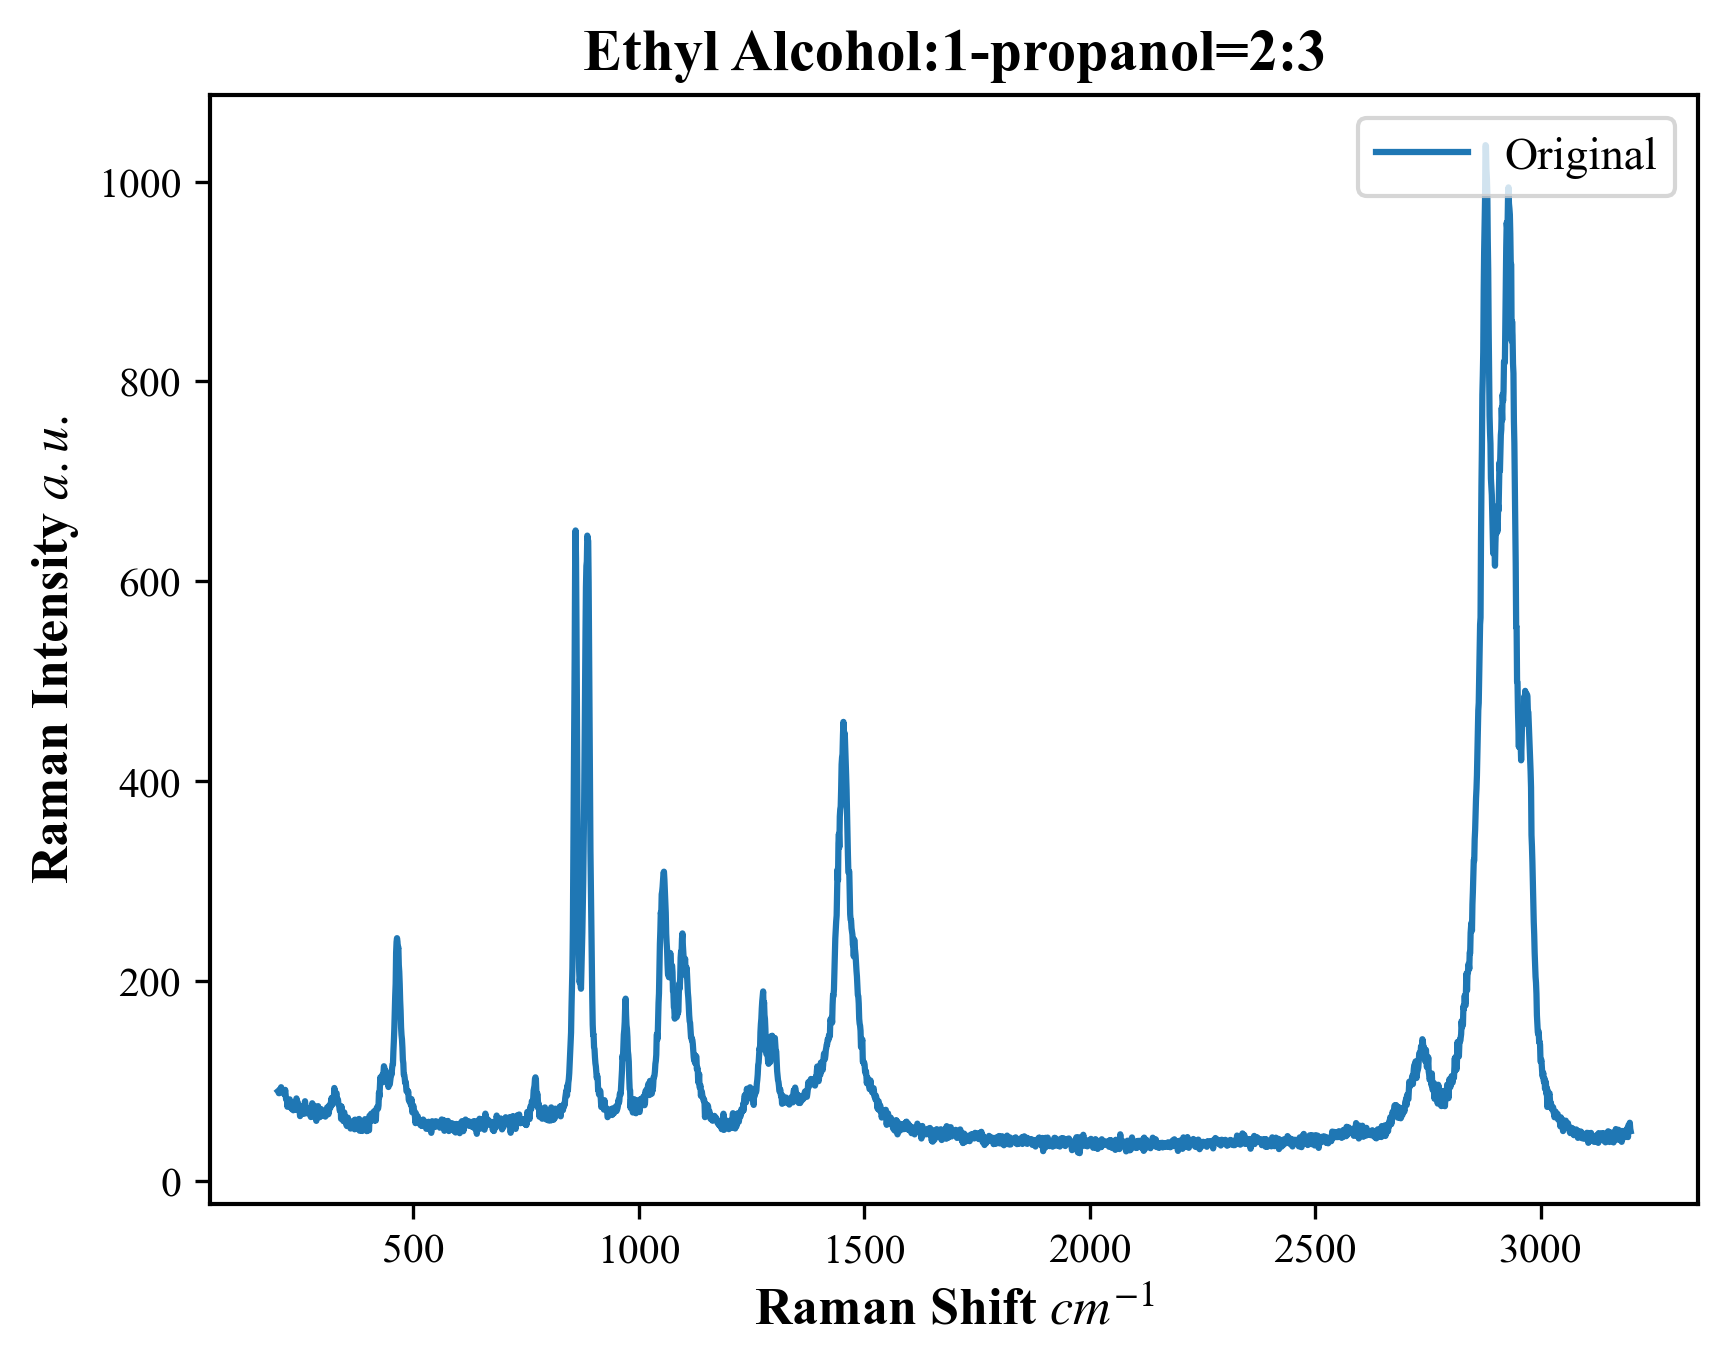

**********************************************
chemical: 10_乙醇-正丙醇#2-3
输出标签为： [0.036 0.02  0.32  0.033 0.374 0.034 0.022 0.025 0.015 0.018 0.019 0.021
 0.035 0.027]
#######
预测的化学品为： ['正丙醇', '乙醇']
参比分数为： [0.374, 0.32]
**********************************************


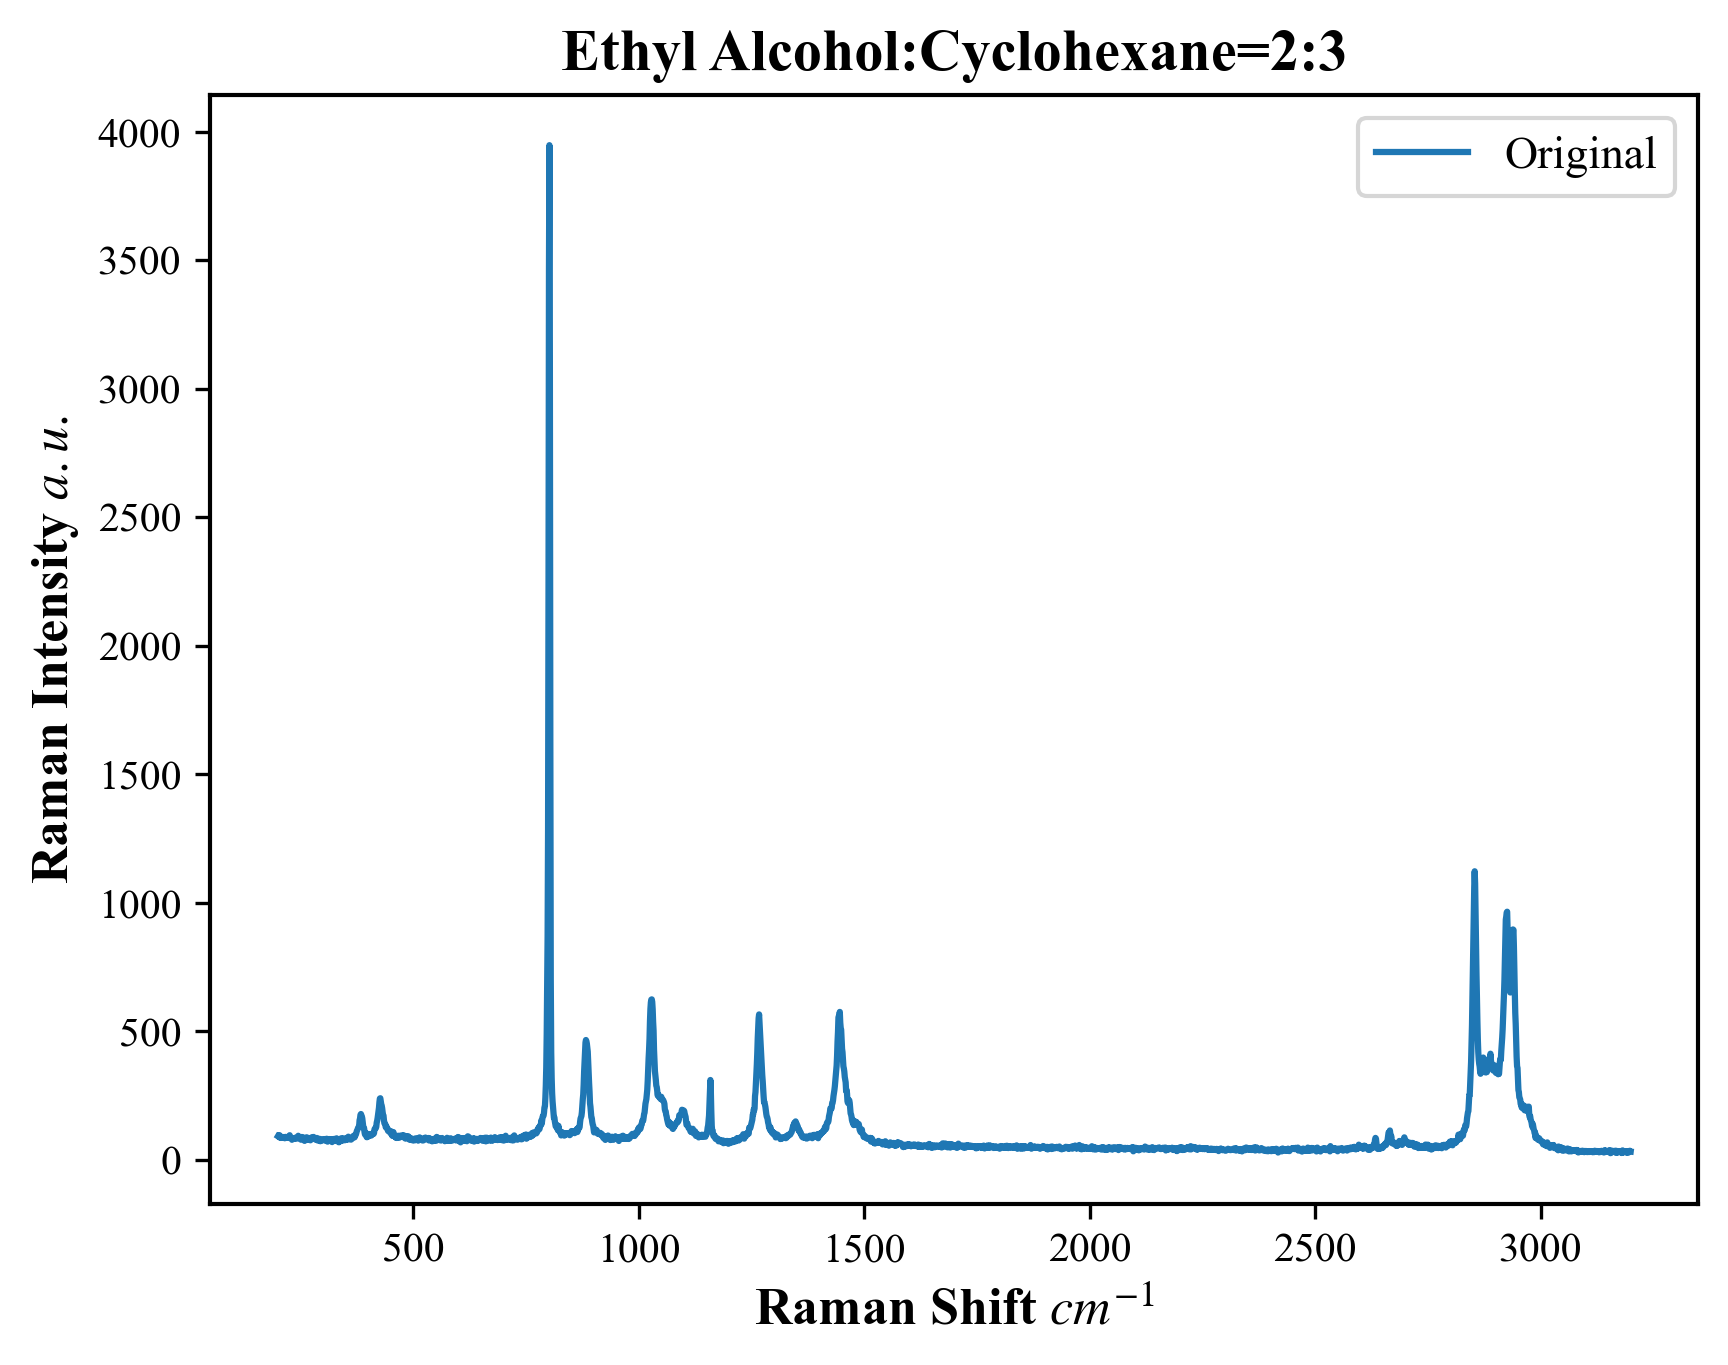

**********************************************
chemical: 11_乙醇-环己烷#2-3
输出标签为： [0.032 0.019 0.227 0.015 0.021 0.029 0.019 0.016 0.017 0.516 0.022 0.023
 0.02  0.022]
#######
预测的化学品为： ['环己烷', '乙醇']
参比分数为： [0.516, 0.227]
**********************************************


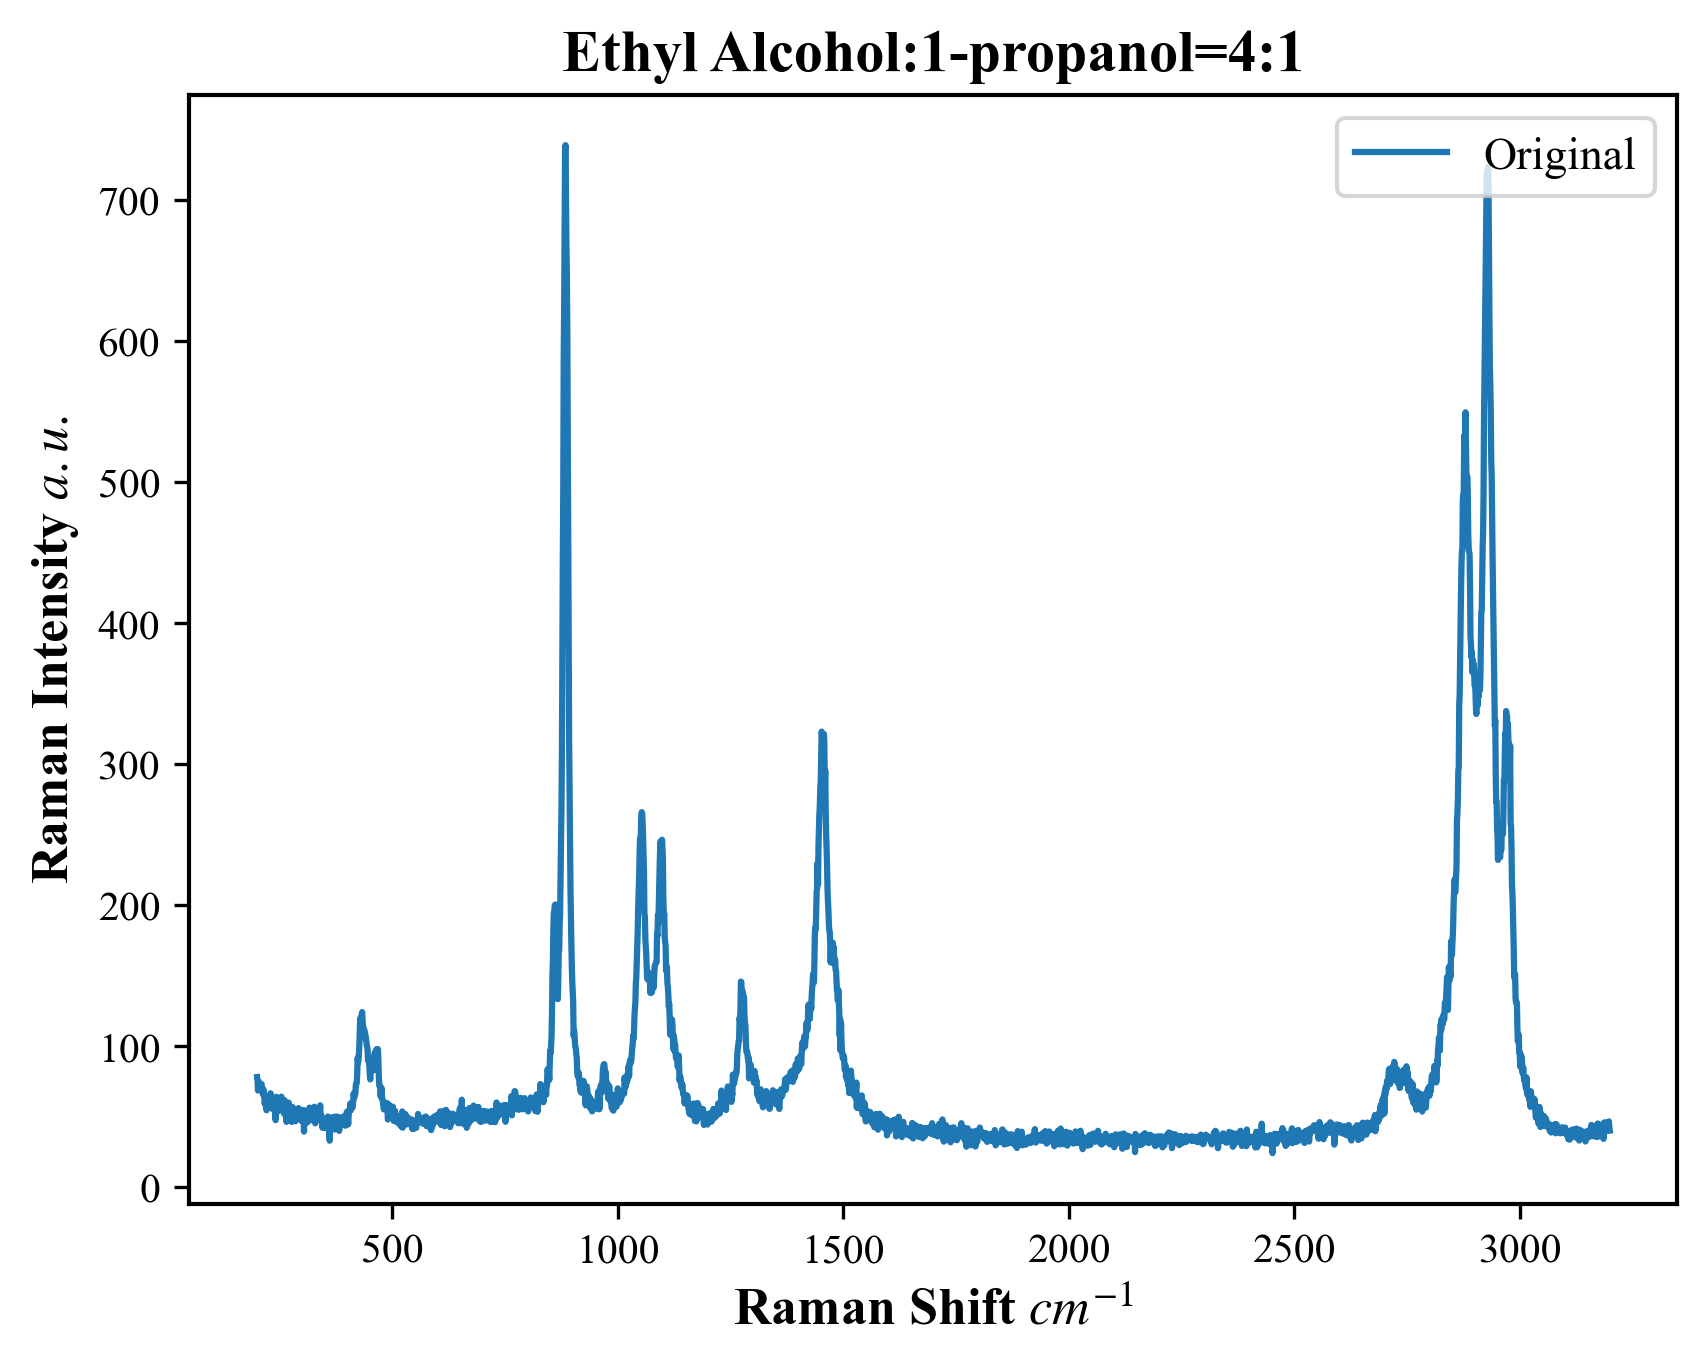

**********************************************
chemical: 12_乙醇-正丙醇#4-1
输出标签为： [0.03  0.016 0.598 0.016 0.143 0.021 0.023 0.021 0.017 0.025 0.017 0.023
 0.019 0.031]
#######
预测的化学品为： ['乙醇', '正丙醇']
参比分数为： [0.598, 0.143]
**********************************************


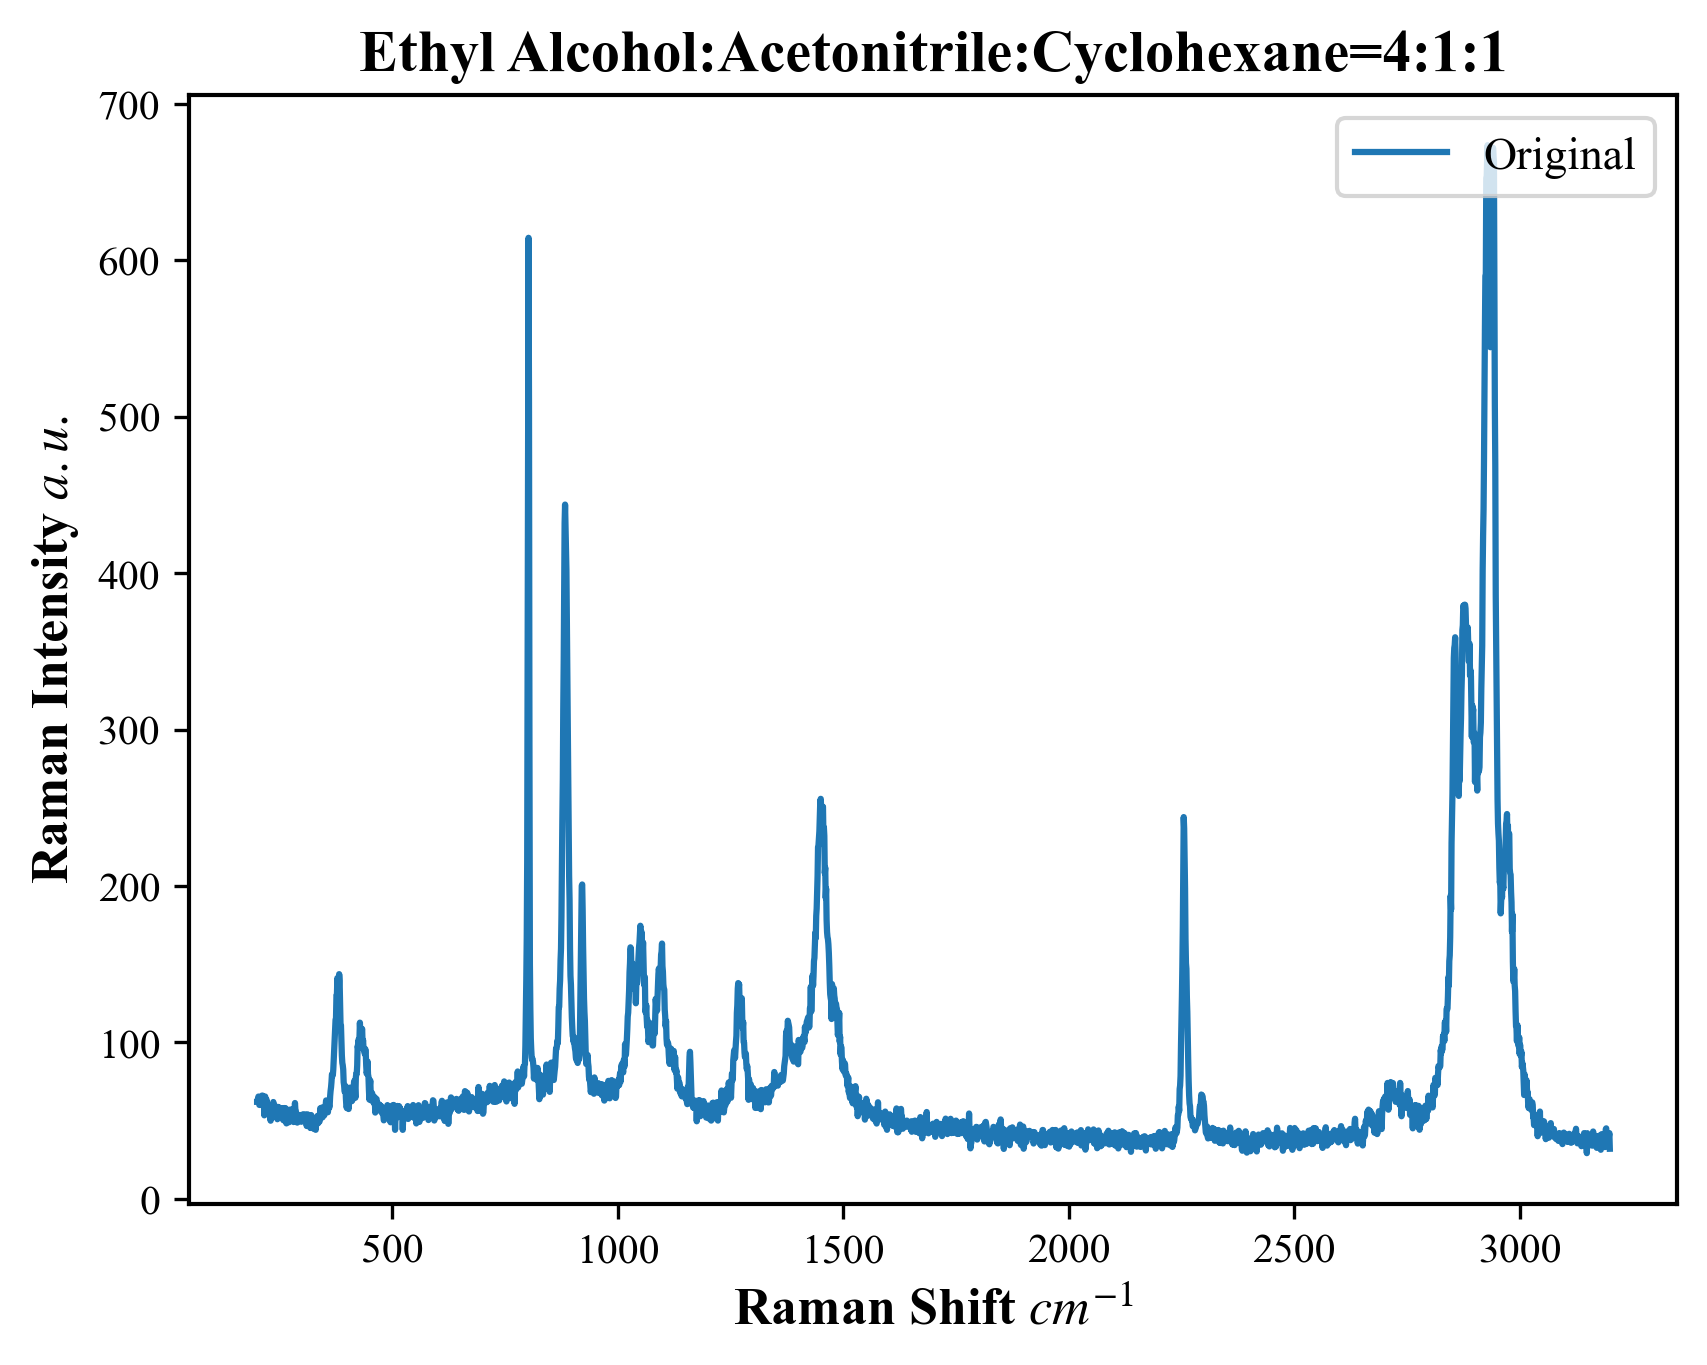

**********************************************
chemical: 13_乙醇-乙腈-环己烷#4-1-1
输出标签为： [0.03  0.16  0.287 0.017 0.023 0.023 0.029 0.016 0.015 0.285 0.05  0.016
 0.018 0.031]
#######
预测的化学品为： ['乙醇', '环己烷', '乙腈']
参比分数为： [0.287, 0.285, 0.16]
**********************************************


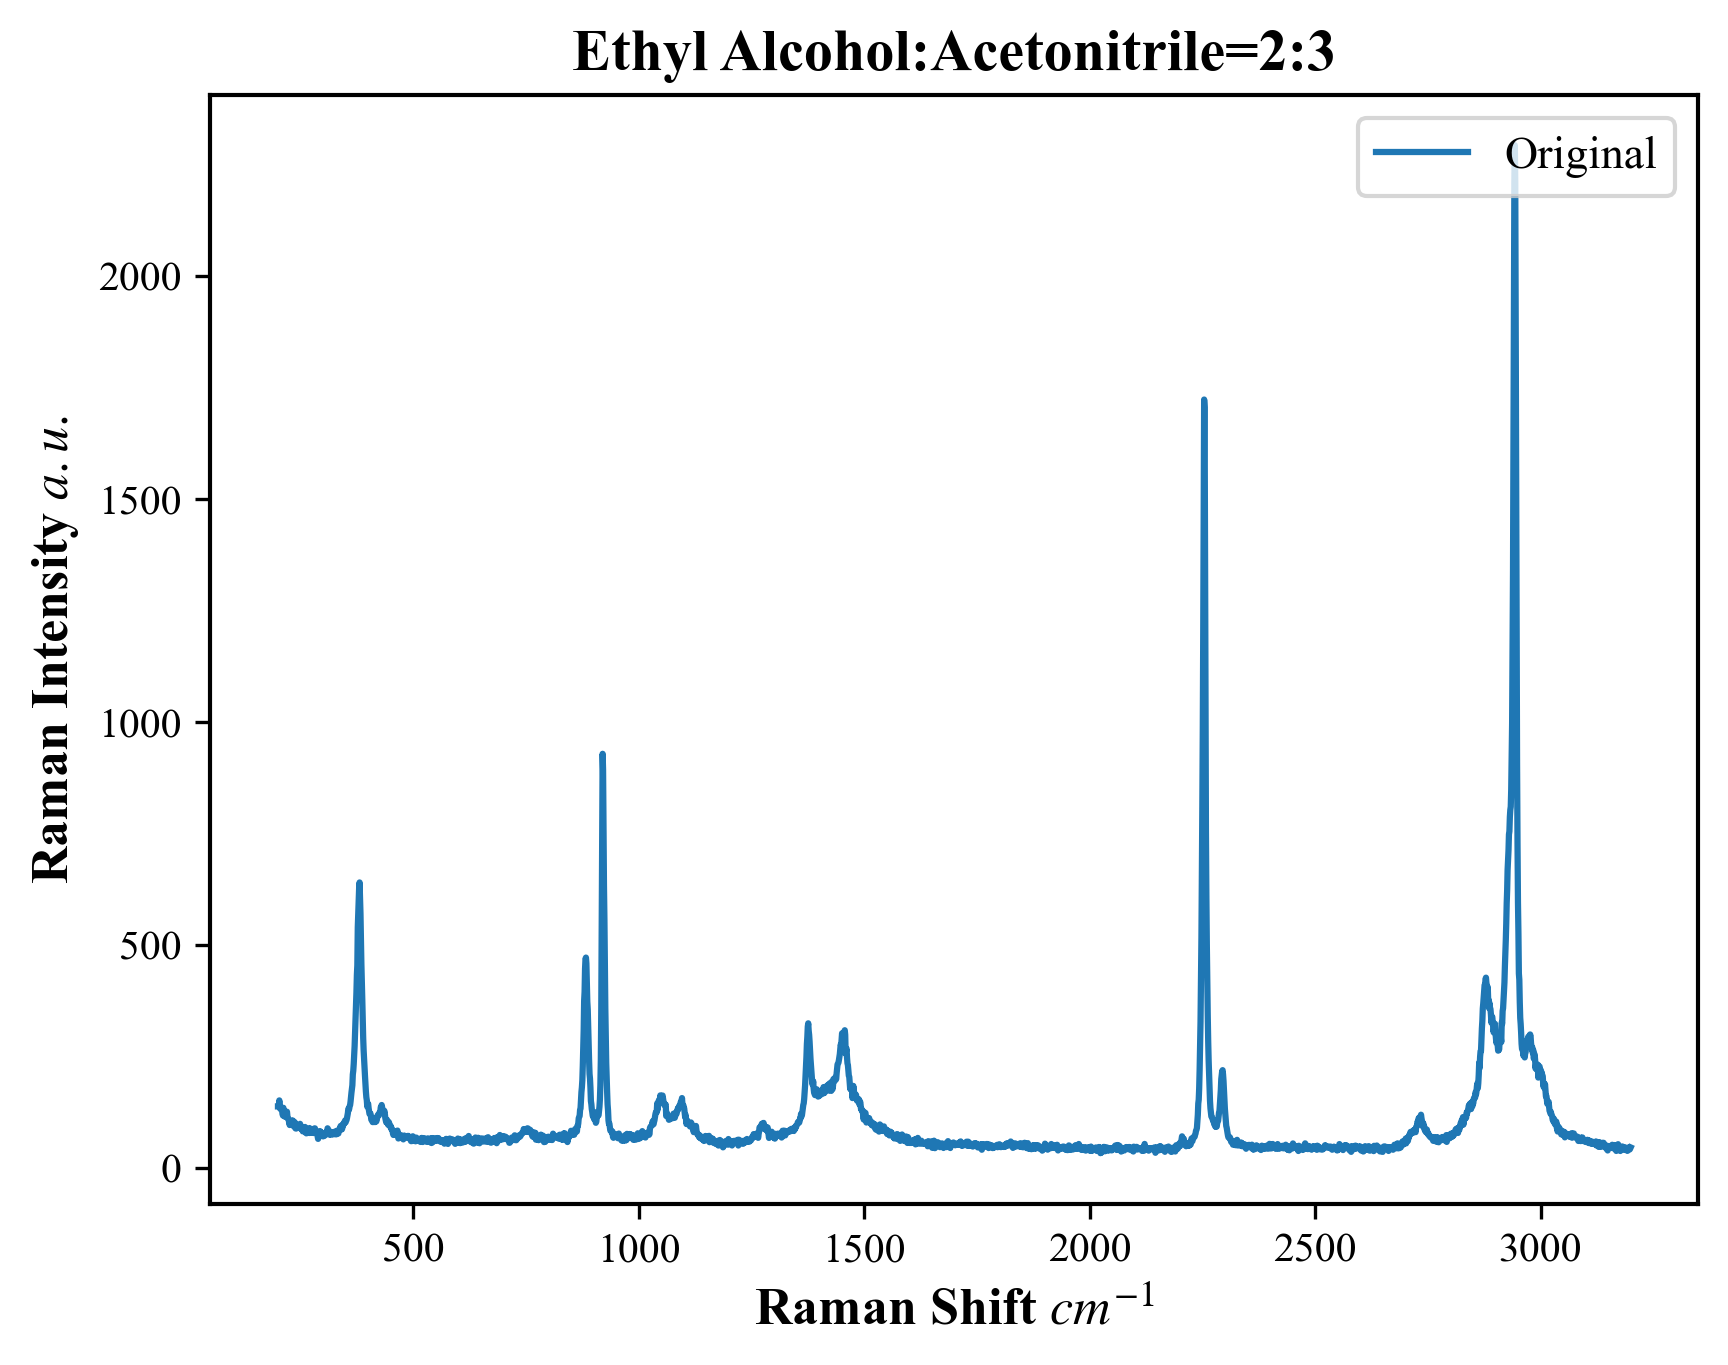

**********************************************
chemical: 14_乙醇-乙腈#2-3
输出标签为： [0.04  0.437 0.281 0.022 0.021 0.023 0.018 0.013 0.019 0.022 0.019 0.029
 0.029 0.024]
#######
预测的化学品为： ['乙腈', '乙醇']
参比分数为： [0.437, 0.281]
**********************************************


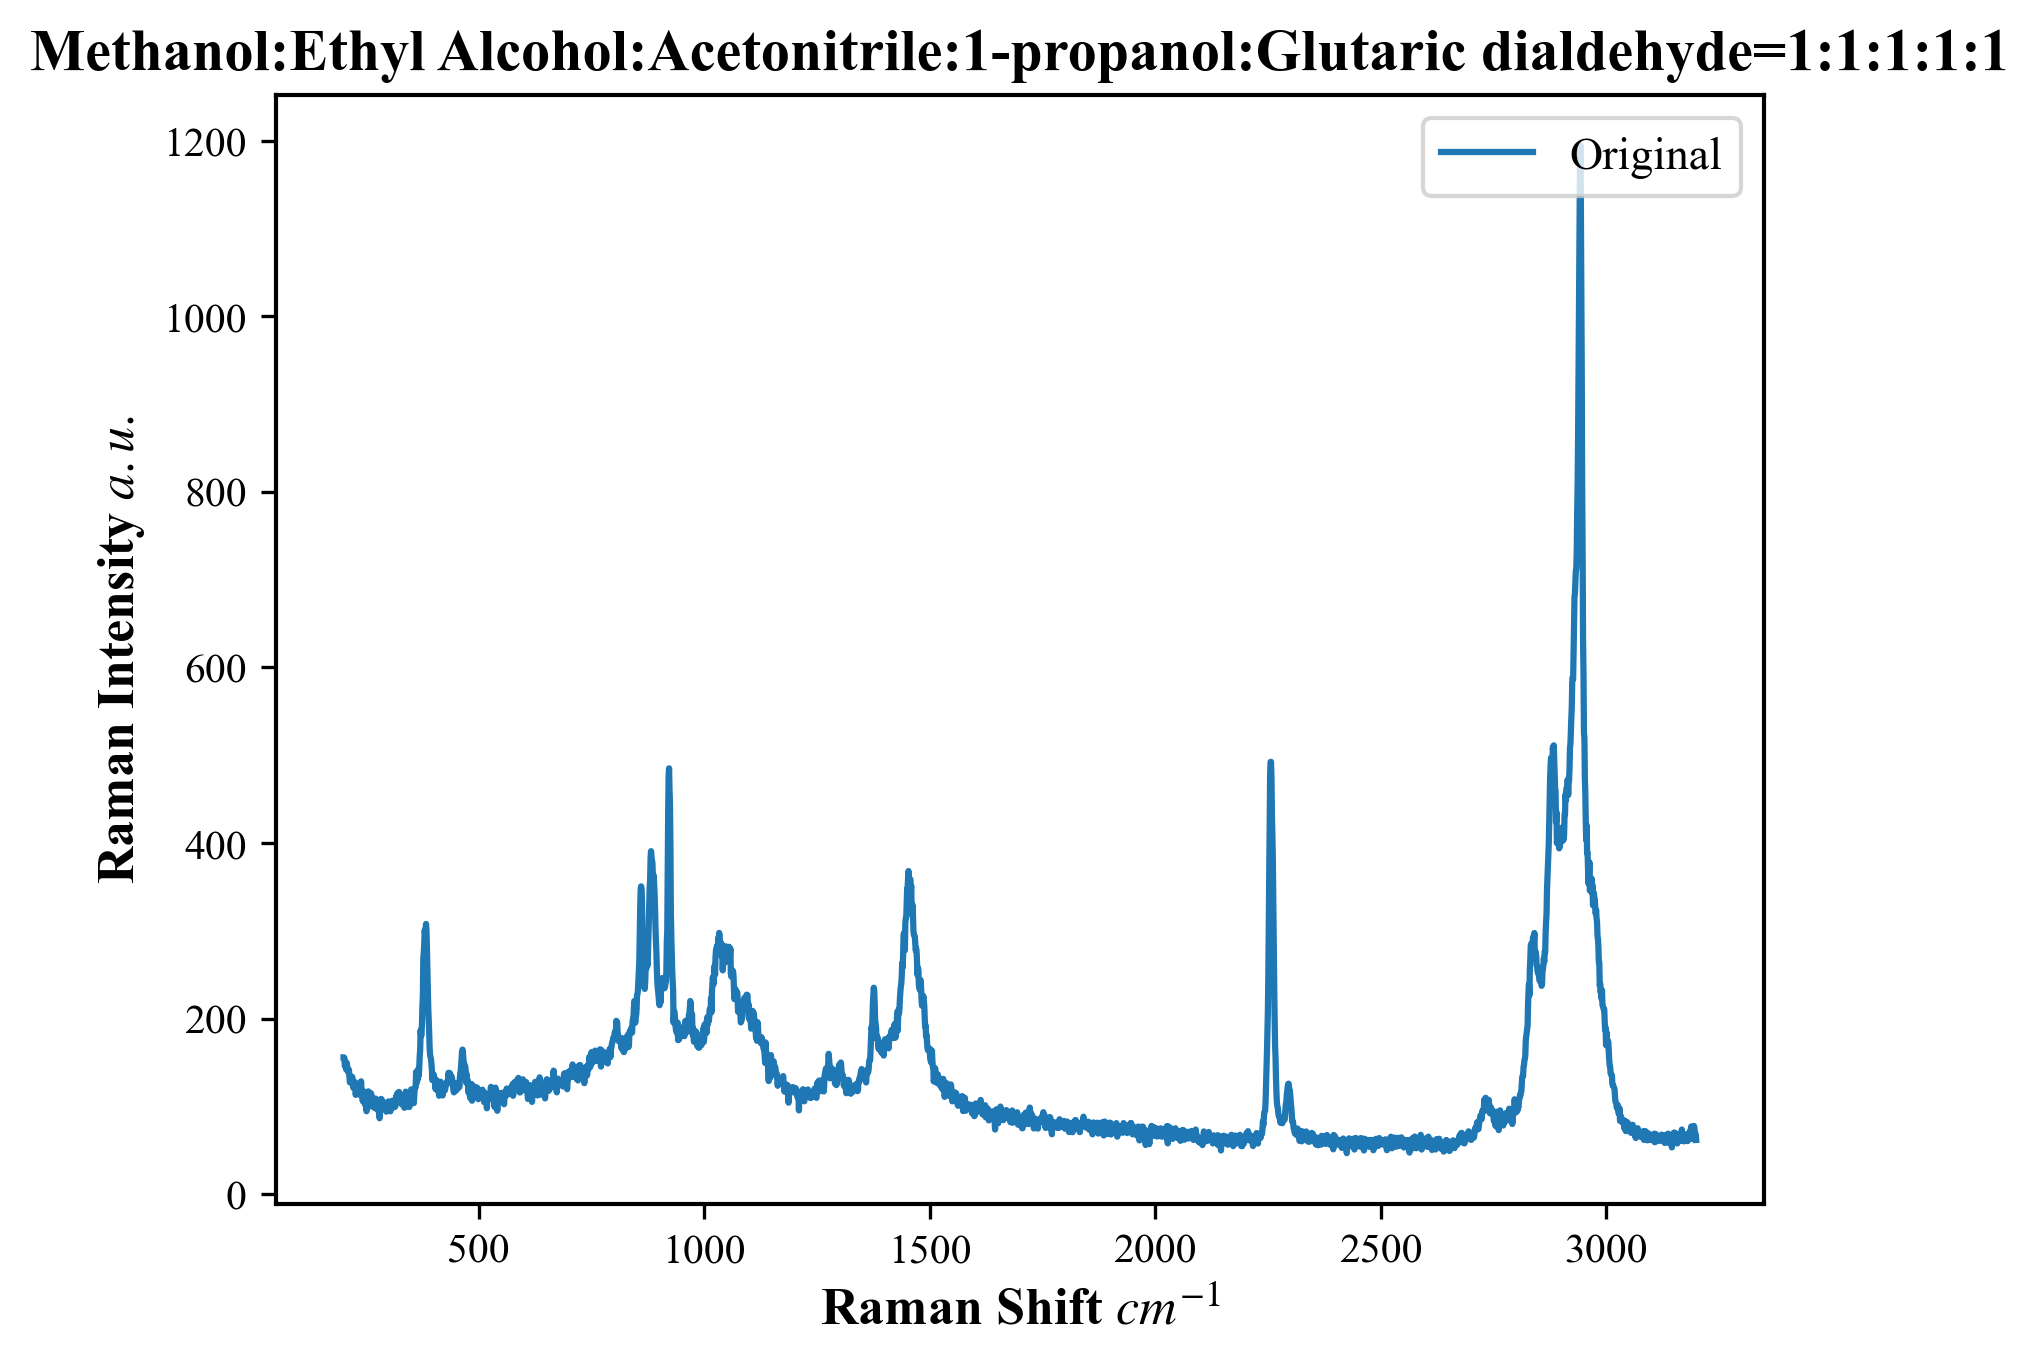

**********************************************
chemical: 15_甲醇-乙醇-乙腈-正丙醇-戊二醛#1-1-1-1-1
输出标签为： [0.09  0.203 0.204 0.038 0.094 0.045 0.027 0.026 0.027 0.021 0.156 0.02
 0.021 0.027]
#######
预测的化学品为： ['乙醇', '乙腈', '甲醇']
参比分数为： [0.204, 0.203, 0.156]
**********************************************


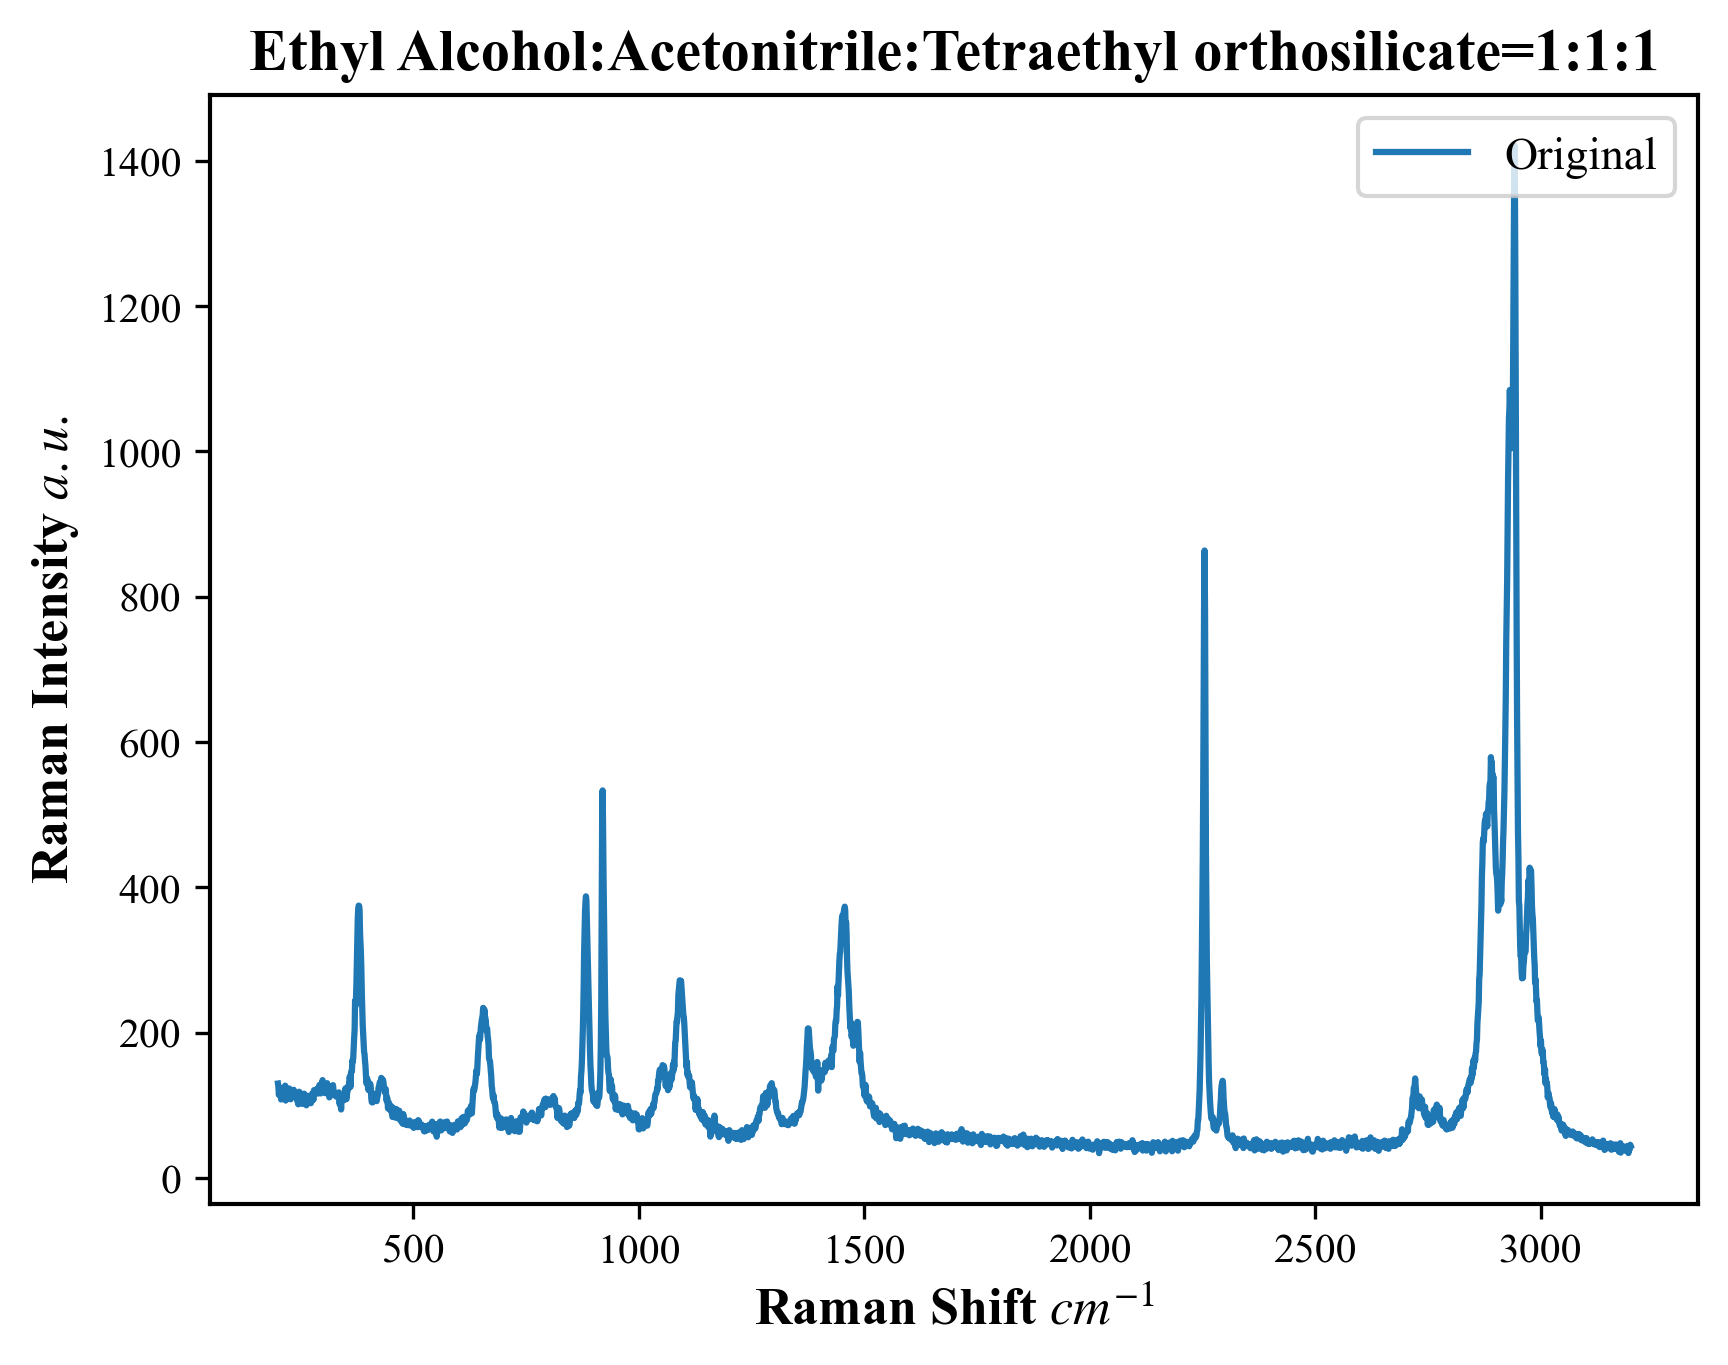

**********************************************
chemical: 16_乙醇-乙腈-正硅酸四乙酯#1-1-1
输出标签为： [0.023 0.286 0.246 0.022 0.023 0.034 0.028 0.215 0.015 0.016 0.011 0.03
 0.024 0.027]
#######
预测的化学品为： ['乙腈', '乙醇', '正硅酸四乙酯']
参比分数为： [0.286, 0.246, 0.215]
**********************************************


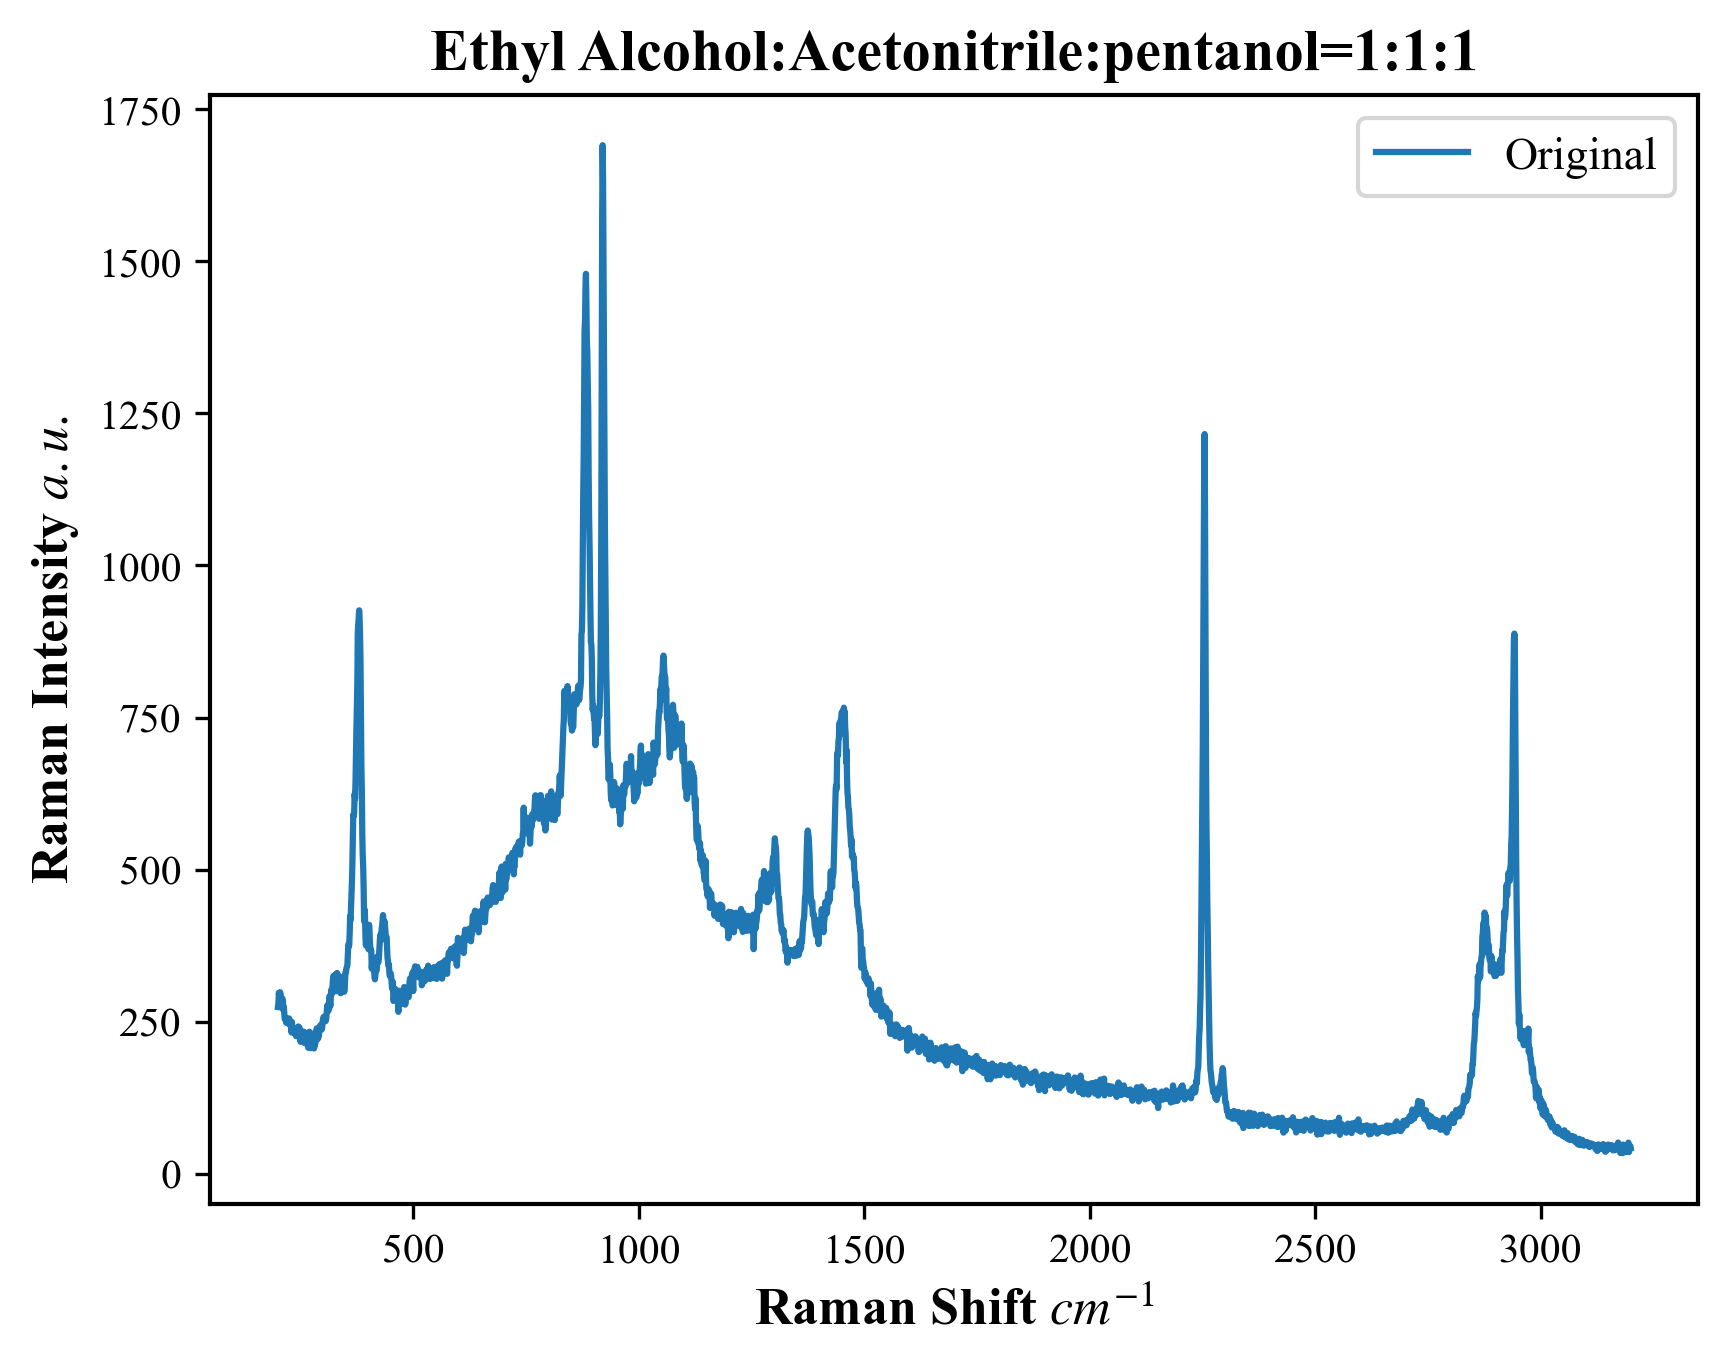

**********************************************
chemical: 17_乙醇-乙腈-正戊醇#1-1-1
输出标签为： [0.033 0.253 0.282 0.025 0.028 0.049 0.137 0.036 0.027 0.022 0.028 0.024
 0.022 0.035]
#######
预测的化学品为： ['乙醇', '乙腈', '正戊醇']
参比分数为： [0.282, 0.253, 0.137]
**********************************************


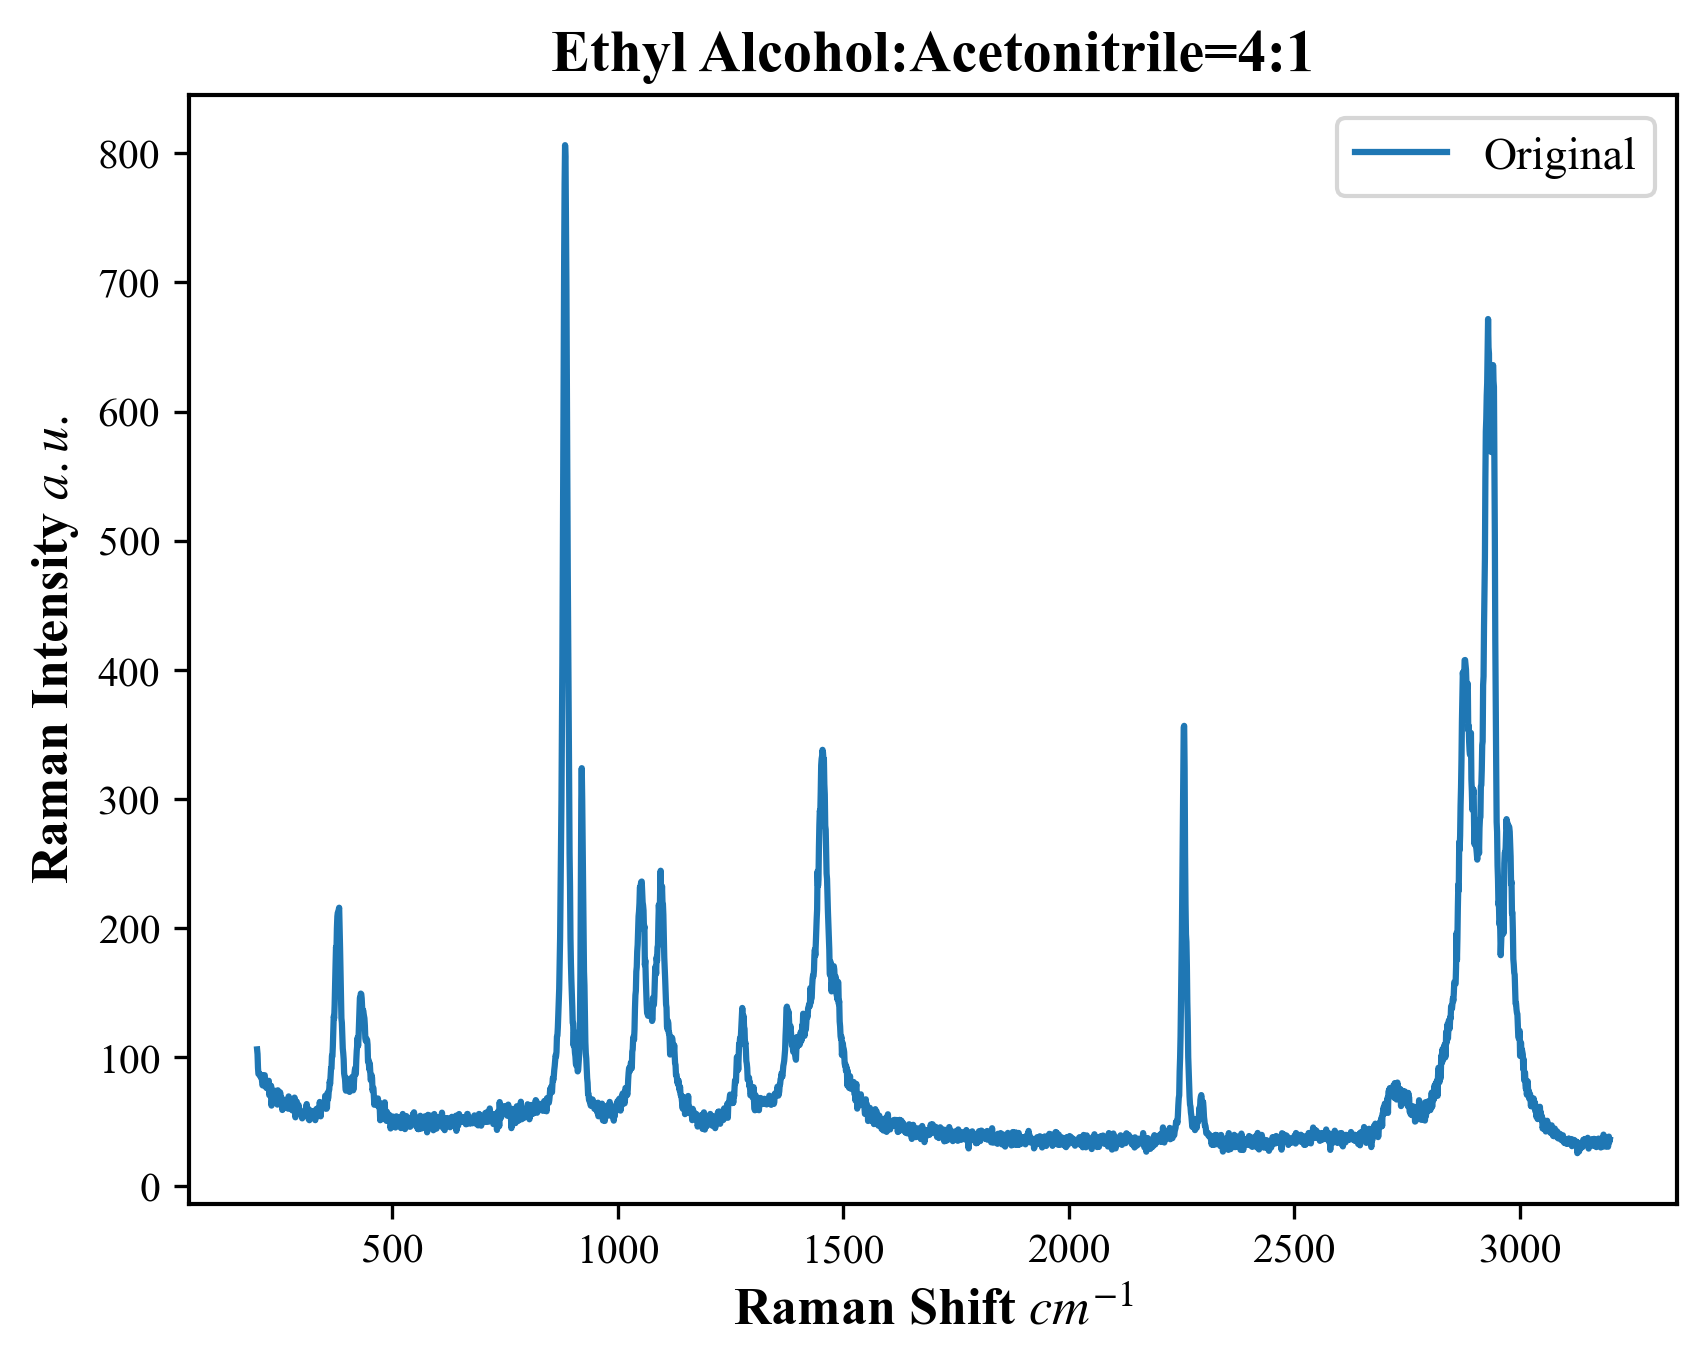

**********************************************
chemical: 18_乙醇-乙腈#4-1
输出标签为： [0.024 0.27  0.467 0.017 0.024 0.021 0.03  0.012 0.015 0.022 0.019 0.021
 0.021 0.037]
#######
预测的化学品为： ['乙醇', '乙腈']
参比分数为： [0.467, 0.27]
**********************************************


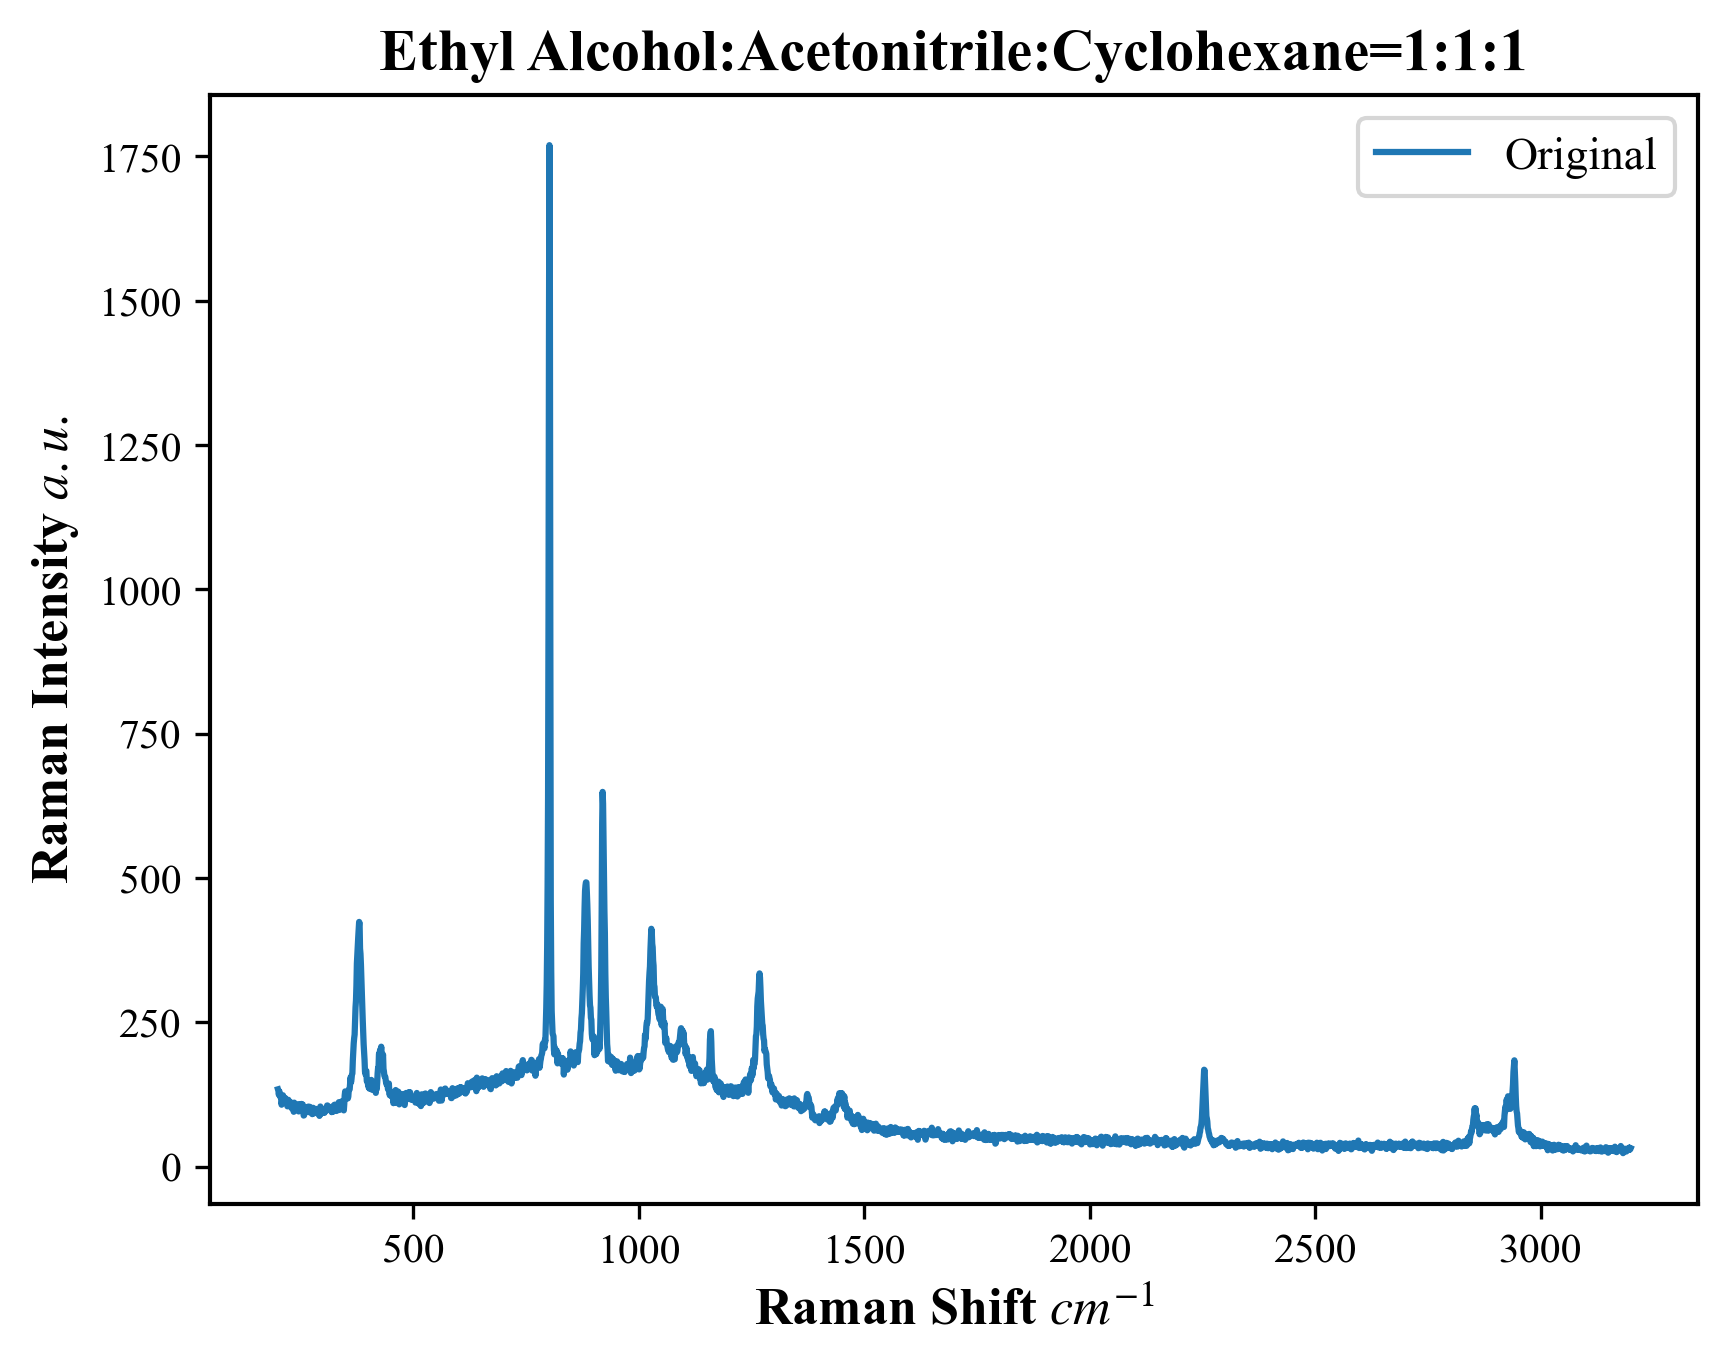

**********************************************
chemical: 19_乙醇-乙腈-环己烷#1-1-1
输出标签为： [0.062 0.122 0.132 0.047 0.054 0.056 0.059 0.046 0.054 0.155 0.071 0.04
 0.045 0.056]
#######
预测的化学品为： ['环己烷', '乙醇', '乙腈']
参比分数为： [0.155, 0.132, 0.122]
**********************************************


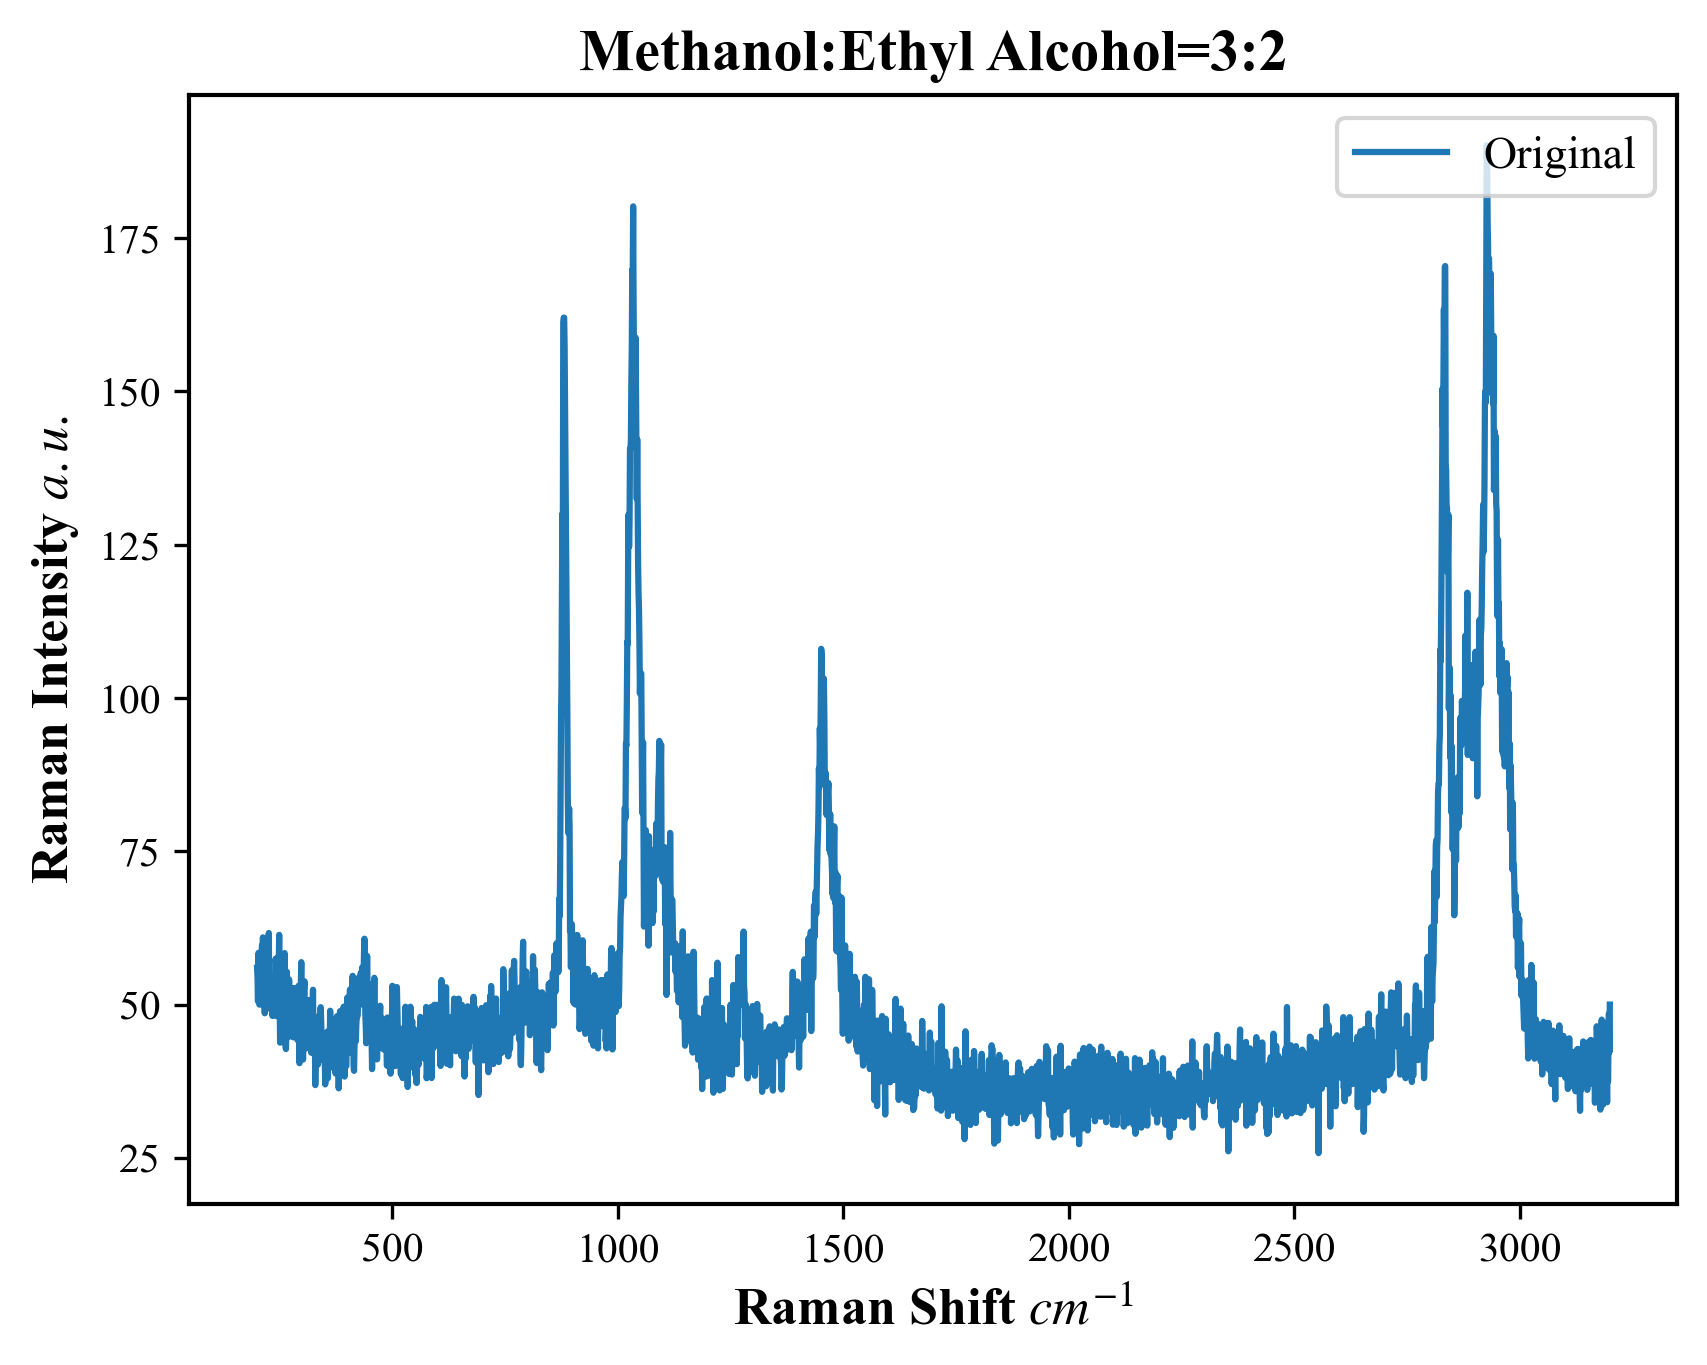

**********************************************
chemical: 1_甲醇-乙醇#3-2
输出标签为： [0.038 0.017 0.251 0.021 0.032 0.035 0.059 0.034 0.023 0.028 0.382 0.033
 0.021 0.026]
#######
预测的化学品为： ['甲醇', '乙醇']
参比分数为： [0.382, 0.251]
**********************************************


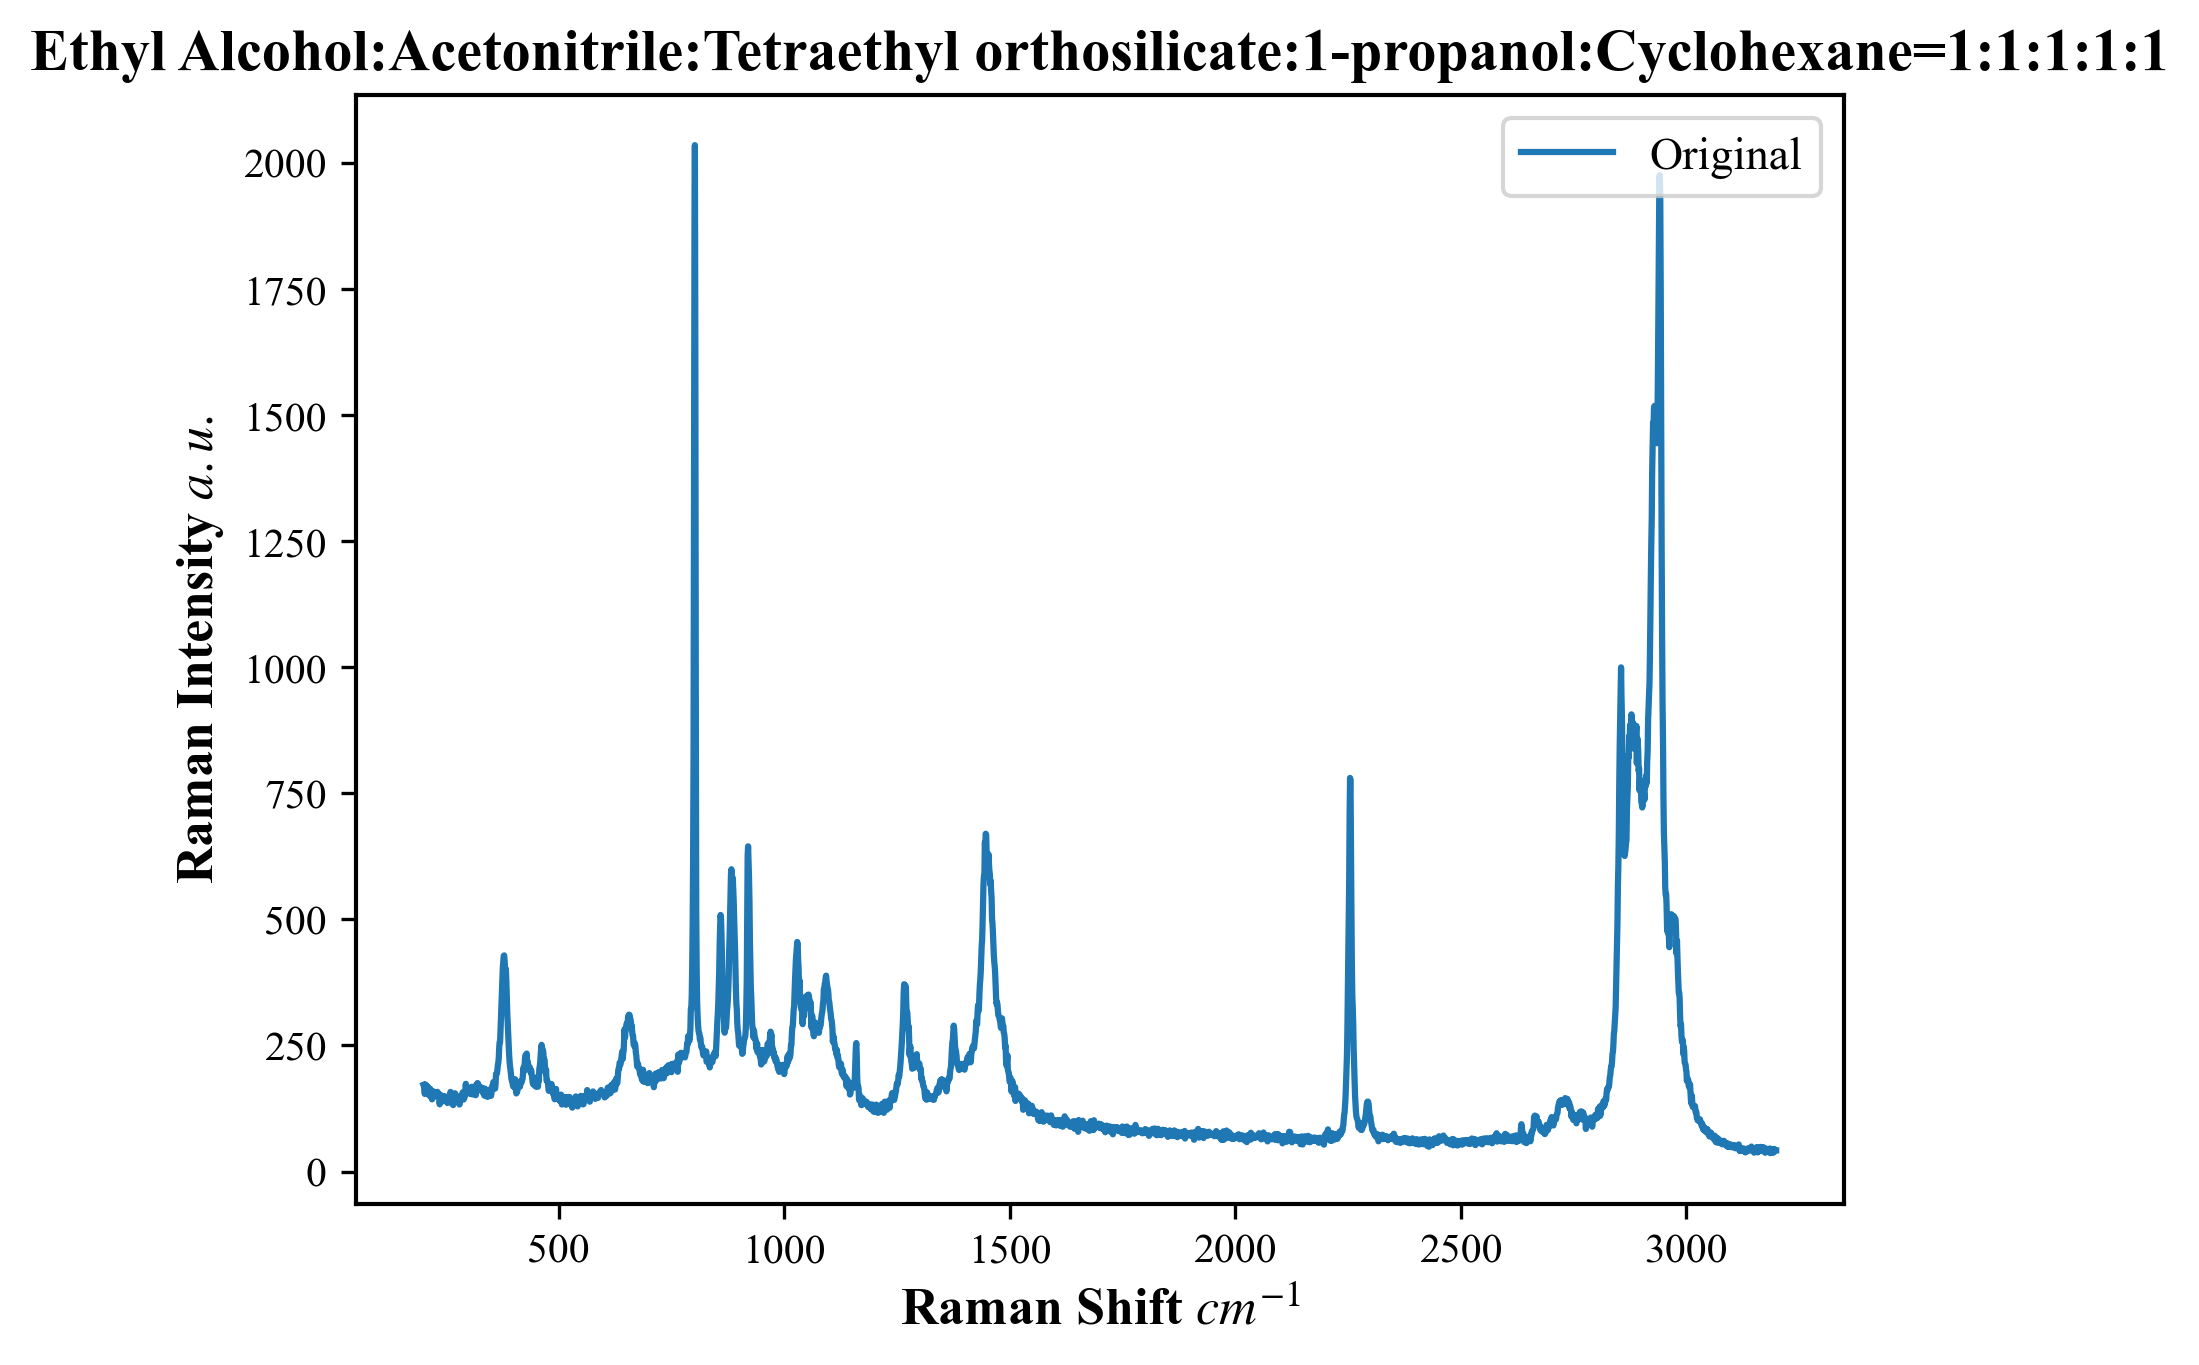

**********************************************
chemical: 20_乙醇-乙腈-正硅酸四乙酯-正丙醇-环己烷#1-1-1-1-1
输出标签为： [0.022 0.178 0.182 0.017 0.111 0.021 0.016 0.095 0.016 0.257 0.034 0.015
 0.017 0.021]
#######
预测的化学品为： ['环己烷', '乙醇', '乙腈', '正丙醇']
参比分数为： [0.257, 0.182, 0.178, 0.111]
**********************************************


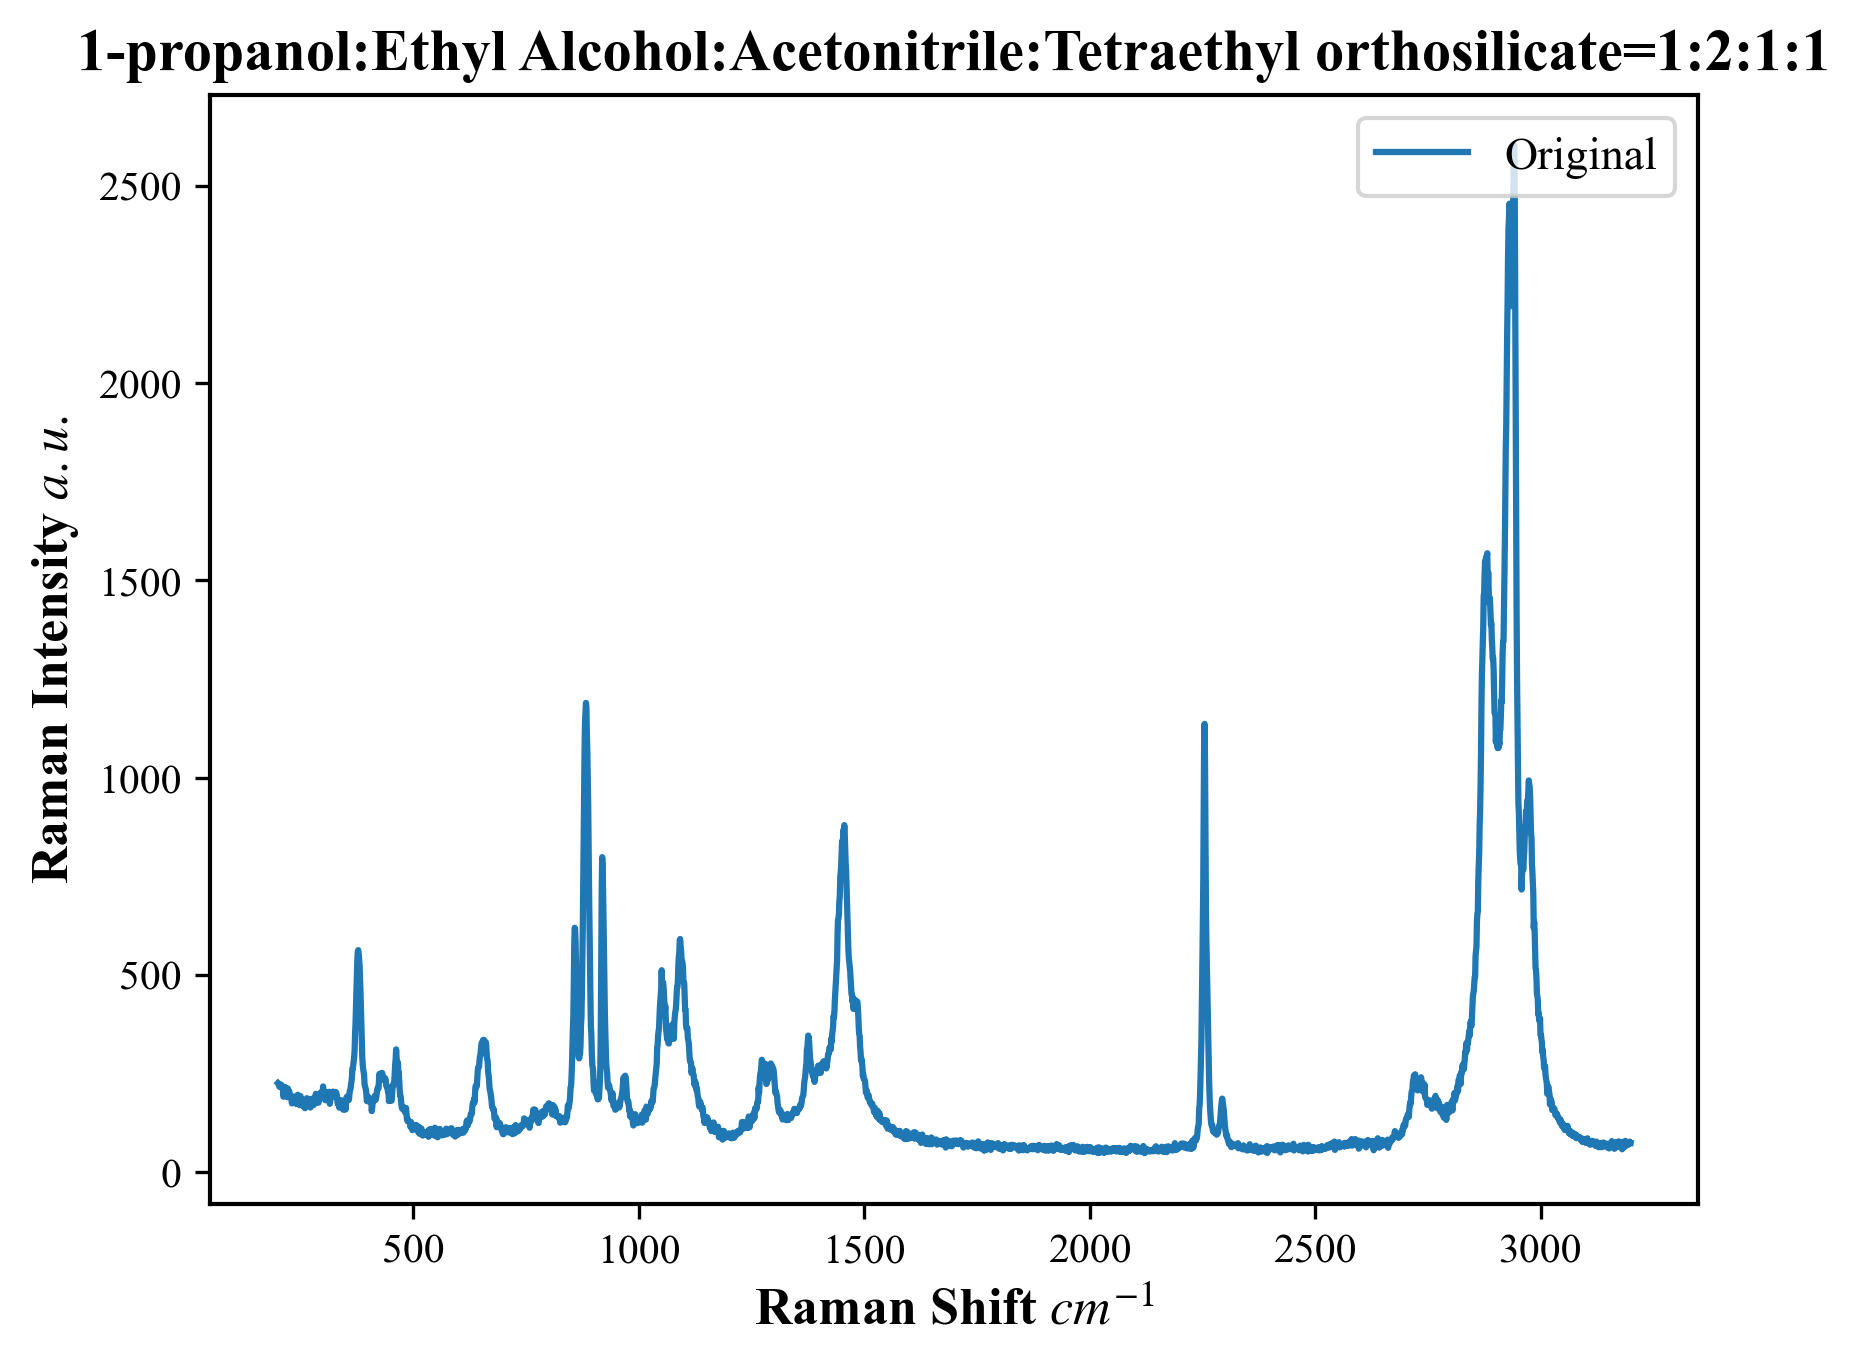

**********************************************
chemical: 2_正丙醇-乙醇-乙腈-正硅酸四乙酯#1-2-1-1
输出标签为： [0.018 0.2   0.262 0.021 0.142 0.018 0.014 0.195 0.031 0.016 0.017 0.023
 0.019 0.024]
#######
预测的化学品为： ['乙醇', '乙腈', '正硅酸四乙酯', '正丙醇']
参比分数为： [0.262, 0.2, 0.195, 0.142]
**********************************************


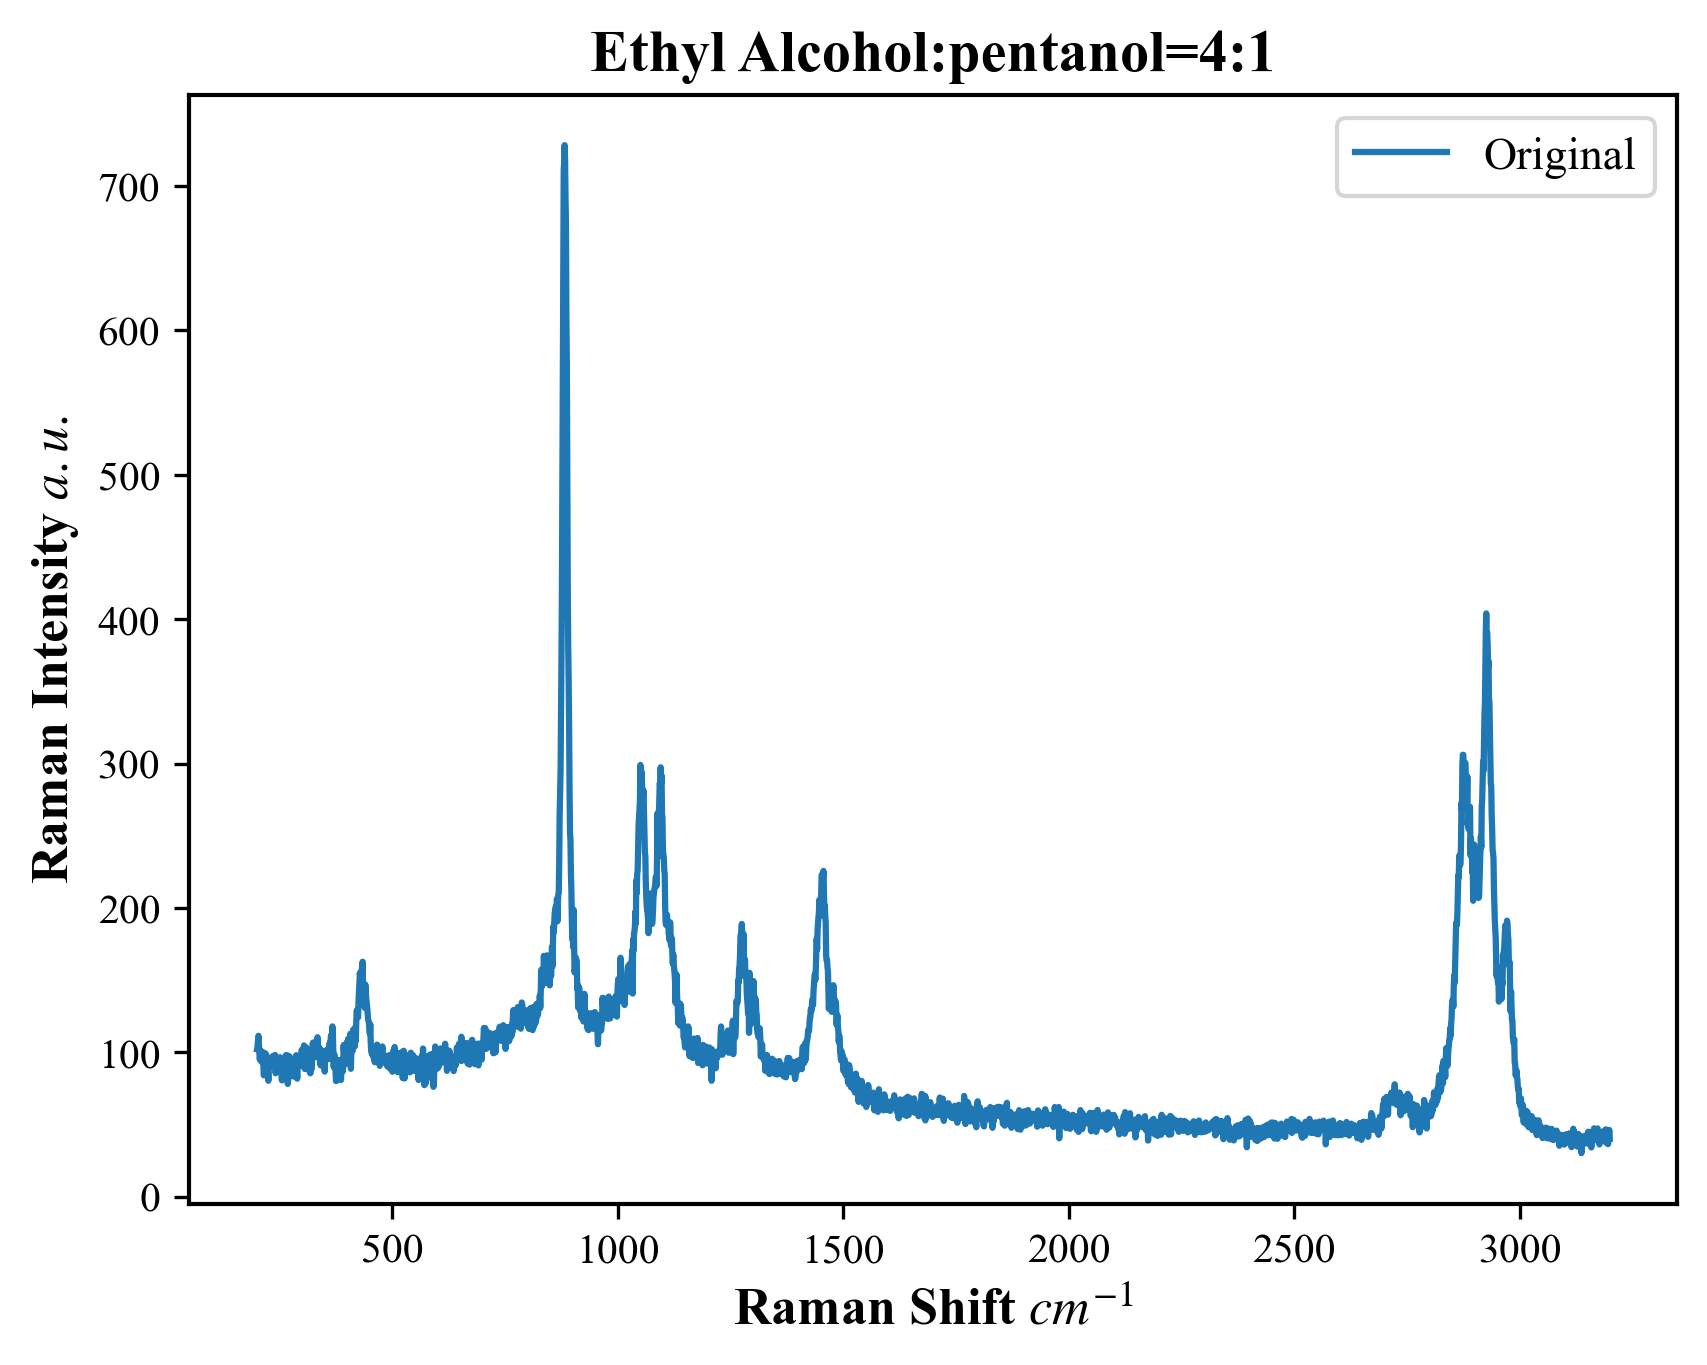

**********************************************
chemical: 3_乙醇-正戊醇#4-1
输出标签为： [0.041 0.017 0.408 0.042 0.054 0.055 0.174 0.025 0.017 0.027 0.032 0.02
 0.038 0.05 ]
#######
预测的化学品为： ['乙醇', '正戊醇']
参比分数为： [0.408, 0.174]
**********************************************


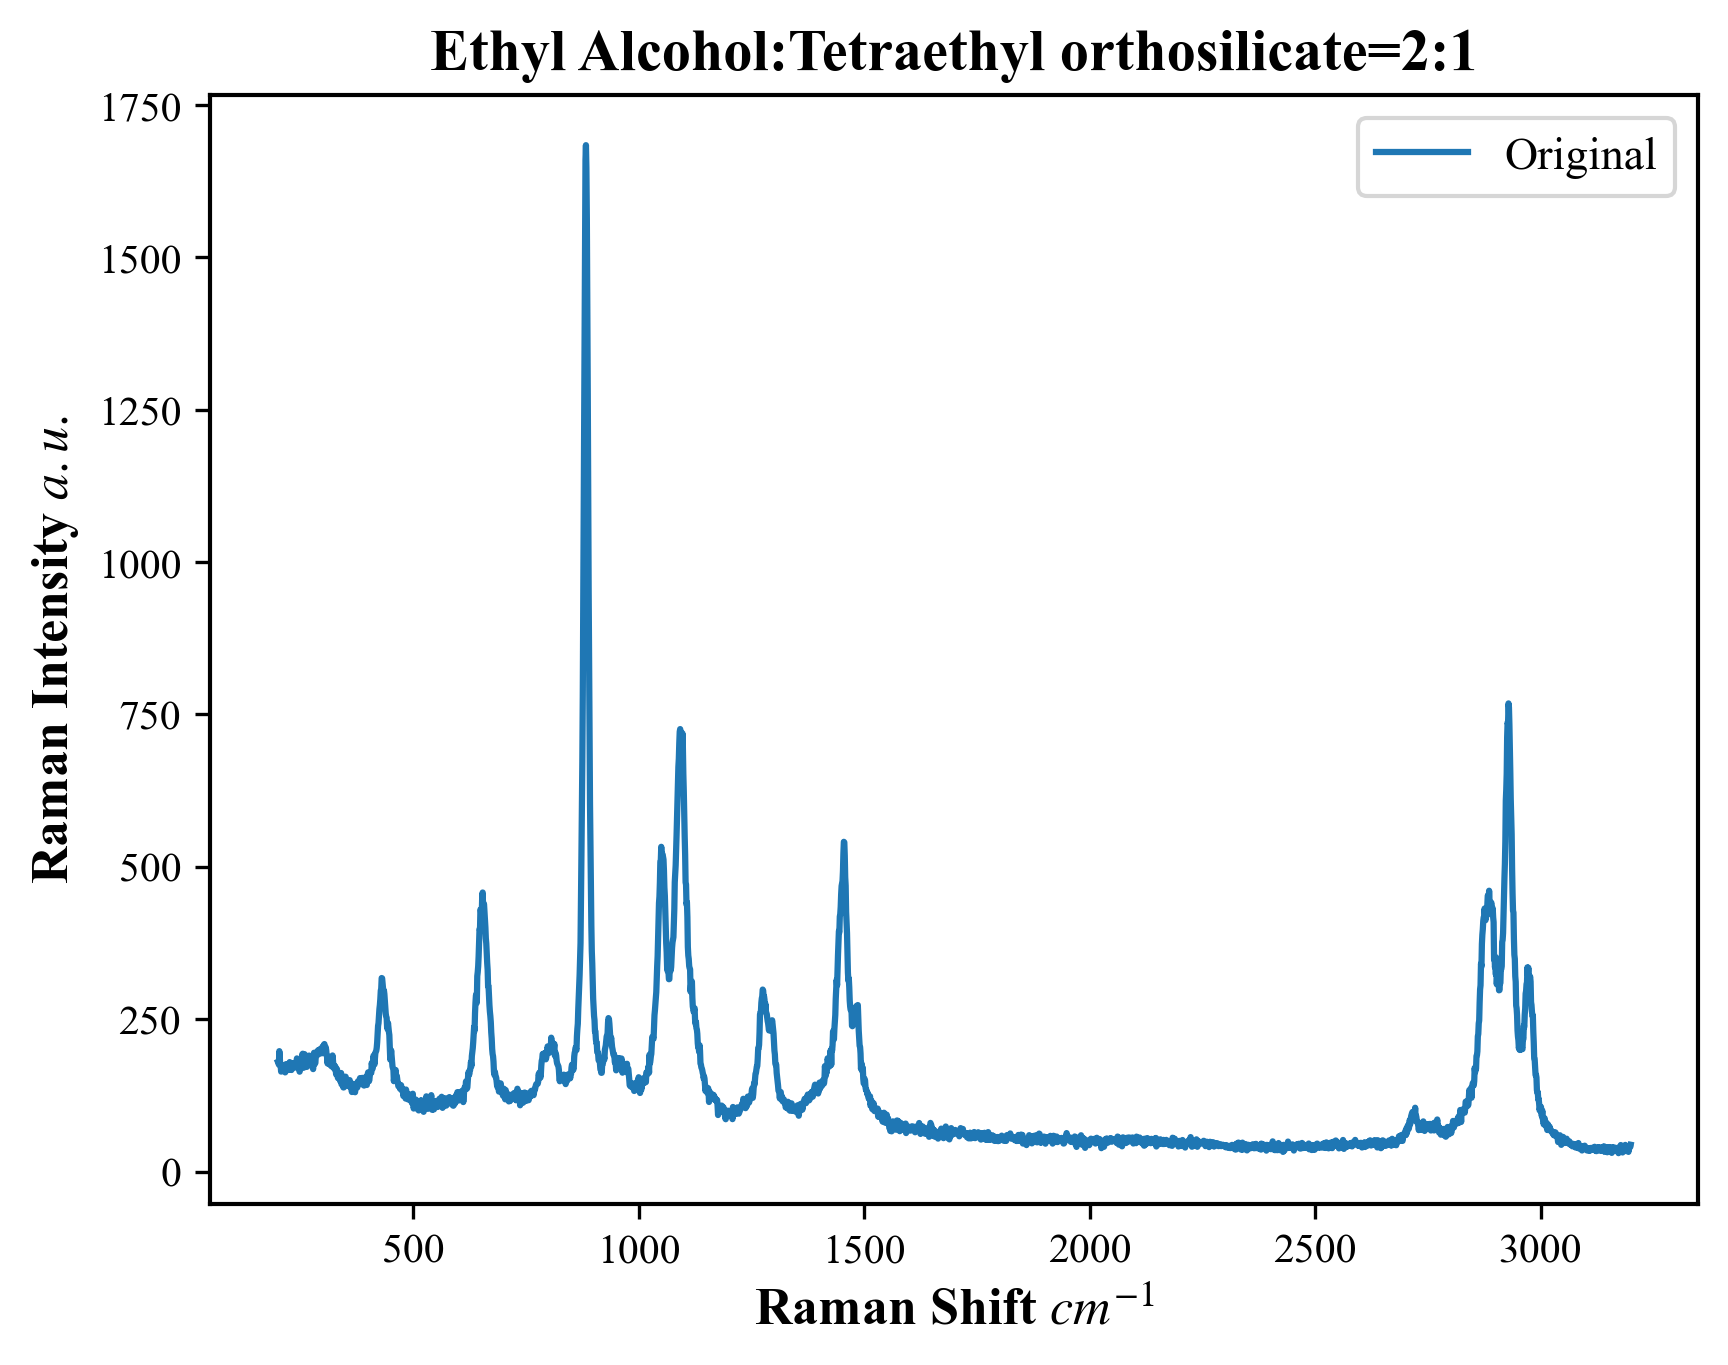

**********************************************
chemical: 4_乙醇-正硅酸四乙酯#2-1
输出标签为： [0.022 0.021 0.453 0.021 0.021 0.033 0.027 0.253 0.021 0.025 0.019 0.02
 0.023 0.04 ]
#######
预测的化学品为： ['乙醇', '正硅酸四乙酯']
参比分数为： [0.453, 0.253]
**********************************************


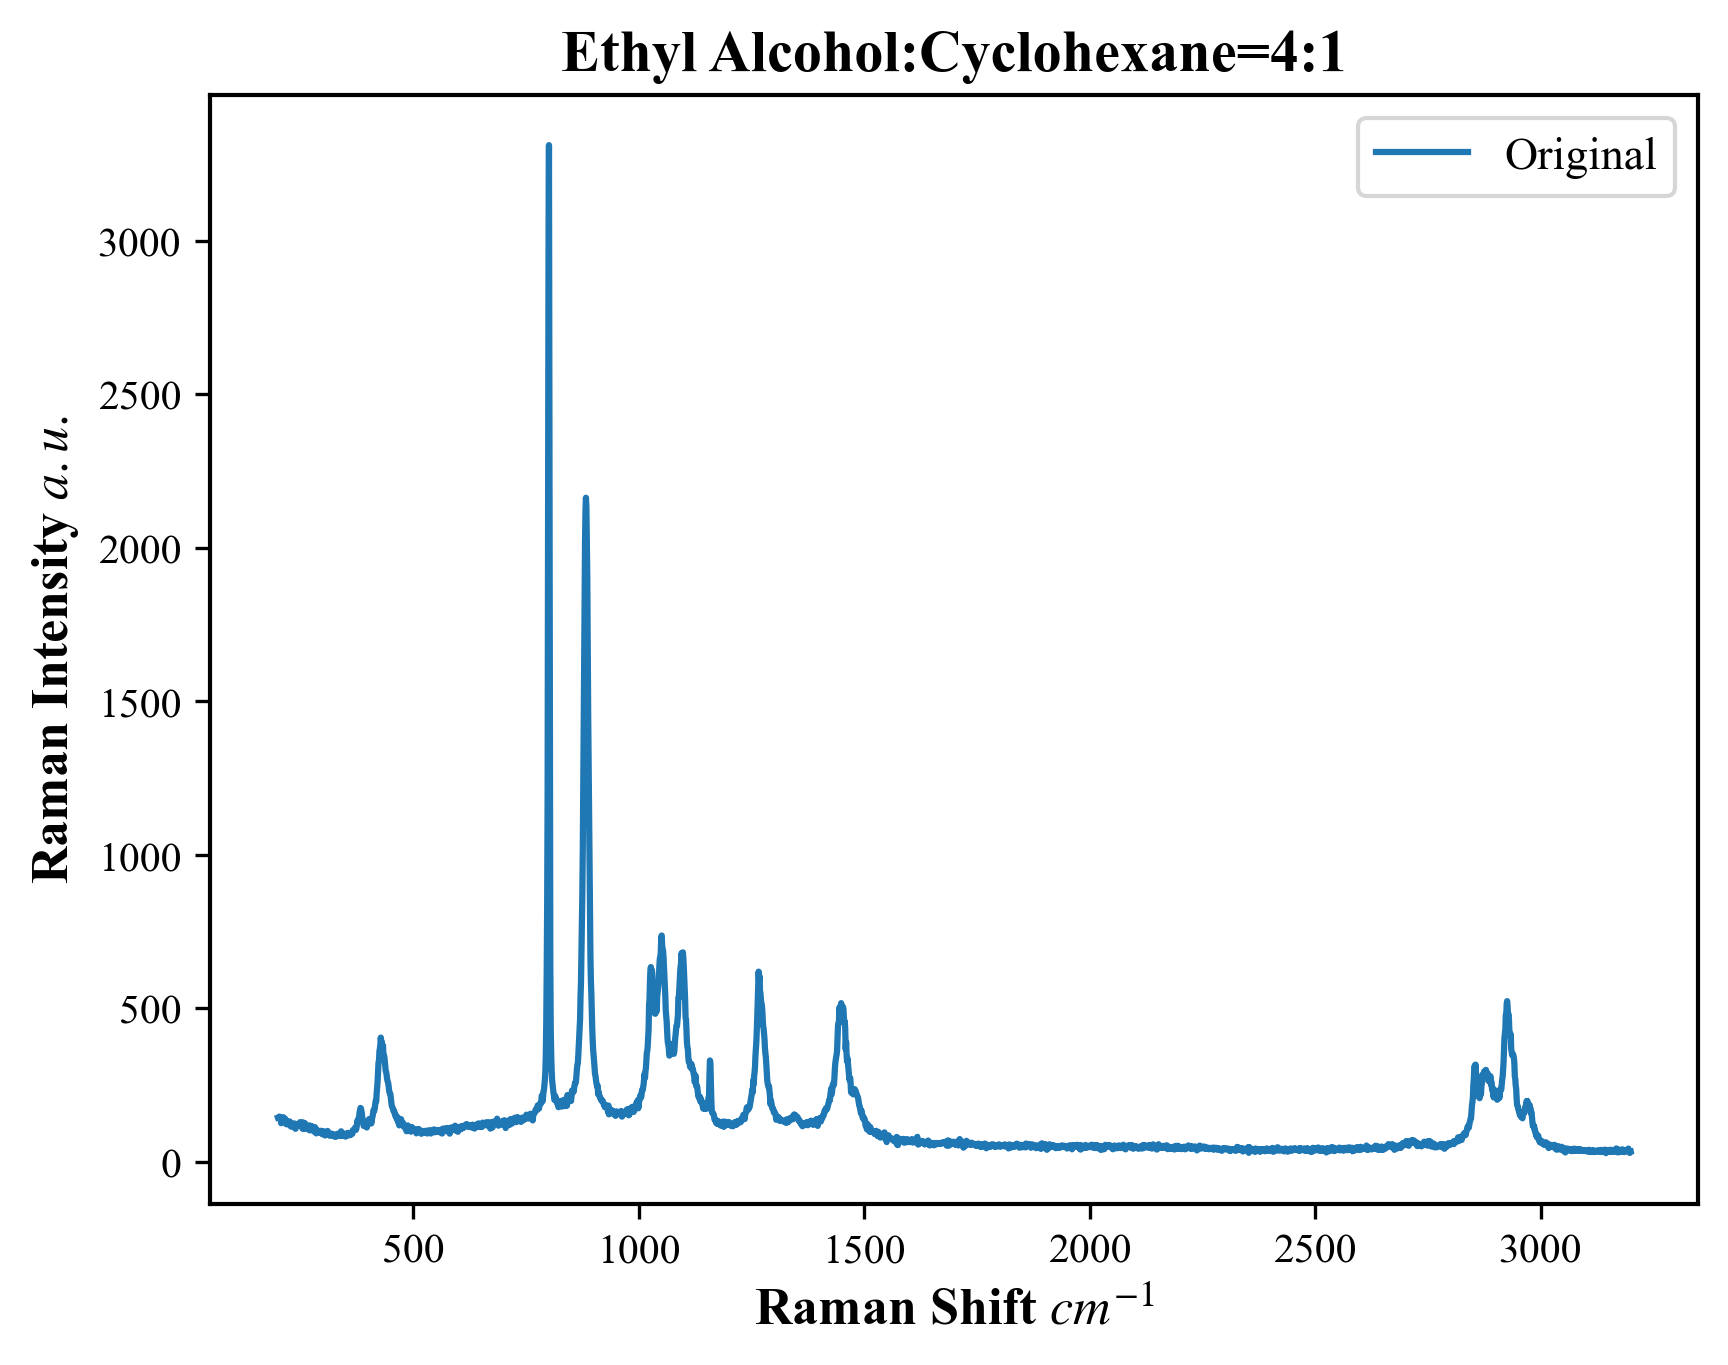

**********************************************
chemical: 5_乙醇-环己烷#4-1
输出标签为： [0.035 0.027 0.335 0.017 0.02  0.031 0.019 0.017 0.016 0.358 0.027 0.027
 0.027 0.043]
#######
预测的化学品为： ['环己烷', '乙醇']
参比分数为： [0.358, 0.335]
**********************************************


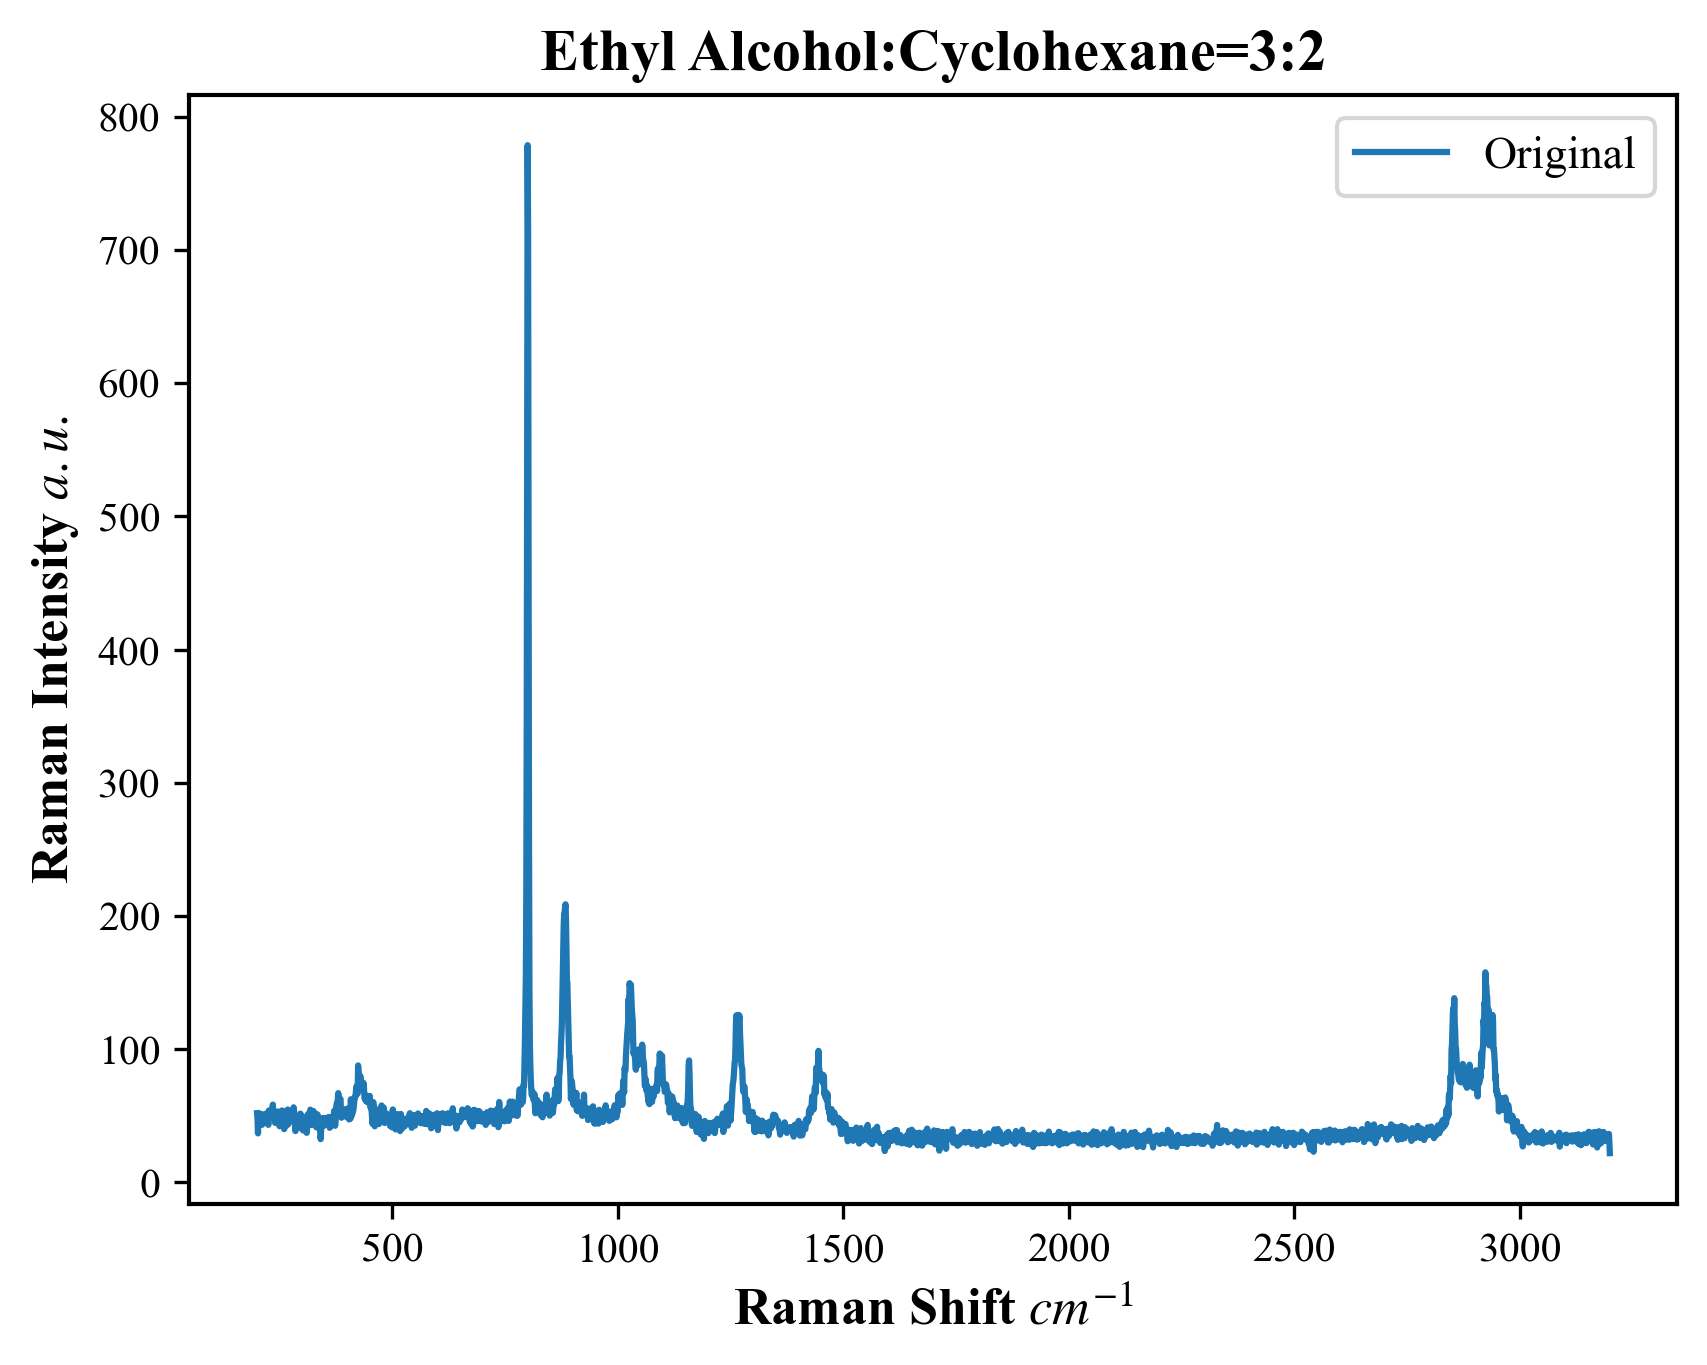

**********************************************
chemical: 6_乙醇-环己烷#3-2
输出标签为： [0.027 0.02  0.268 0.028 0.028 0.037 0.028 0.019 0.034 0.38  0.035 0.028
 0.027 0.041]
#######
预测的化学品为： ['环己烷', '乙醇']
参比分数为： [0.38, 0.268]
**********************************************


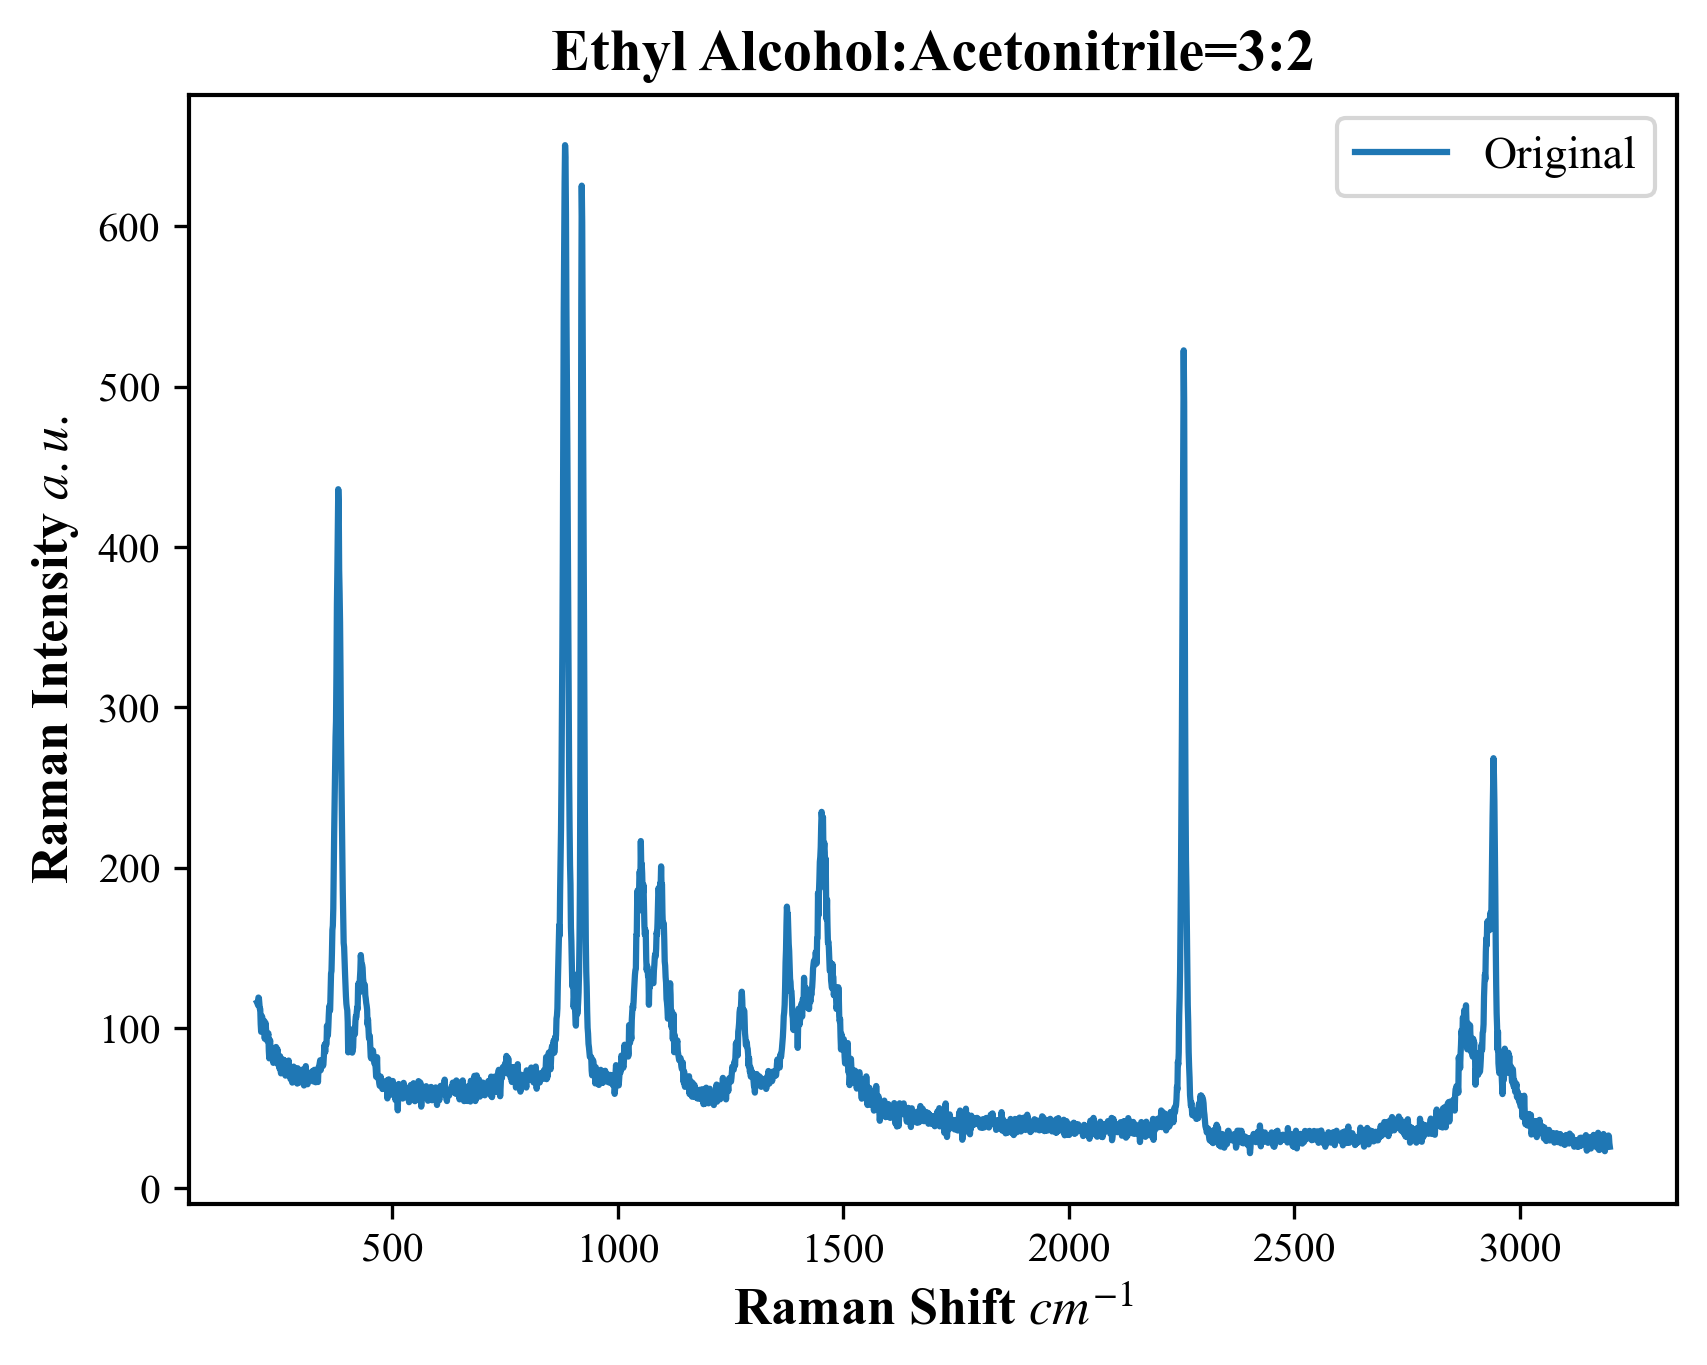

**********************************************
chemical: 7_乙醇-乙腈#3-2
输出标签为： [0.03  0.337 0.357 0.022 0.034 0.034 0.02  0.013 0.023 0.022 0.015 0.028
 0.028 0.037]
#######
预测的化学品为： ['乙醇', '乙腈']
参比分数为： [0.357, 0.337]
**********************************************


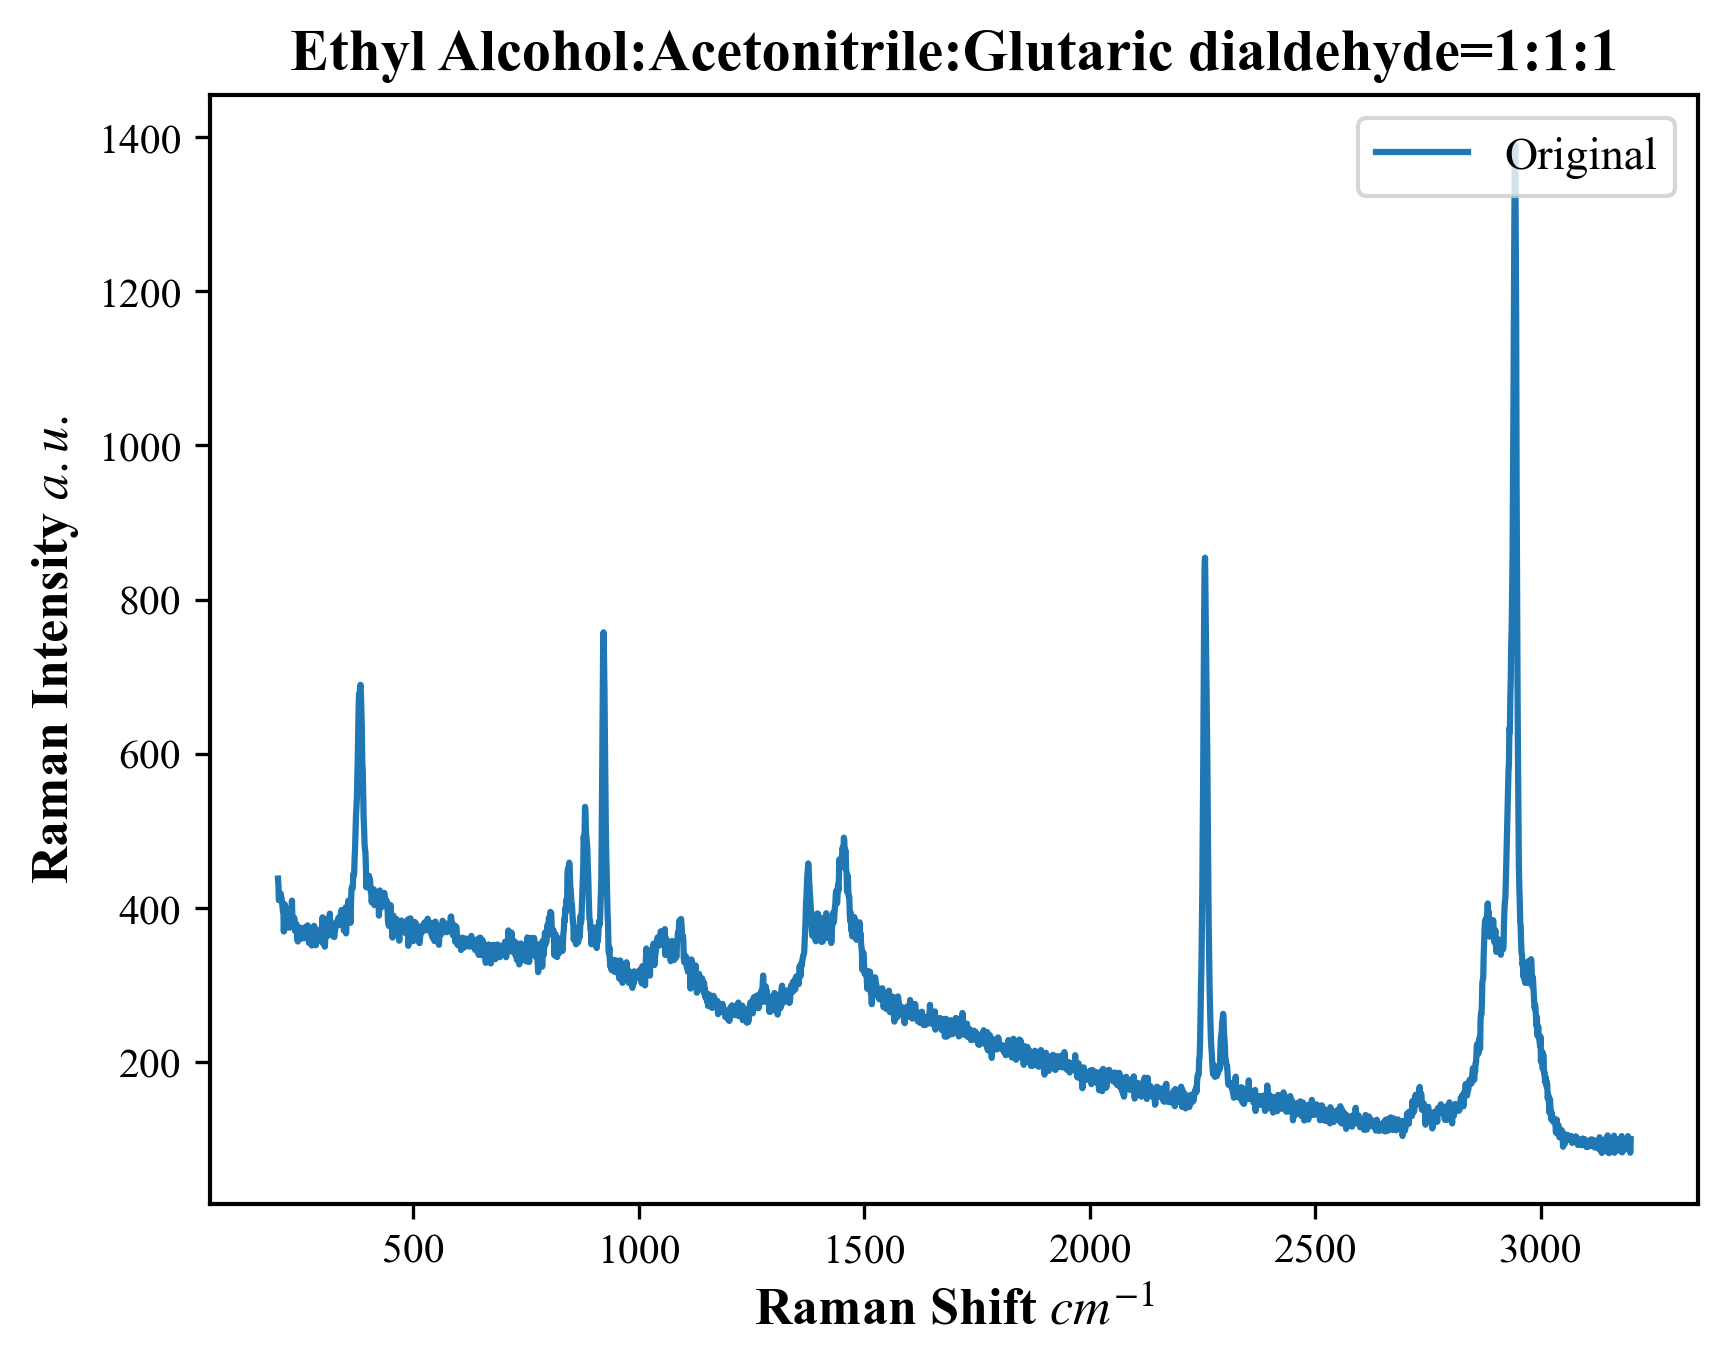

**********************************************
chemical: 8_乙醇-乙腈-戊二醛#1-1-1
输出标签为： [0.036 0.259 0.266 0.039 0.032 0.031 0.028 0.031 0.056 0.06  0.043 0.05
 0.037 0.031]
#######
预测的化学品为： ['乙醇', '乙腈']
参比分数为： [0.266, 0.259]
**********************************************


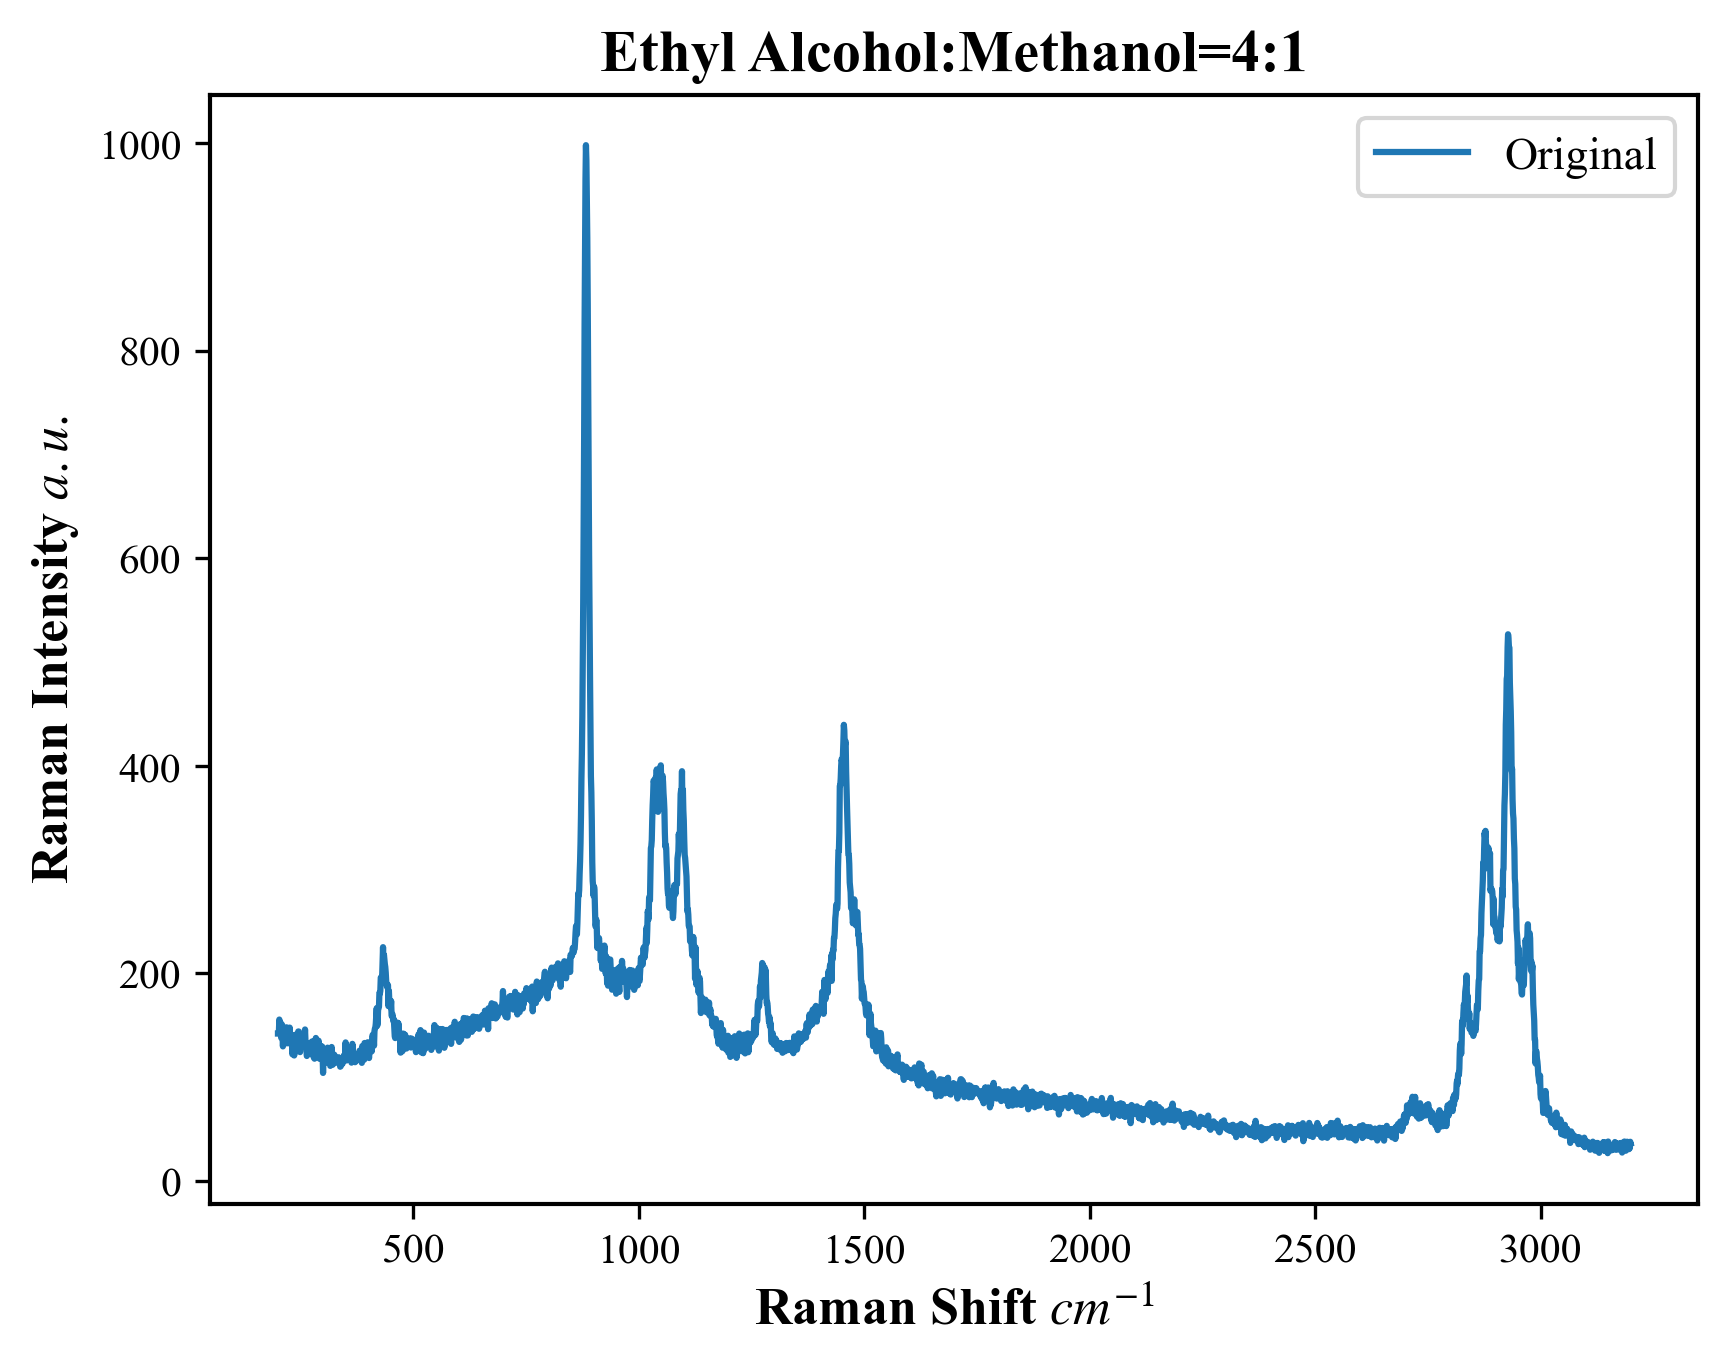

**********************************************
chemical: 9_乙醇-甲醇#4-1
输出标签为： [0.034 0.016 0.447 0.013 0.031 0.037 0.018 0.025 0.019 0.017 0.253 0.018
 0.018 0.053]
#######
预测的化学品为： ['乙醇', '甲醇']
参比分数为： [0.447, 0.253]
**********************************************


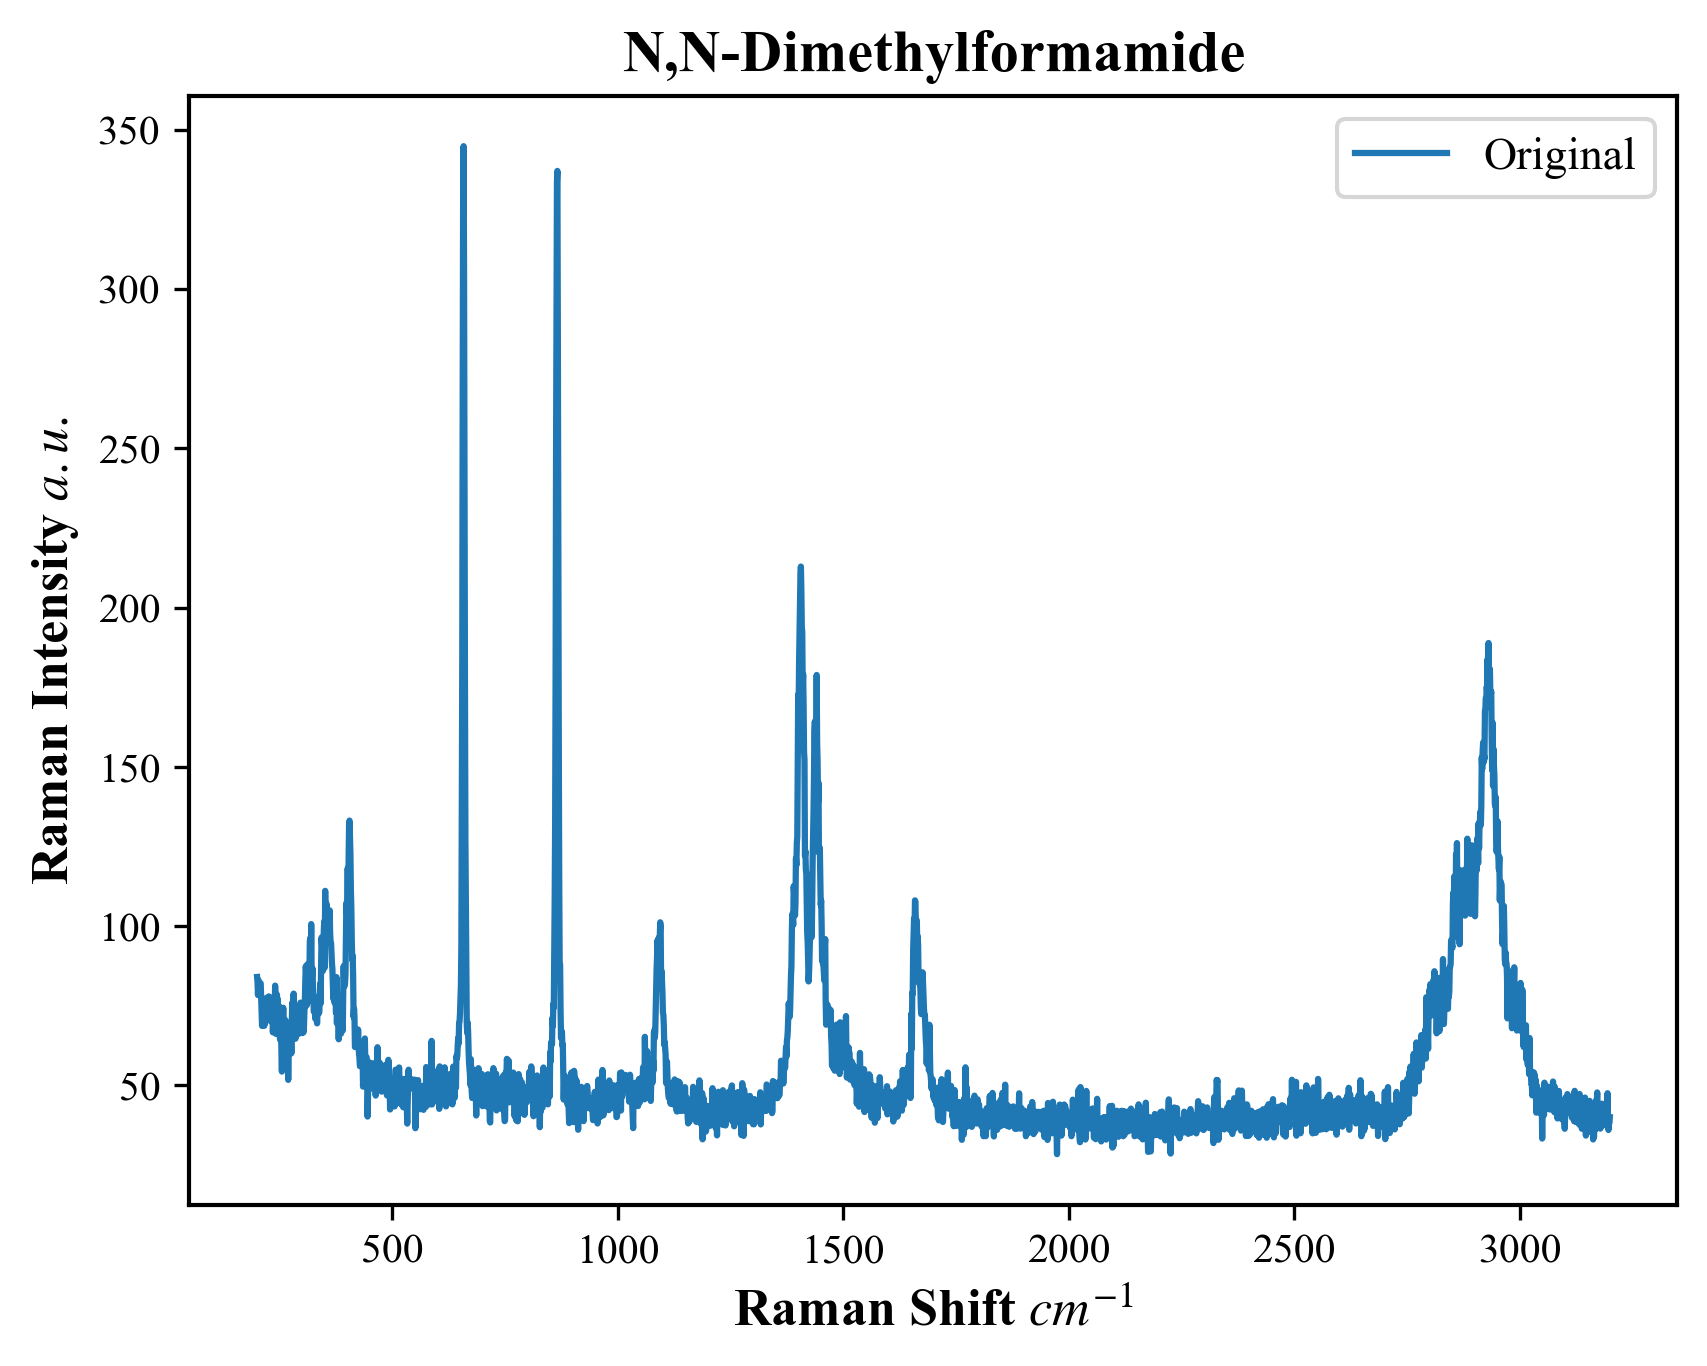

**********************************************
chemical: N,N-二甲基甲酰胺
输出标签为： [0.028 0.015 0.024 0.04  0.029 0.02  0.025 0.026 0.044 0.034 0.023 0.65
 0.021 0.022]
#######
预测的化学品为： ['N,N-二甲基甲酰胺']
参比分数为： [0.65]
**********************************************


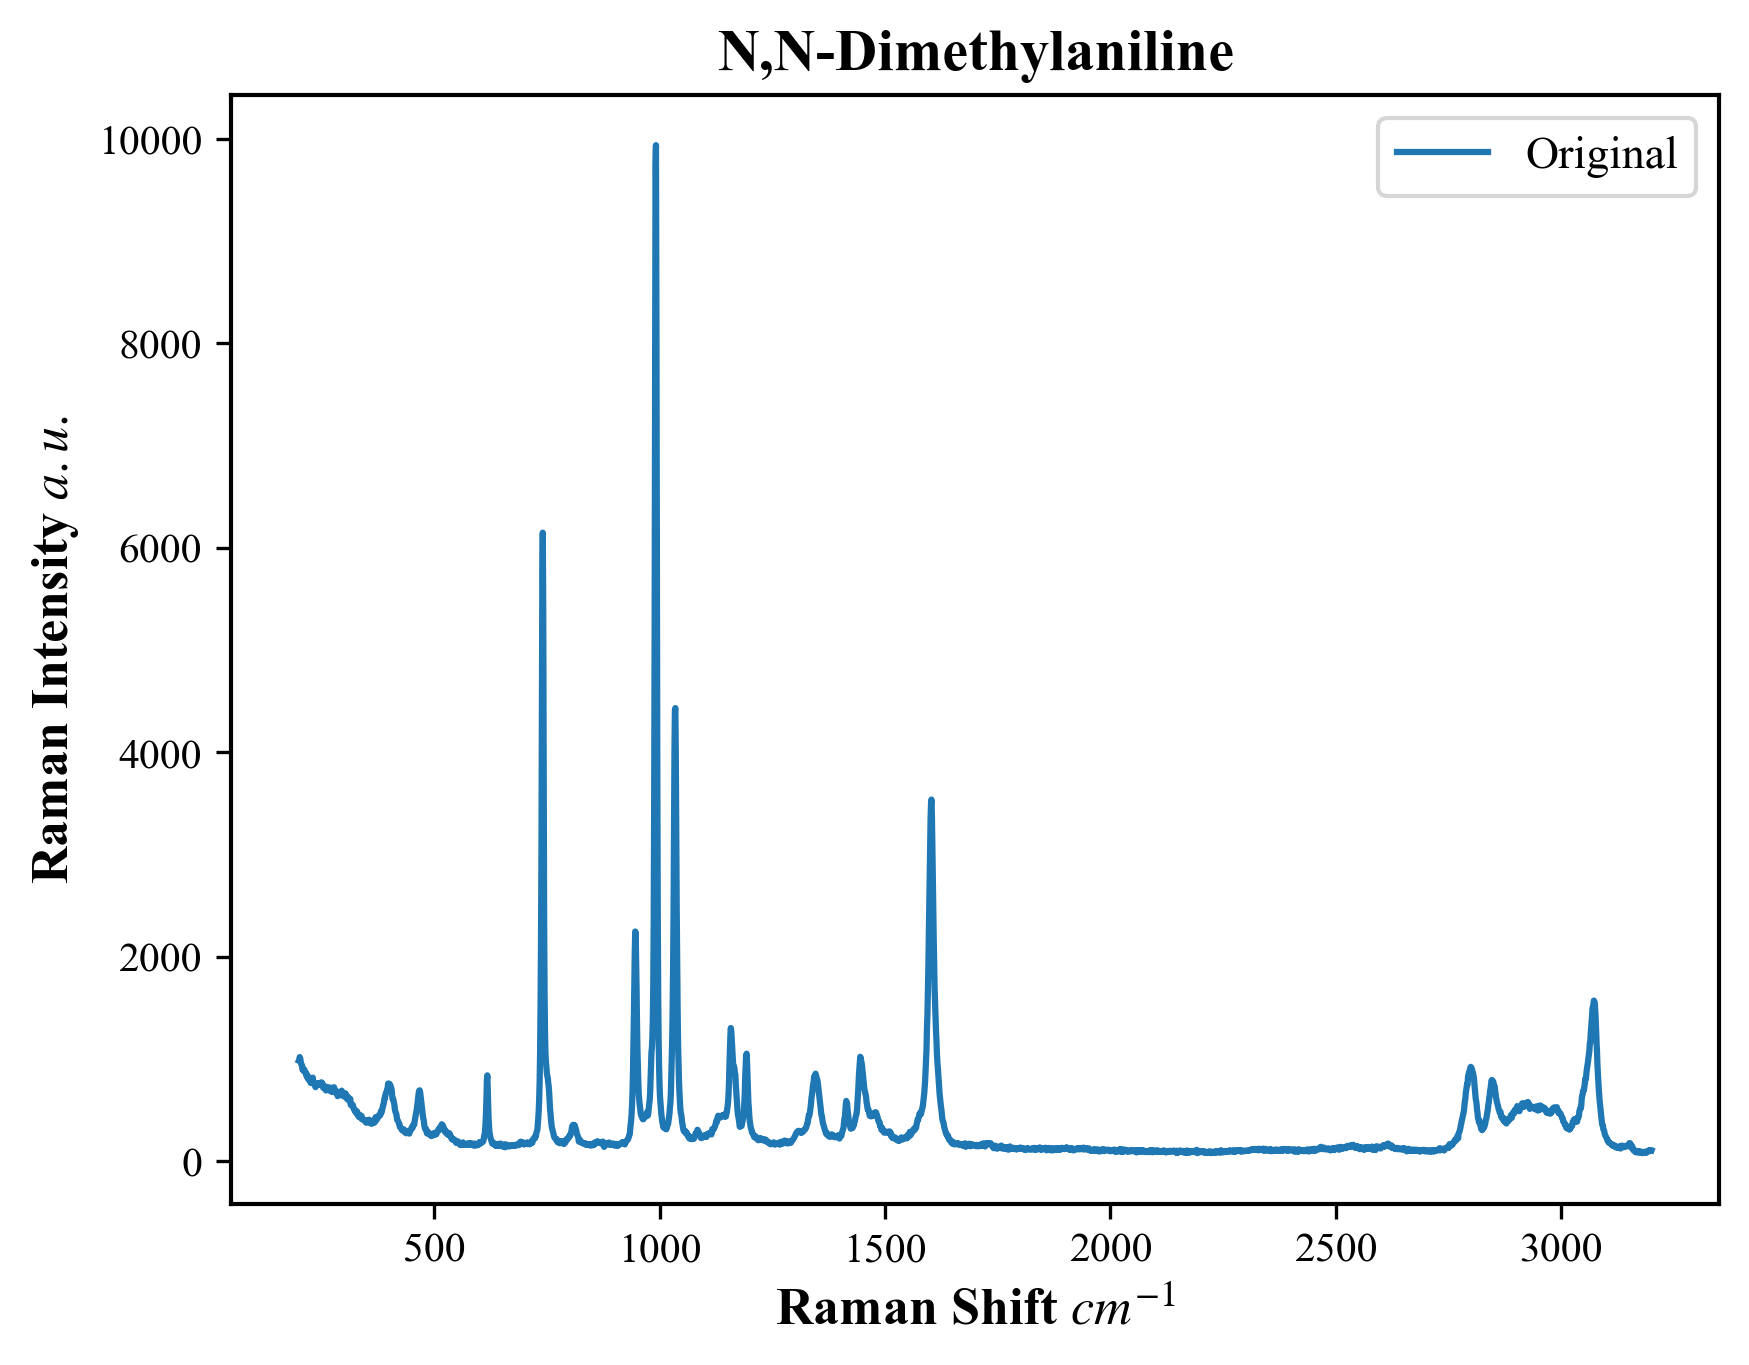

**********************************************
chemical: N,N-二甲基苯胺
输出标签为： [0.03  0.019 0.019 0.021 0.014 0.022 0.022 0.022 0.023 0.021 0.023 0.025
 0.718 0.021]
#######
预测的化学品为： ['N,N-二甲基苯胺']
参比分数为： [0.718]
**********************************************


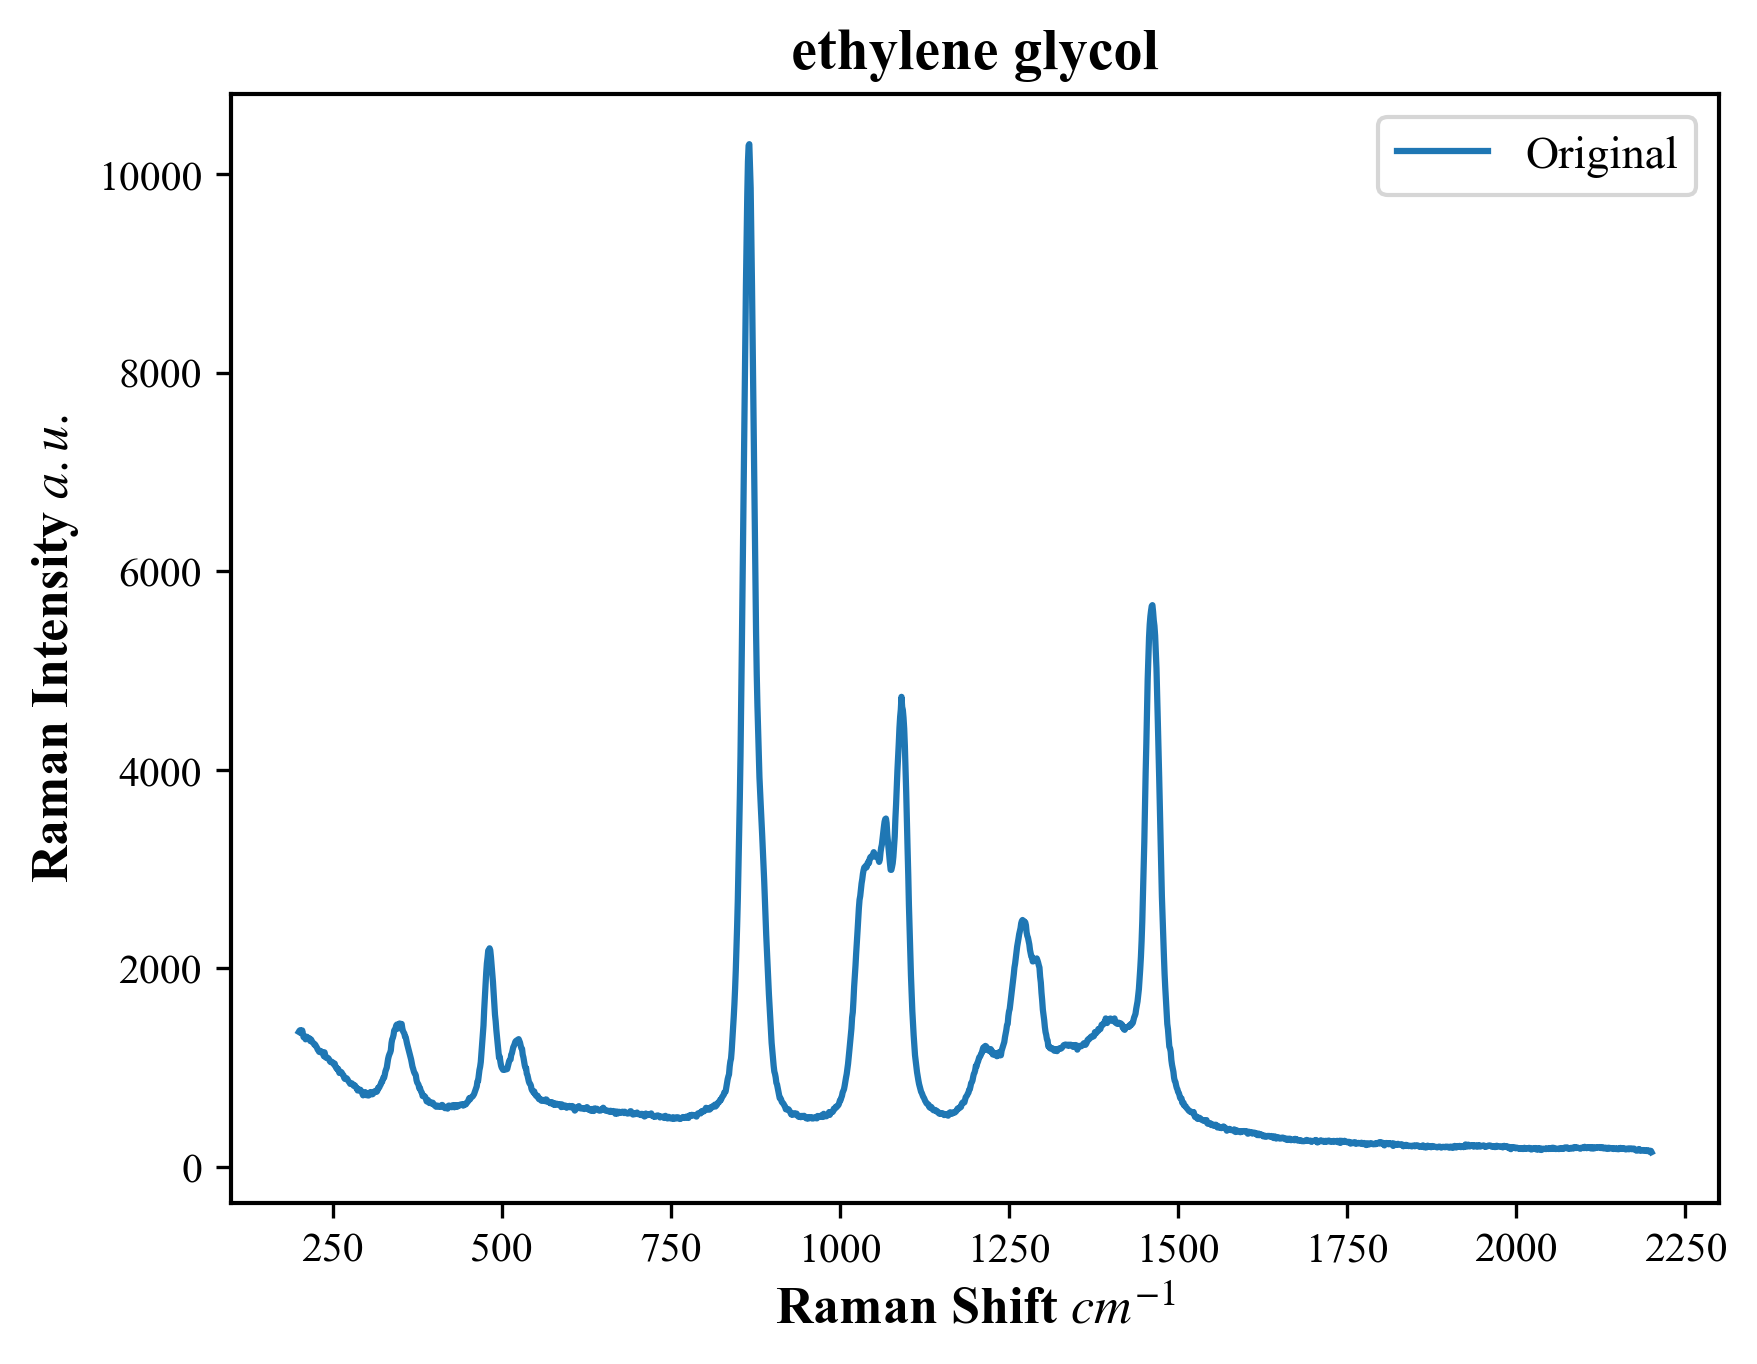

**********************************************
chemical: 乙二醇
输出标签为： [0.756 0.014 0.019 0.018 0.014 0.018 0.017 0.02  0.015 0.018 0.016 0.023
 0.024 0.027]
#######
预测的化学品为： ['乙二醇']
参比分数为： [0.756]
**********************************************


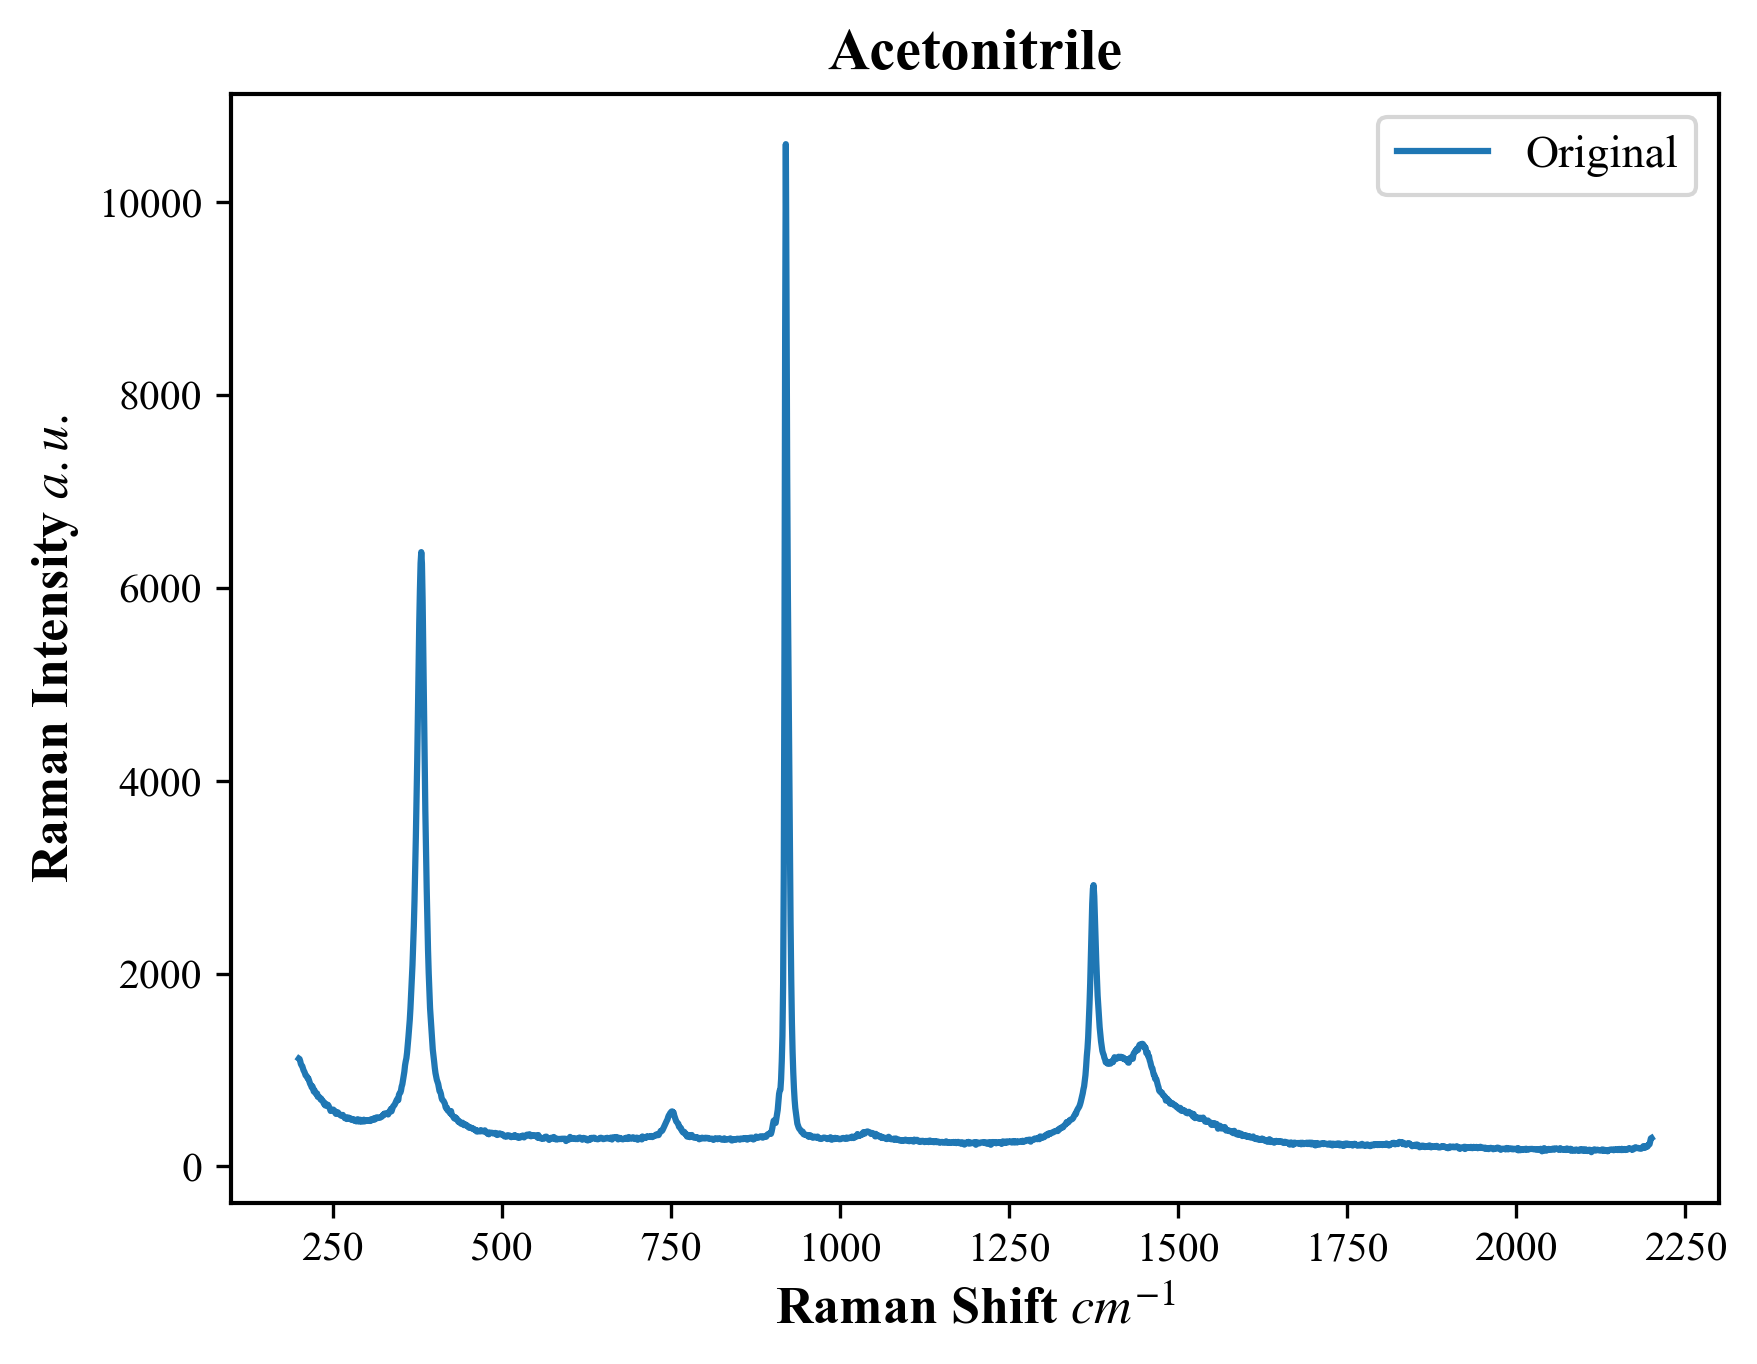

**********************************************
chemical: 乙腈
输出标签为： [0.034 0.744 0.015 0.014 0.015 0.018 0.022 0.018 0.014 0.021 0.016 0.025
 0.023 0.022]
#######
预测的化学品为： ['乙腈']
参比分数为： [0.744]
**********************************************


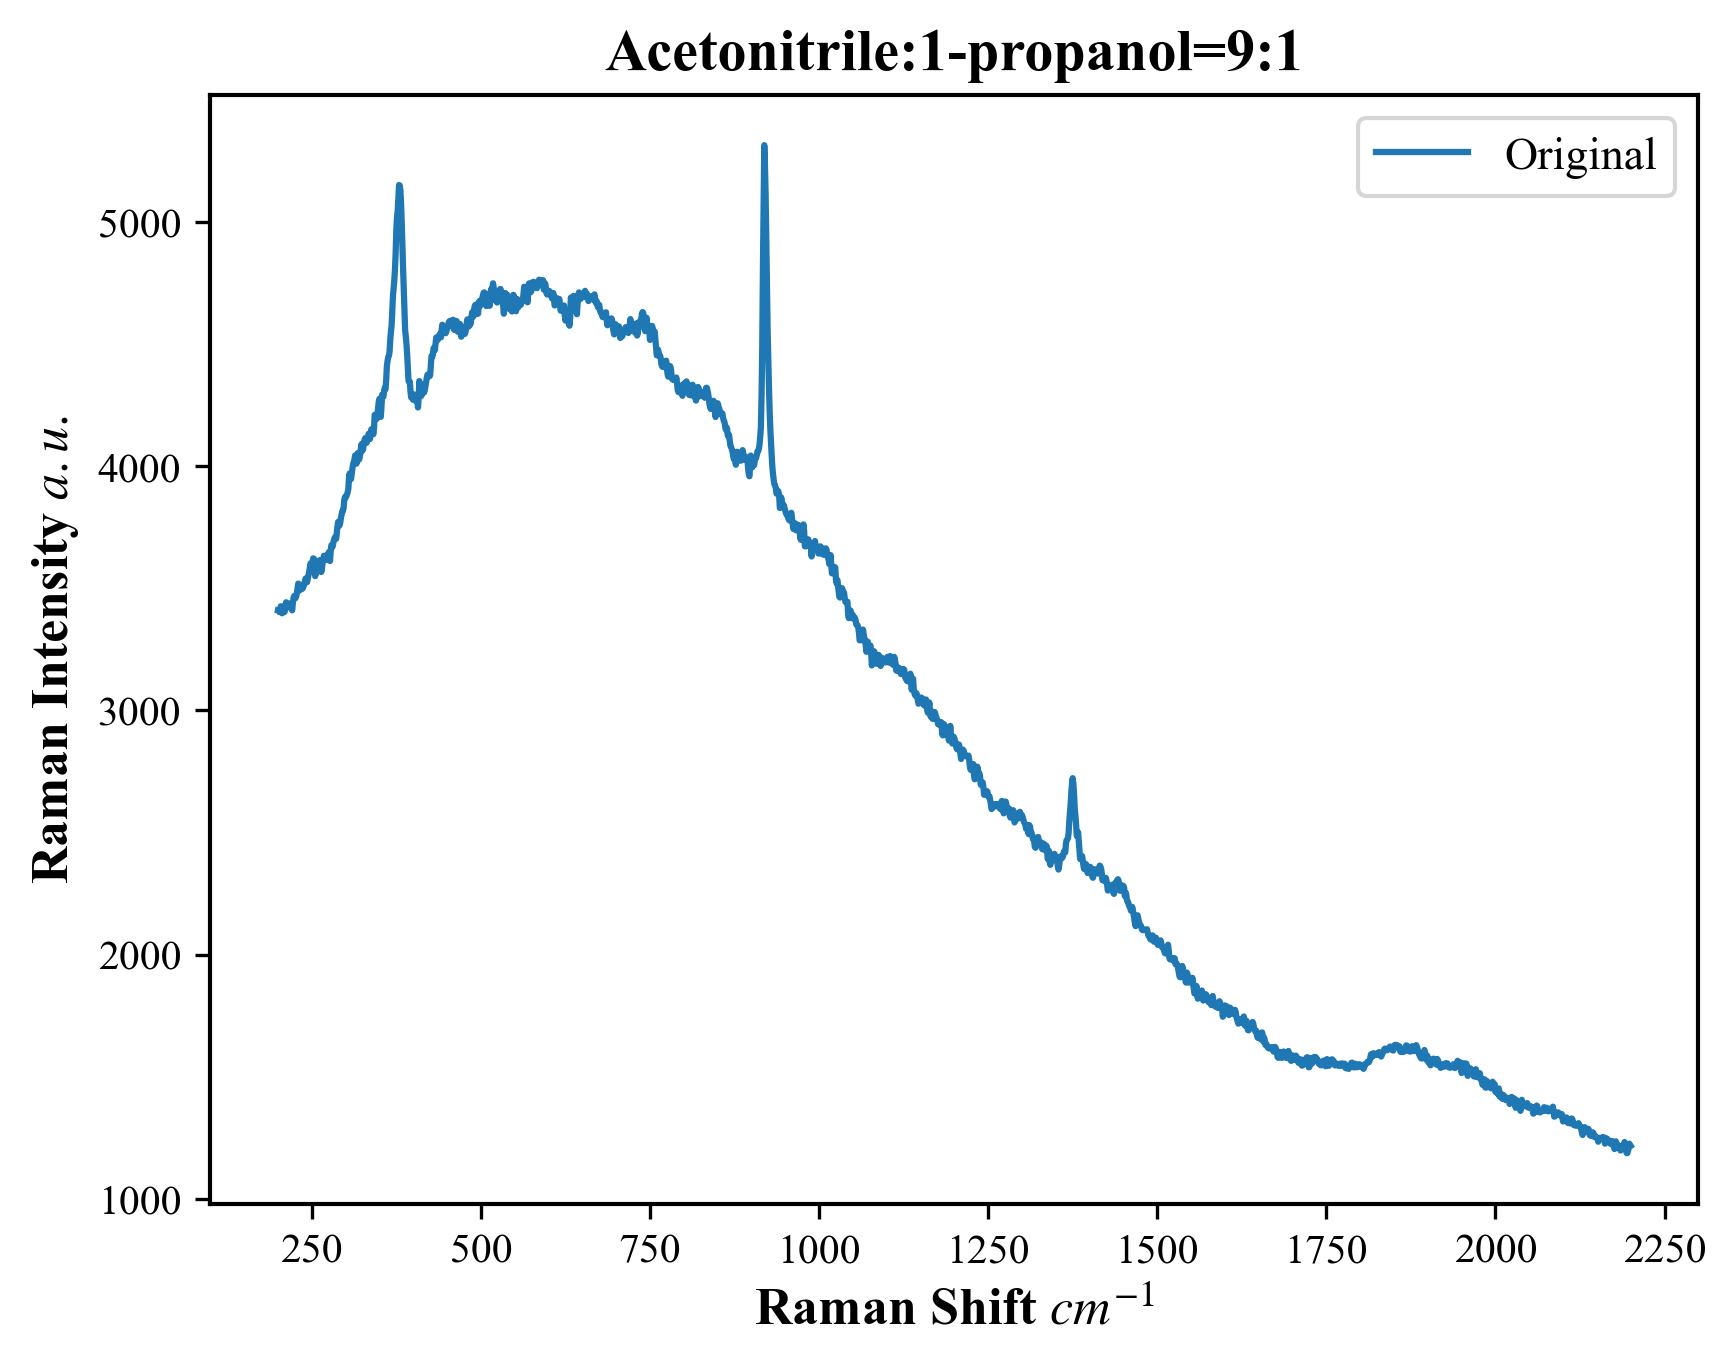

**********************************************
chemical: 乙腈-正丙醇#9-1
输出标签为： [0.068 0.136 0.067 0.057 0.085 0.075 0.077 0.065 0.061 0.062 0.058 0.056
 0.062 0.071]
#######
预测的化学品为： ['乙腈']
参比分数为： [0.136]
**********************************************


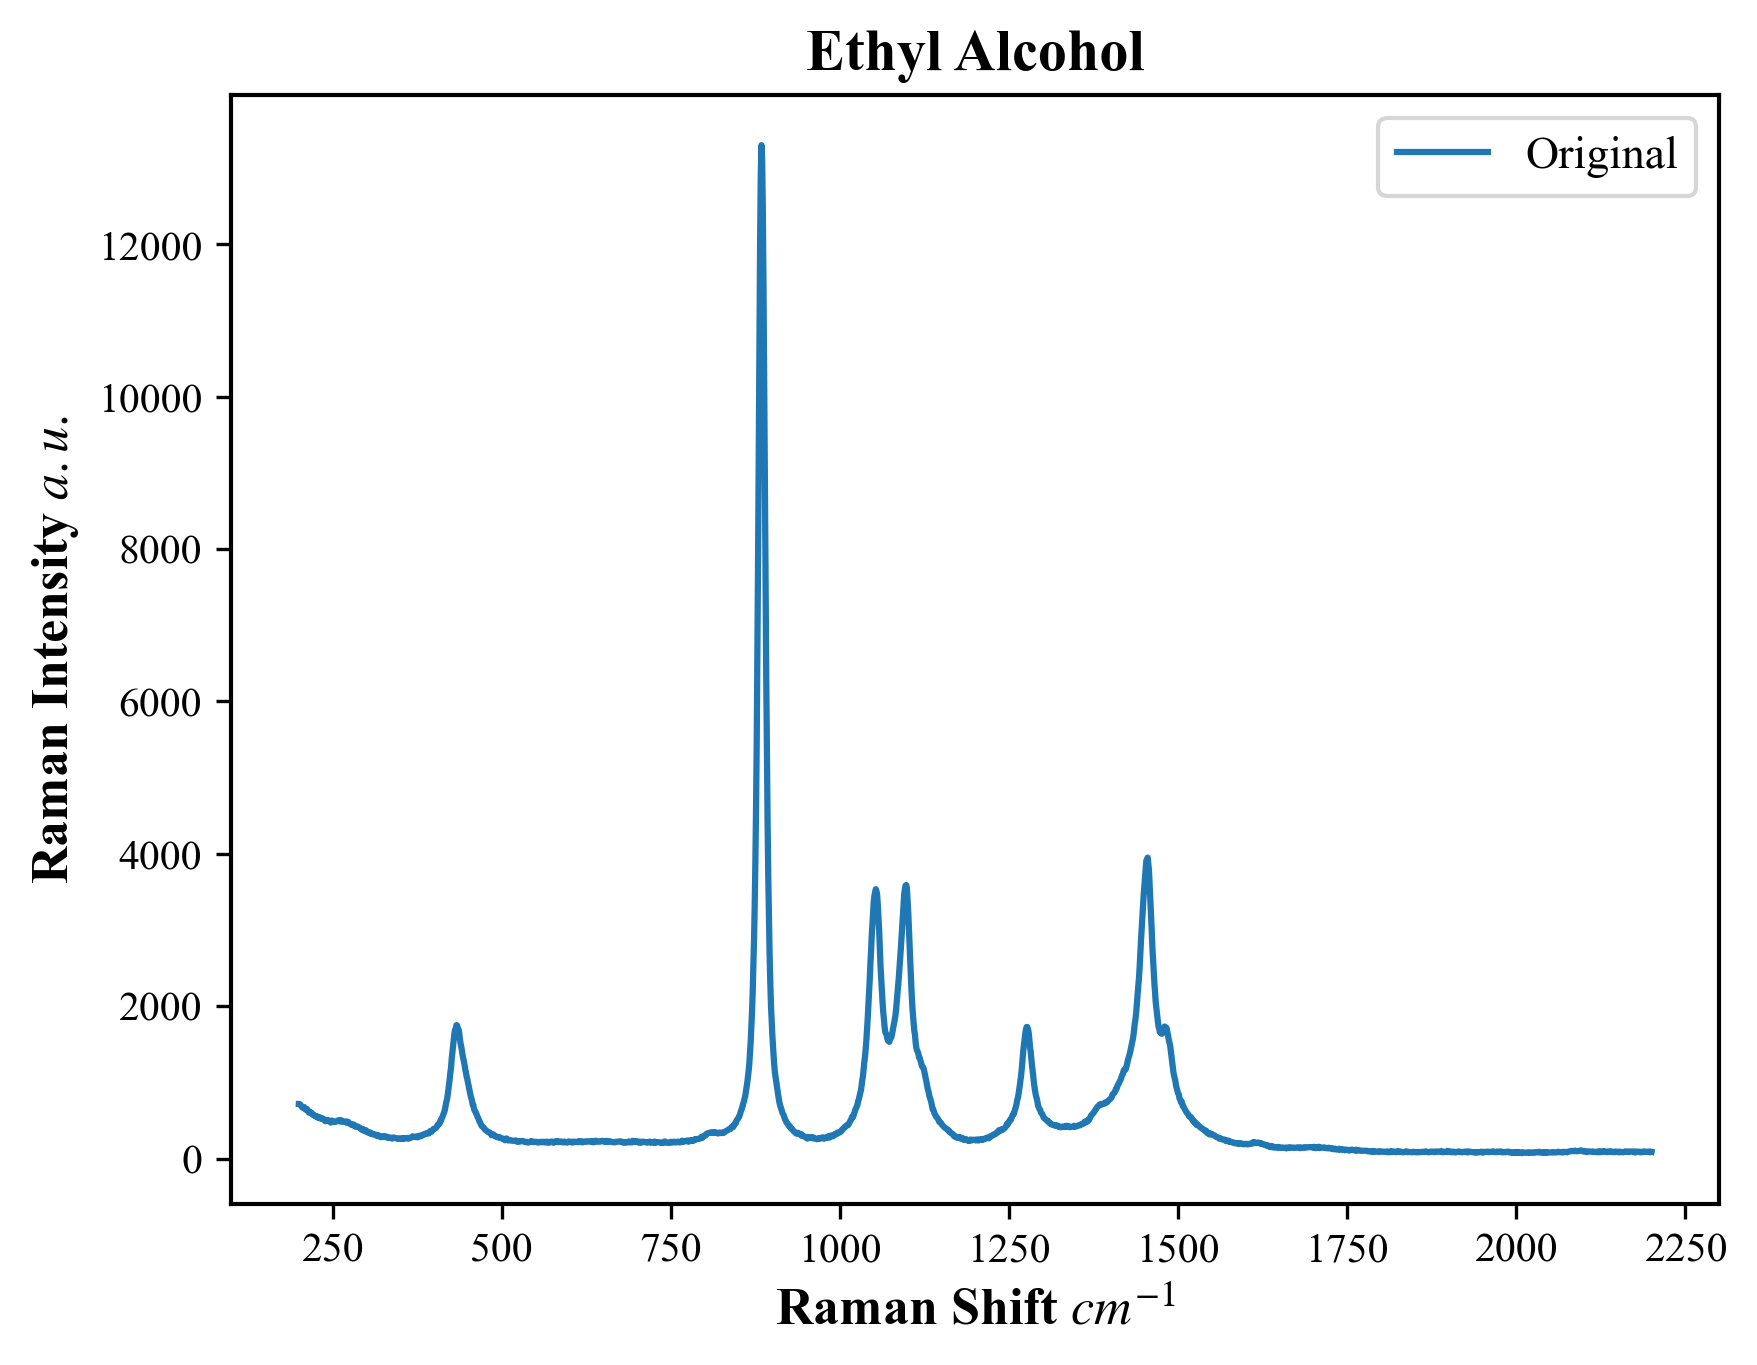

**********************************************
chemical: 乙醇
输出标签为： [0.035 0.014 0.738 0.017 0.018 0.018 0.019 0.013 0.018 0.019 0.019 0.022
 0.021 0.029]
#######
预测的化学品为： ['乙醇']
参比分数为： [0.738]
**********************************************


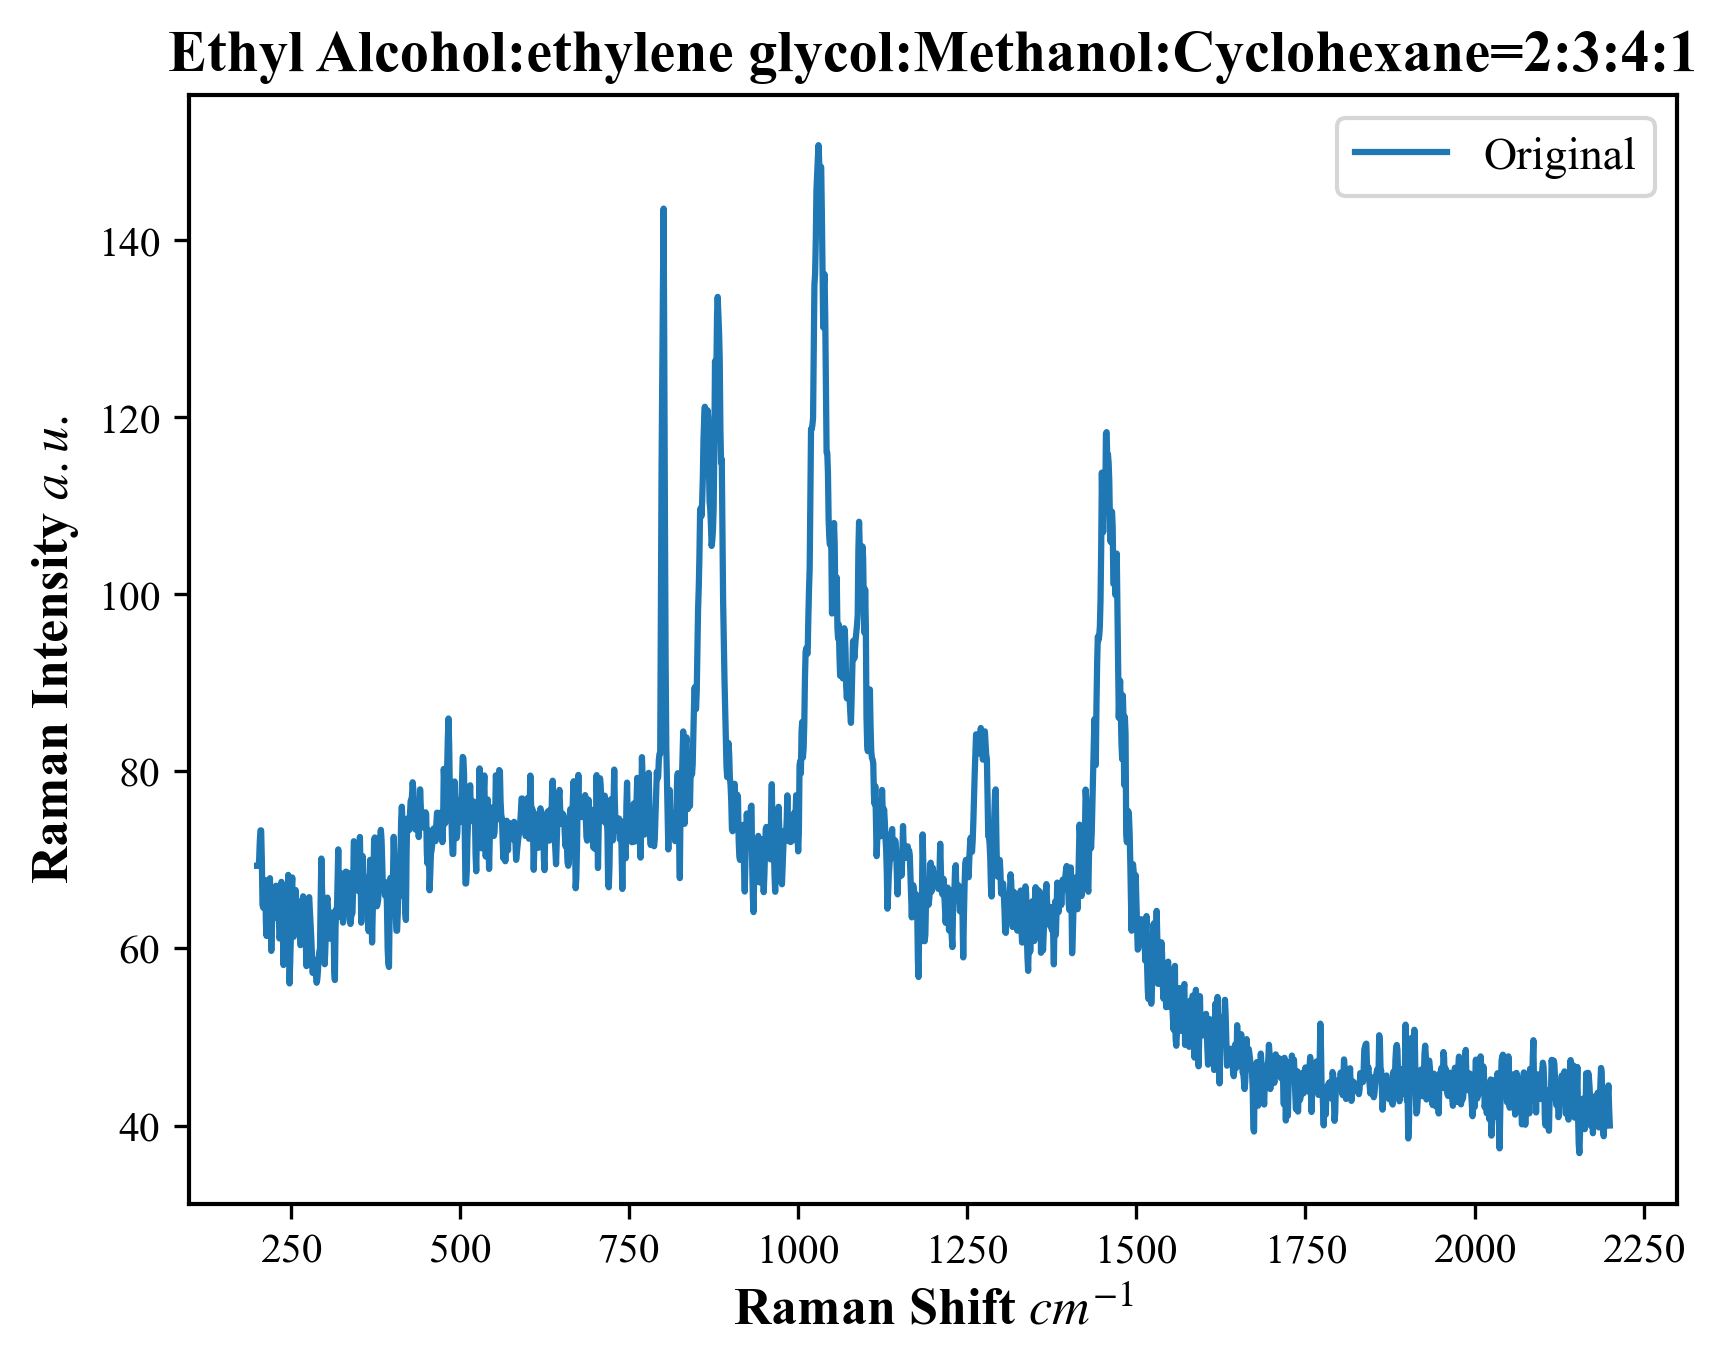

**********************************************
chemical: 乙醇-乙二醇-甲醇-环己烷#2-3-4-1
输出标签为： [0.158 0.017 0.145 0.019 0.023 0.046 0.029 0.031 0.03  0.208 0.221 0.024
 0.021 0.029]
#######
预测的化学品为： ['甲醇', '环己烷', '乙二醇', '乙醇']
参比分数为： [0.221, 0.208, 0.158, 0.145]
**********************************************


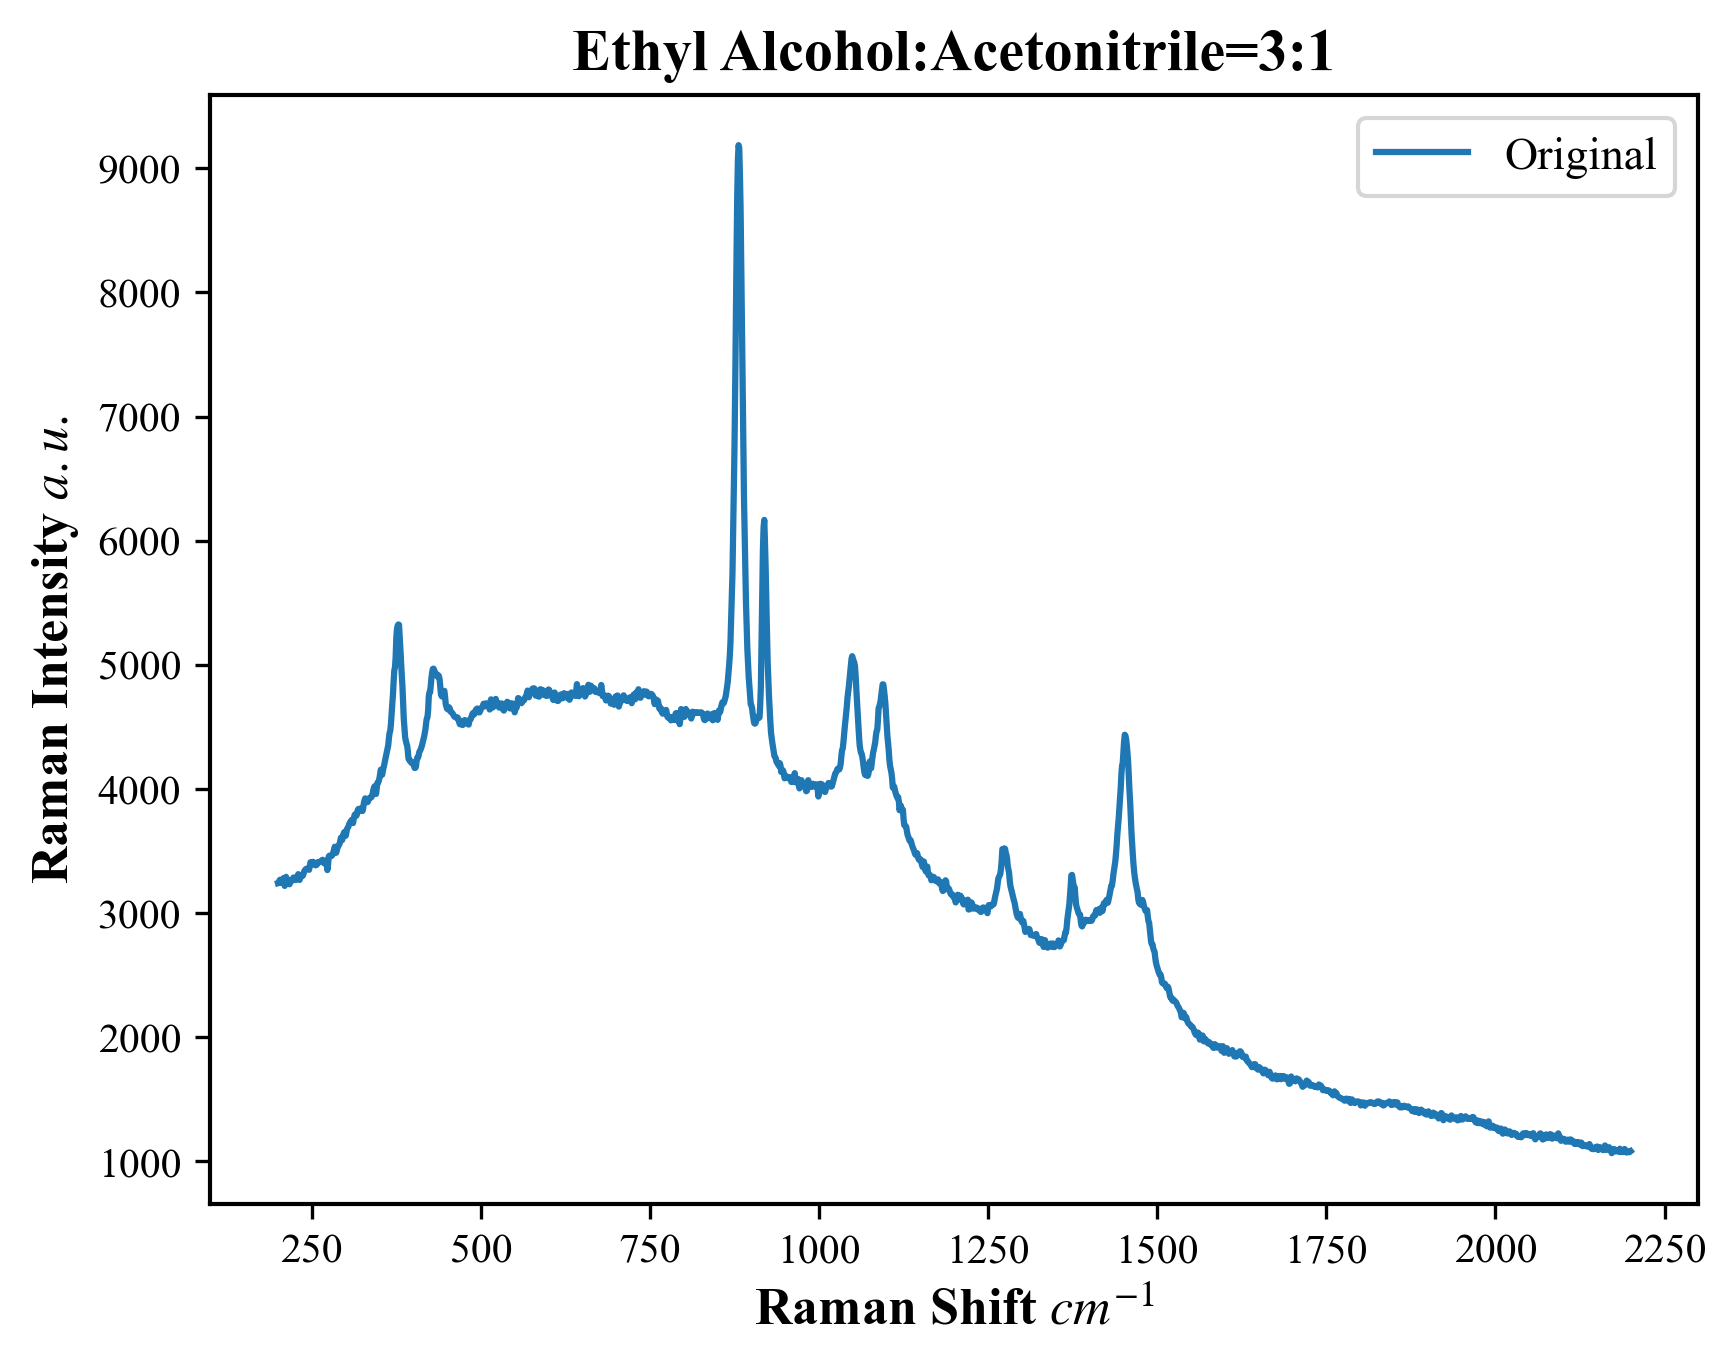

**********************************************
chemical: 乙醇-乙腈#3-1
输出标签为： [0.033 0.175 0.342 0.045 0.041 0.034 0.077 0.032 0.027 0.027 0.044 0.036
 0.033 0.055]
#######
预测的化学品为： ['乙醇', '乙腈']
参比分数为： [0.342, 0.175]
**********************************************


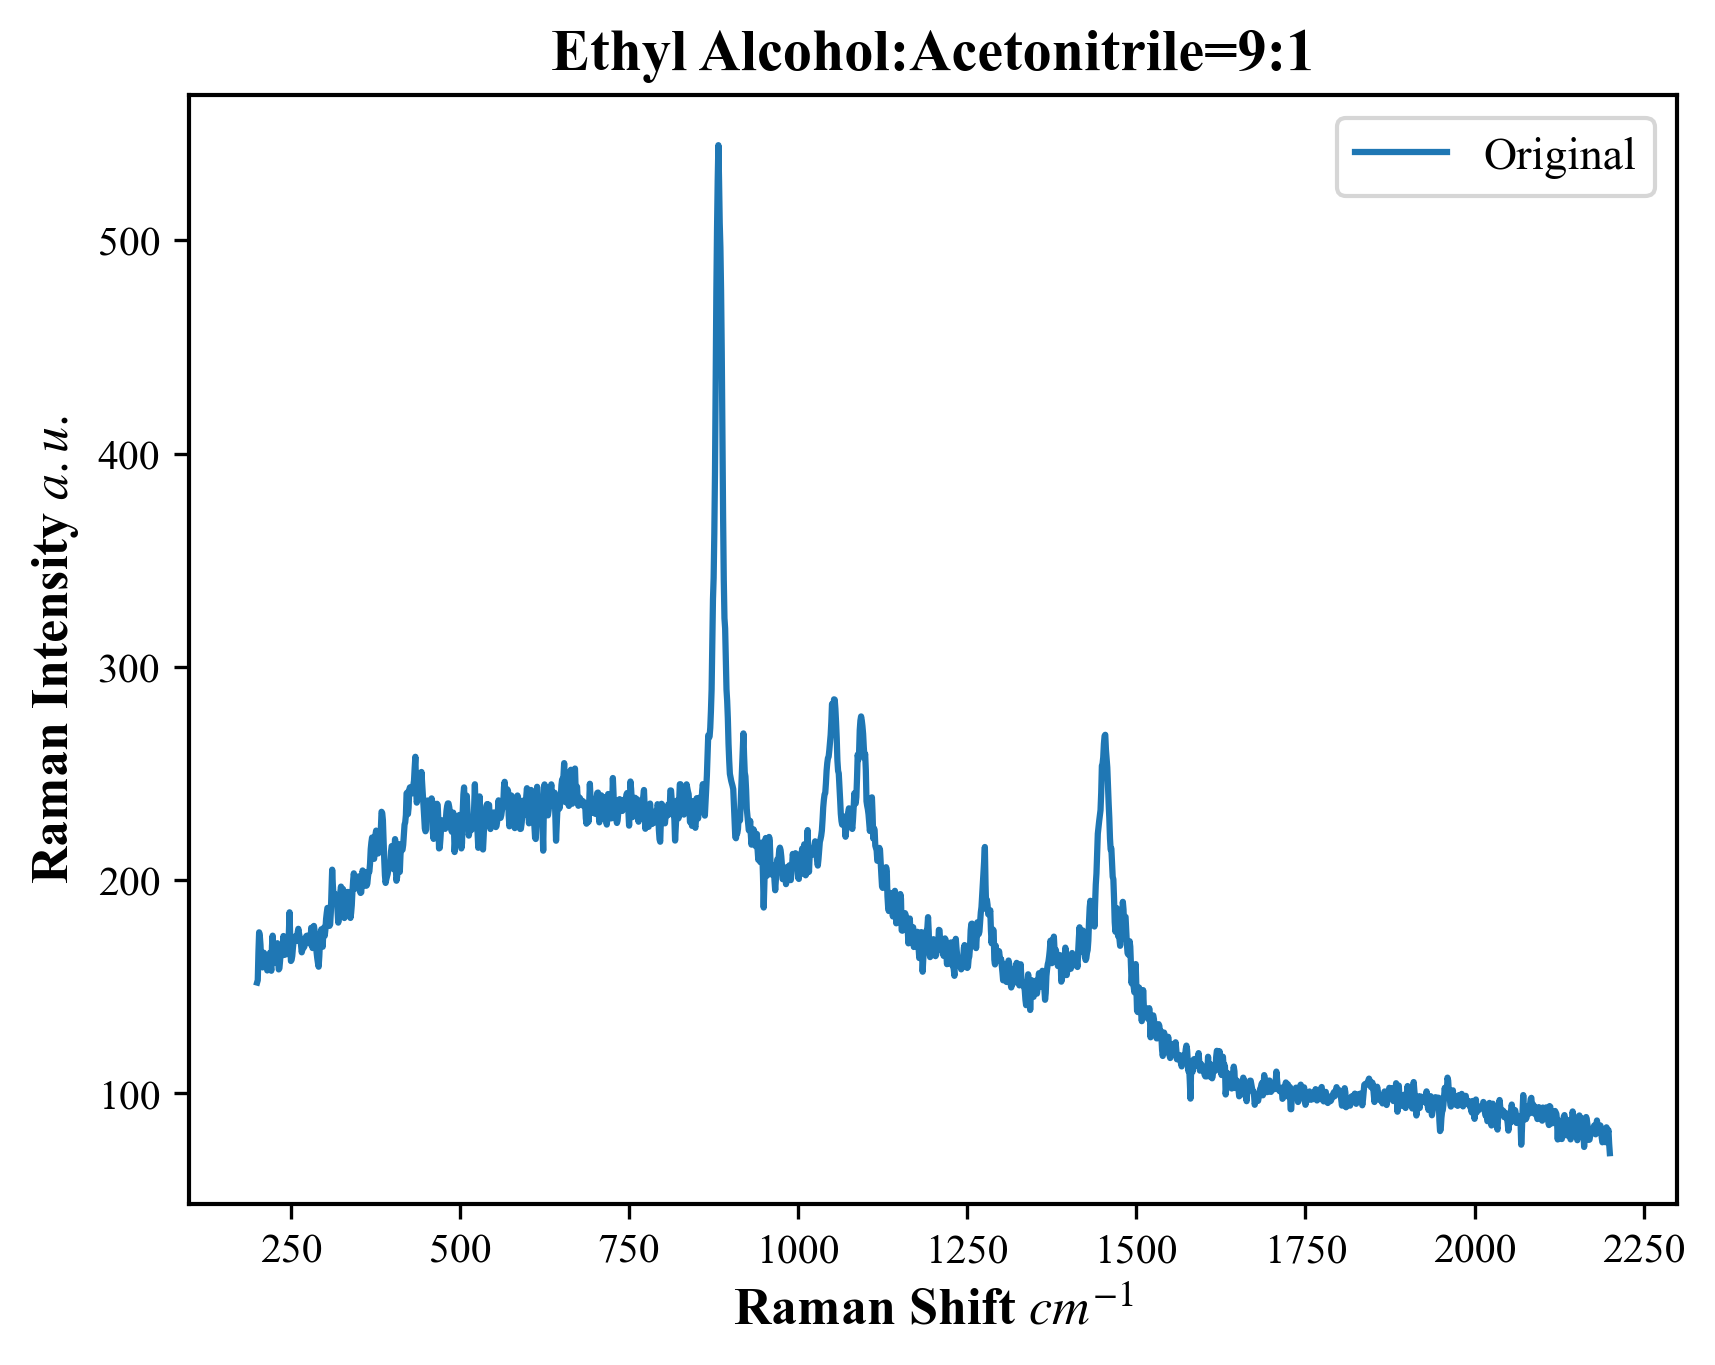

**********************************************
chemical: 乙醇-乙腈#9-1
输出标签为： [0.03  0.119 0.414 0.035 0.026 0.042 0.042 0.031 0.036 0.03  0.055 0.026
 0.029 0.085]
#######
预测的化学品为： ['乙醇', '乙腈']
参比分数为： [0.414, 0.119]
**********************************************


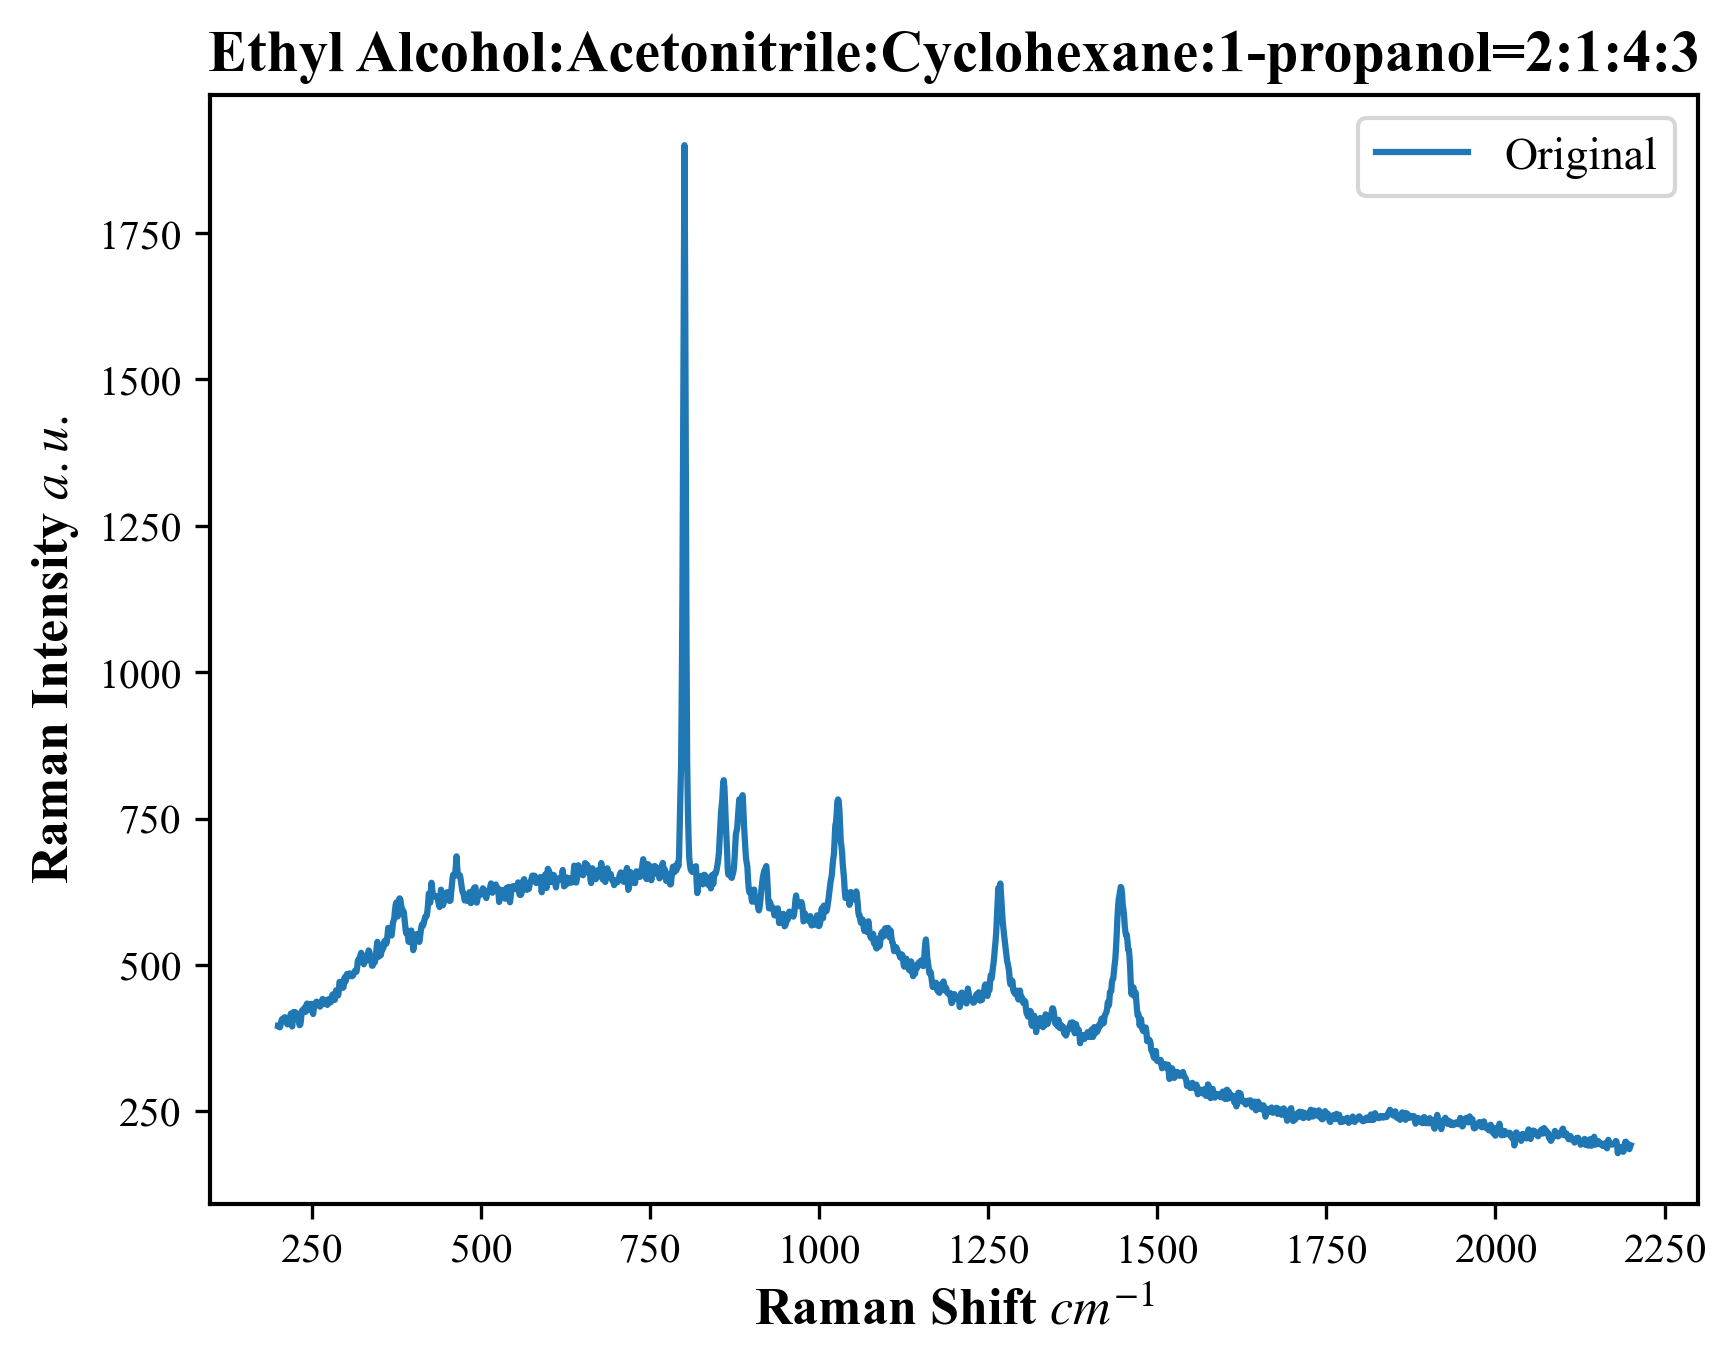

**********************************************
chemical: 乙醇-乙腈-环己烷-正丙醇#2-1-4-3
输出标签为： [0.029 0.073 0.21  0.022 0.045 0.045 0.025 0.03  0.027 0.289 0.11  0.029
 0.018 0.048]
#######
预测的化学品为： ['环己烷', '乙醇', '甲醇']
参比分数为： [0.289, 0.21, 0.11]
**********************************************


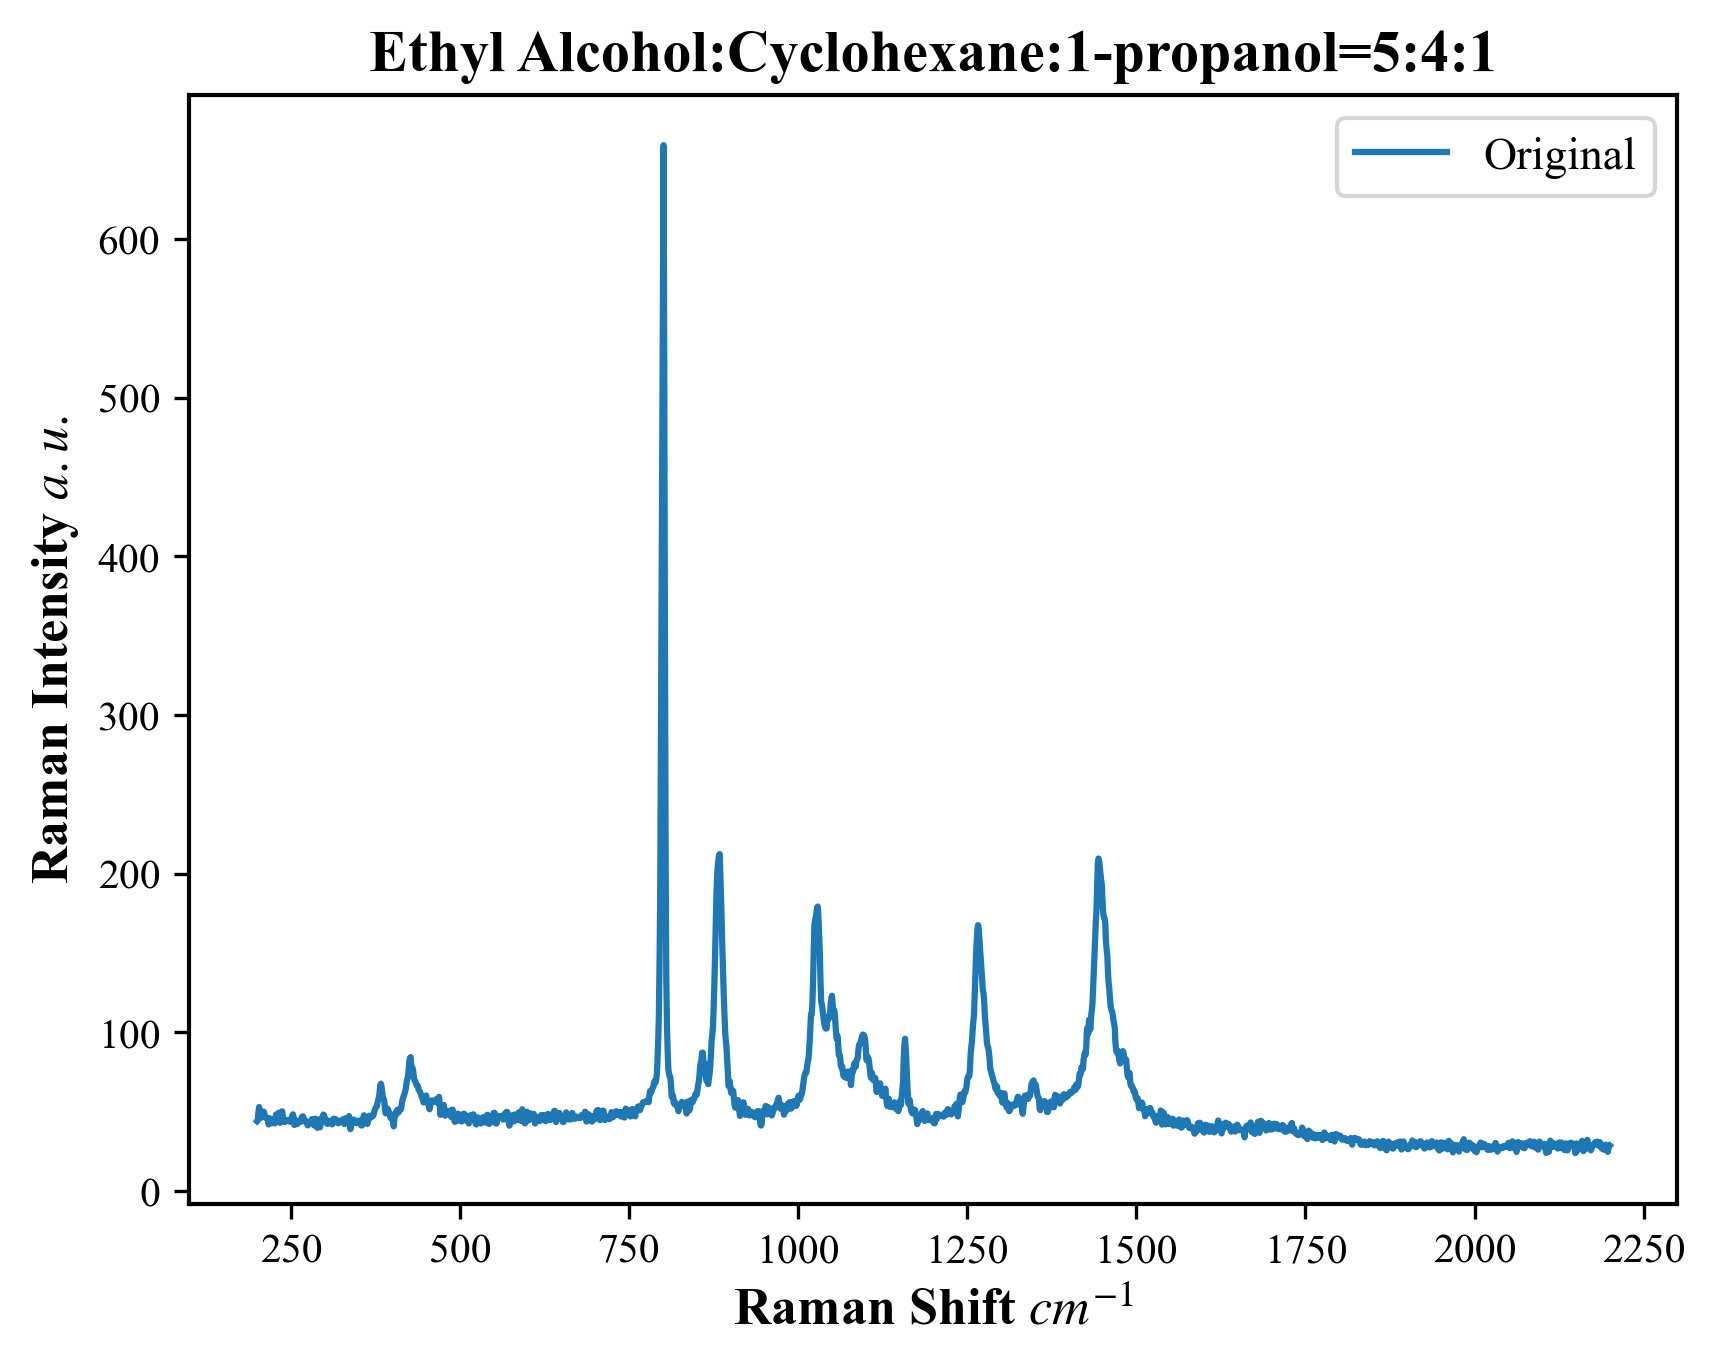

**********************************************
chemical: 乙醇-环己烷-正丙醇#5-4-1
输出标签为： [0.034 0.02  0.272 0.027 0.022 0.028 0.029 0.017 0.016 0.382 0.074 0.022
 0.017 0.038]
#######
预测的化学品为： ['环己烷', '乙醇']
参比分数为： [0.382, 0.272]
**********************************************


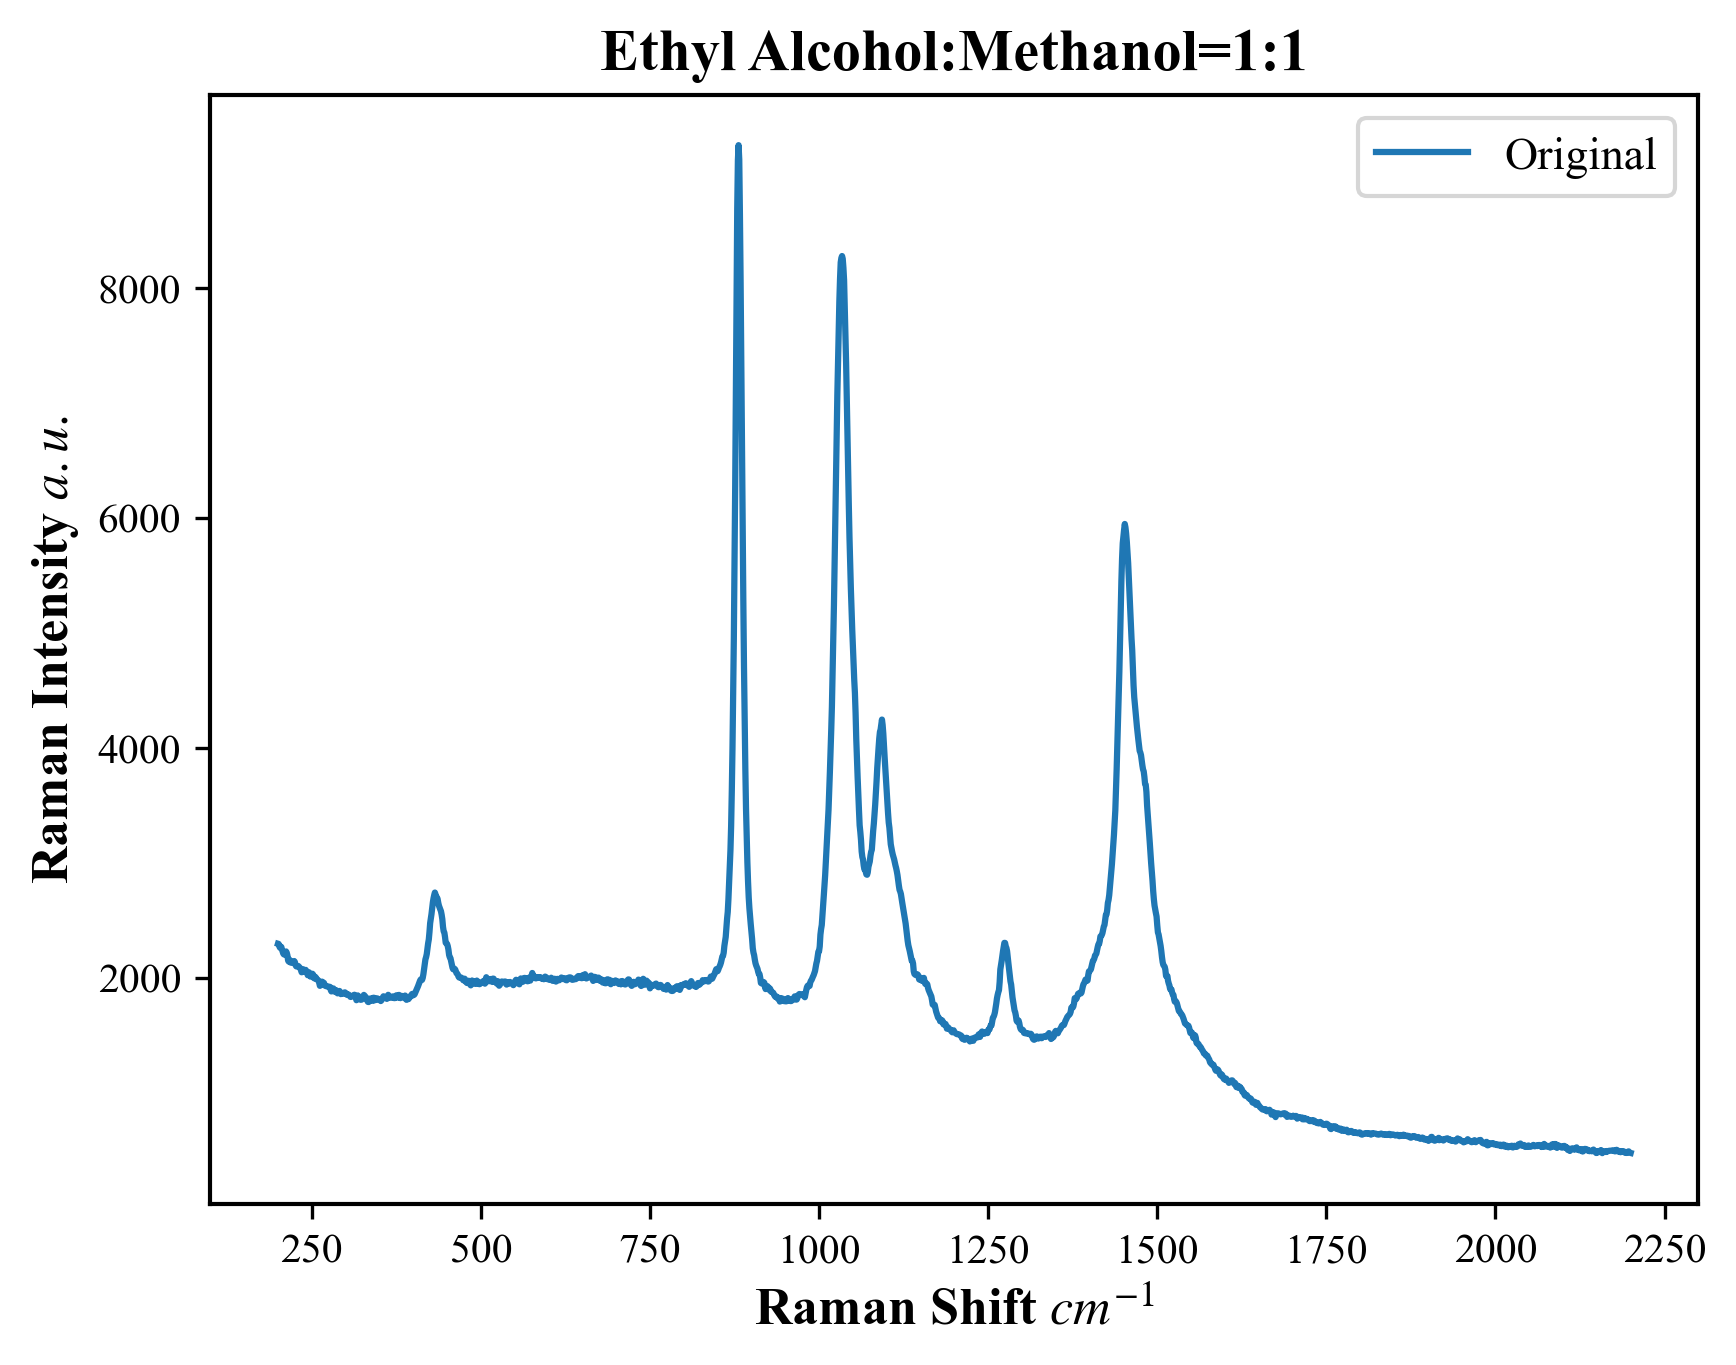

**********************************************
chemical: 乙醇-甲醇#1-1
输出标签为： [0.031 0.017 0.28  0.021 0.023 0.055 0.03  0.026 0.028 0.022 0.369 0.022
 0.03  0.046]
#######
预测的化学品为： ['甲醇', '乙醇']
参比分数为： [0.369, 0.28]
**********************************************


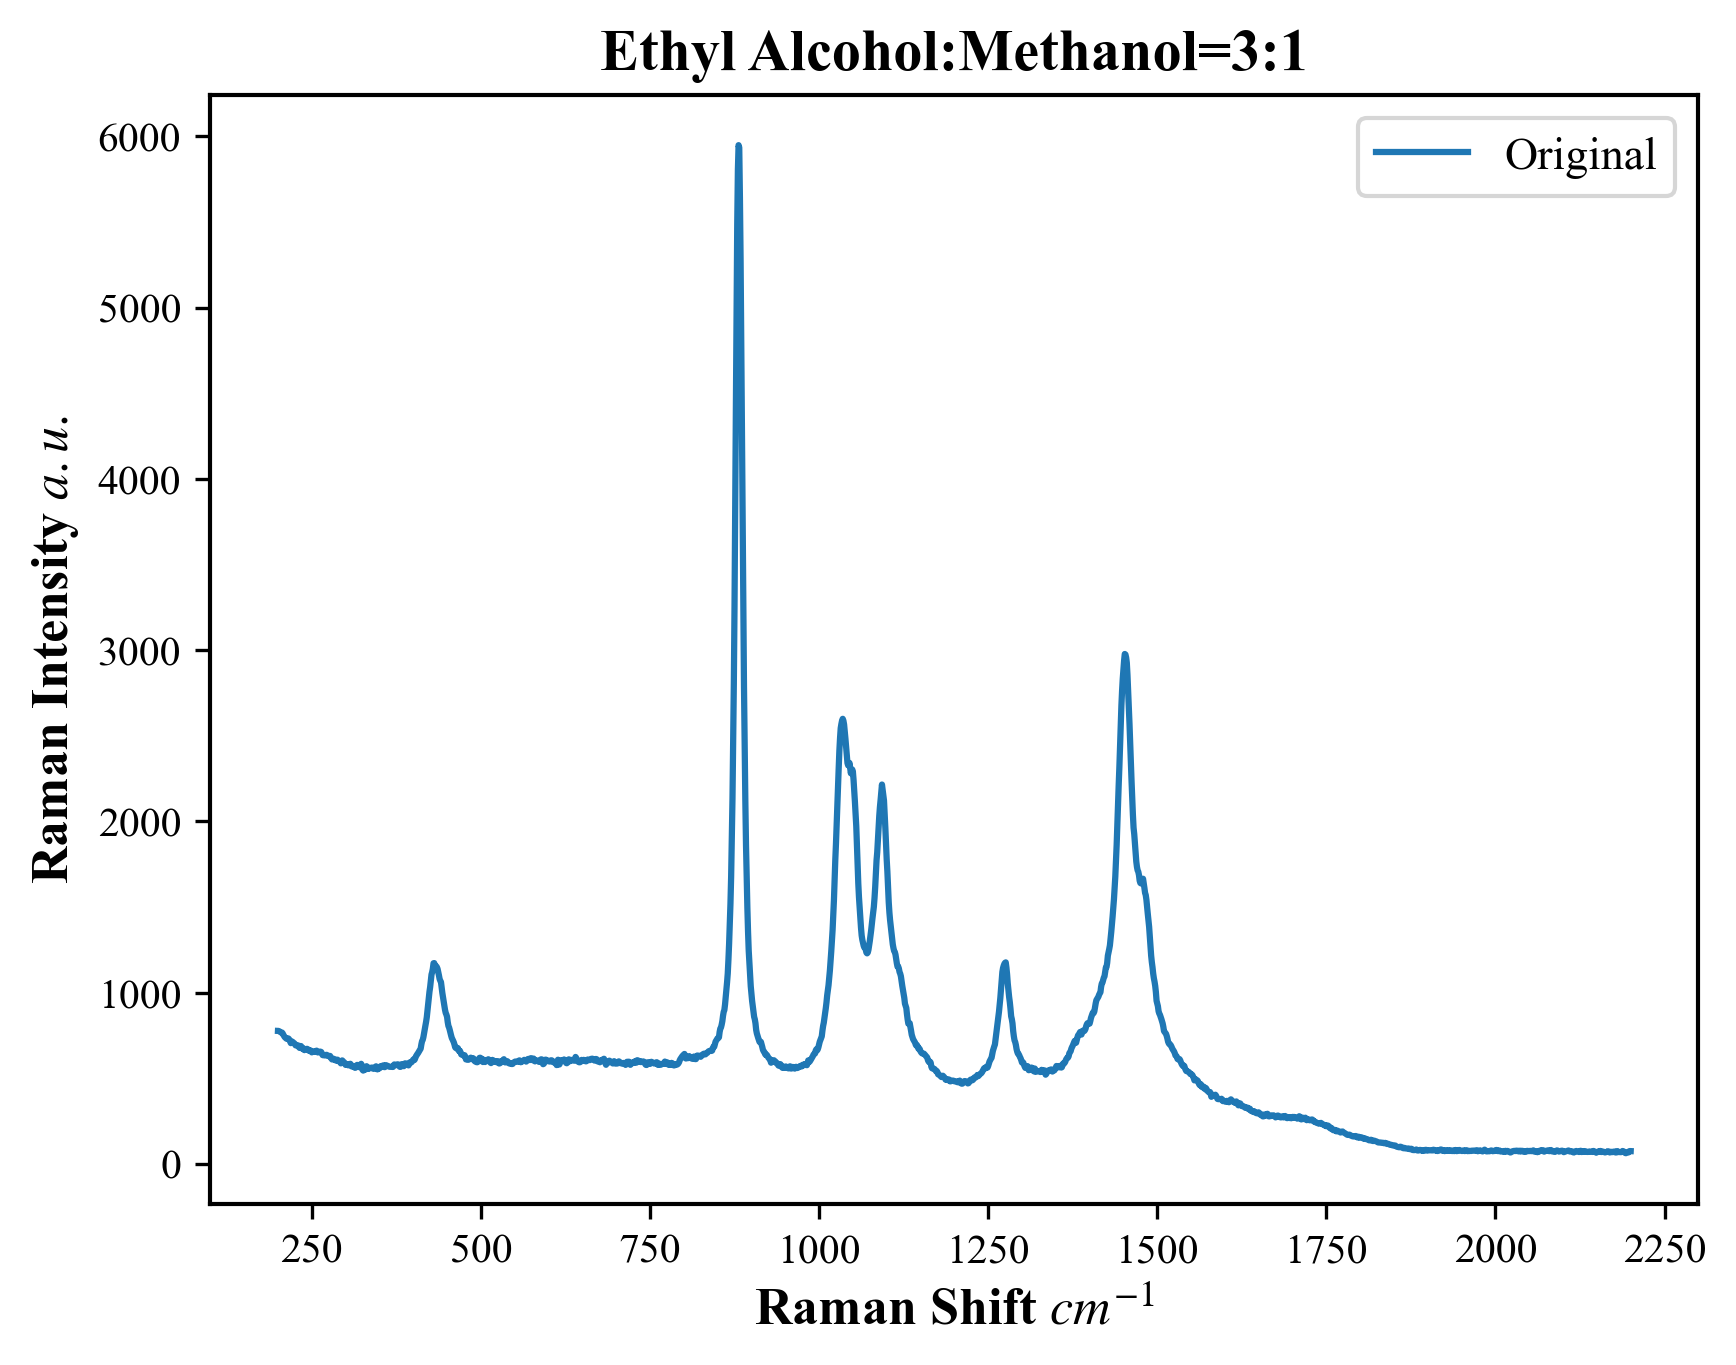

**********************************************
chemical: 乙醇-甲醇#3-1
输出标签为： [0.028 0.015 0.348 0.024 0.026 0.043 0.034 0.024 0.017 0.019 0.33  0.015
 0.027 0.05 ]
#######
预测的化学品为： ['乙醇', '甲醇']
参比分数为： [0.348, 0.33]
**********************************************


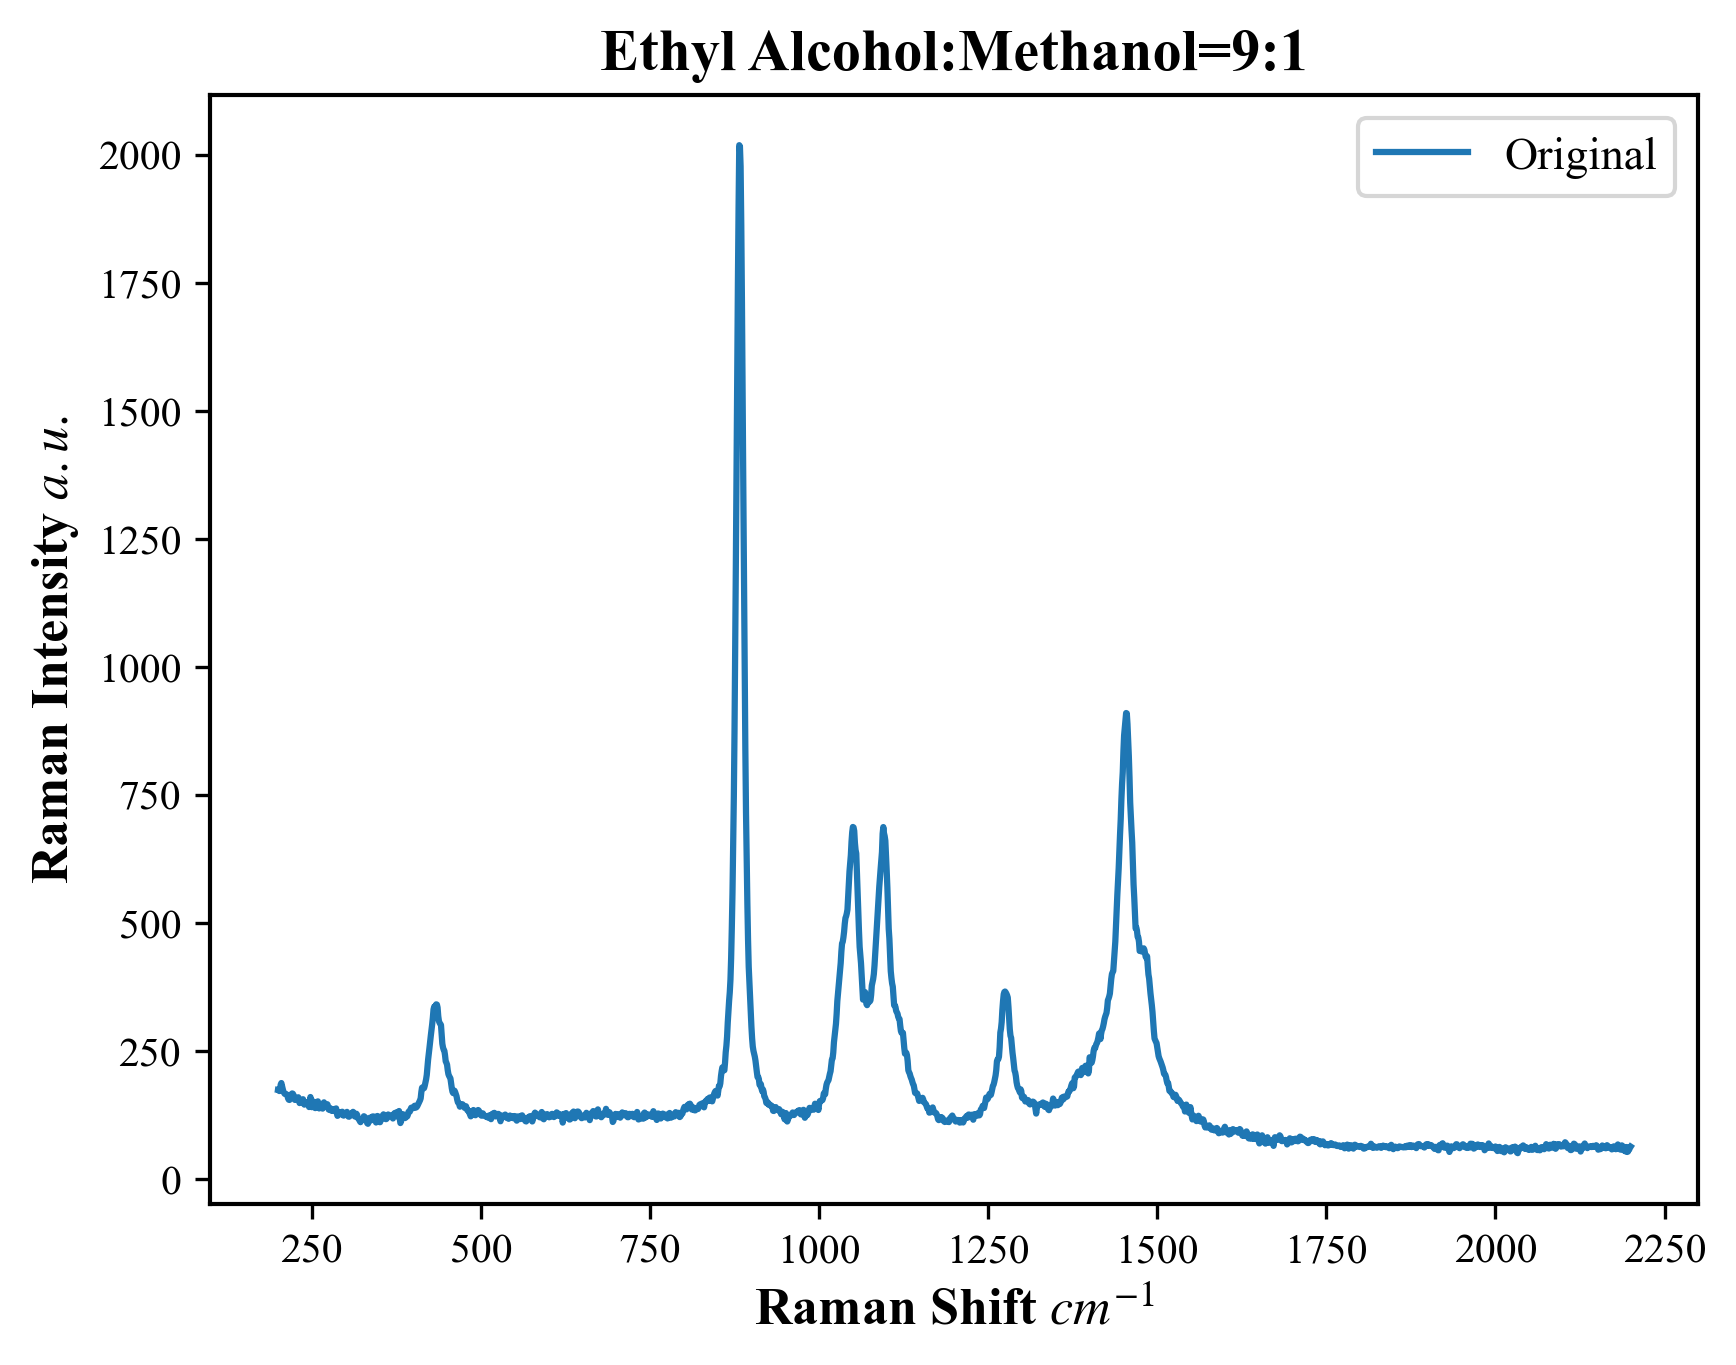

**********************************************
chemical: 乙醇-甲醇#9-1
输出标签为： [0.033 0.014 0.554 0.017 0.022 0.031 0.017 0.012 0.022 0.021 0.167 0.017
 0.025 0.048]
#######
预测的化学品为： ['乙醇', '甲醇']
参比分数为： [0.554, 0.167]
**********************************************


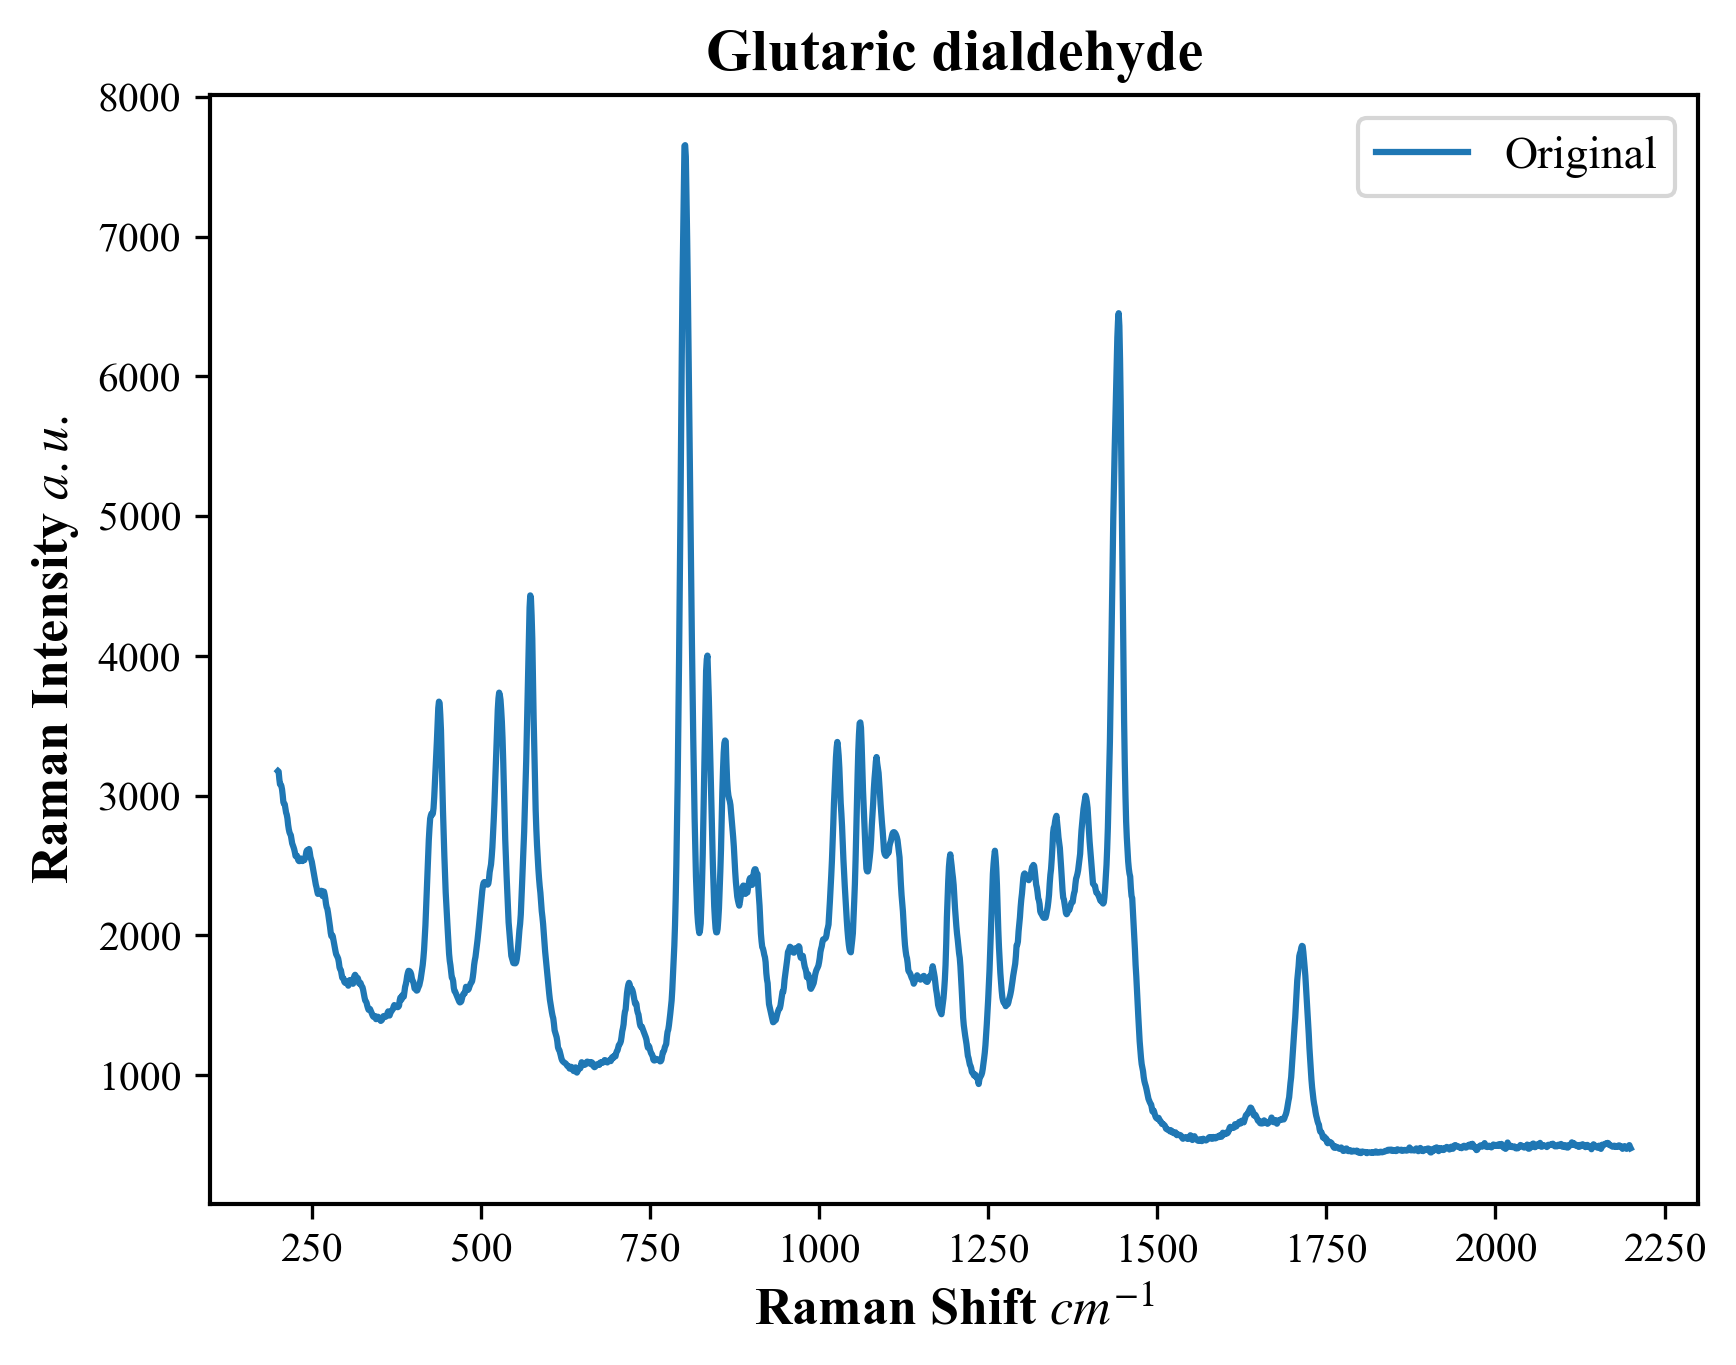

**********************************************
chemical: 戊二醛
输出标签为： [0.032 0.017 0.023 0.723 0.018 0.023 0.021 0.021 0.015 0.019 0.017 0.029
 0.022 0.019]
#######
预测的化学品为： ['戊二醛']
参比分数为： [0.723]
**********************************************


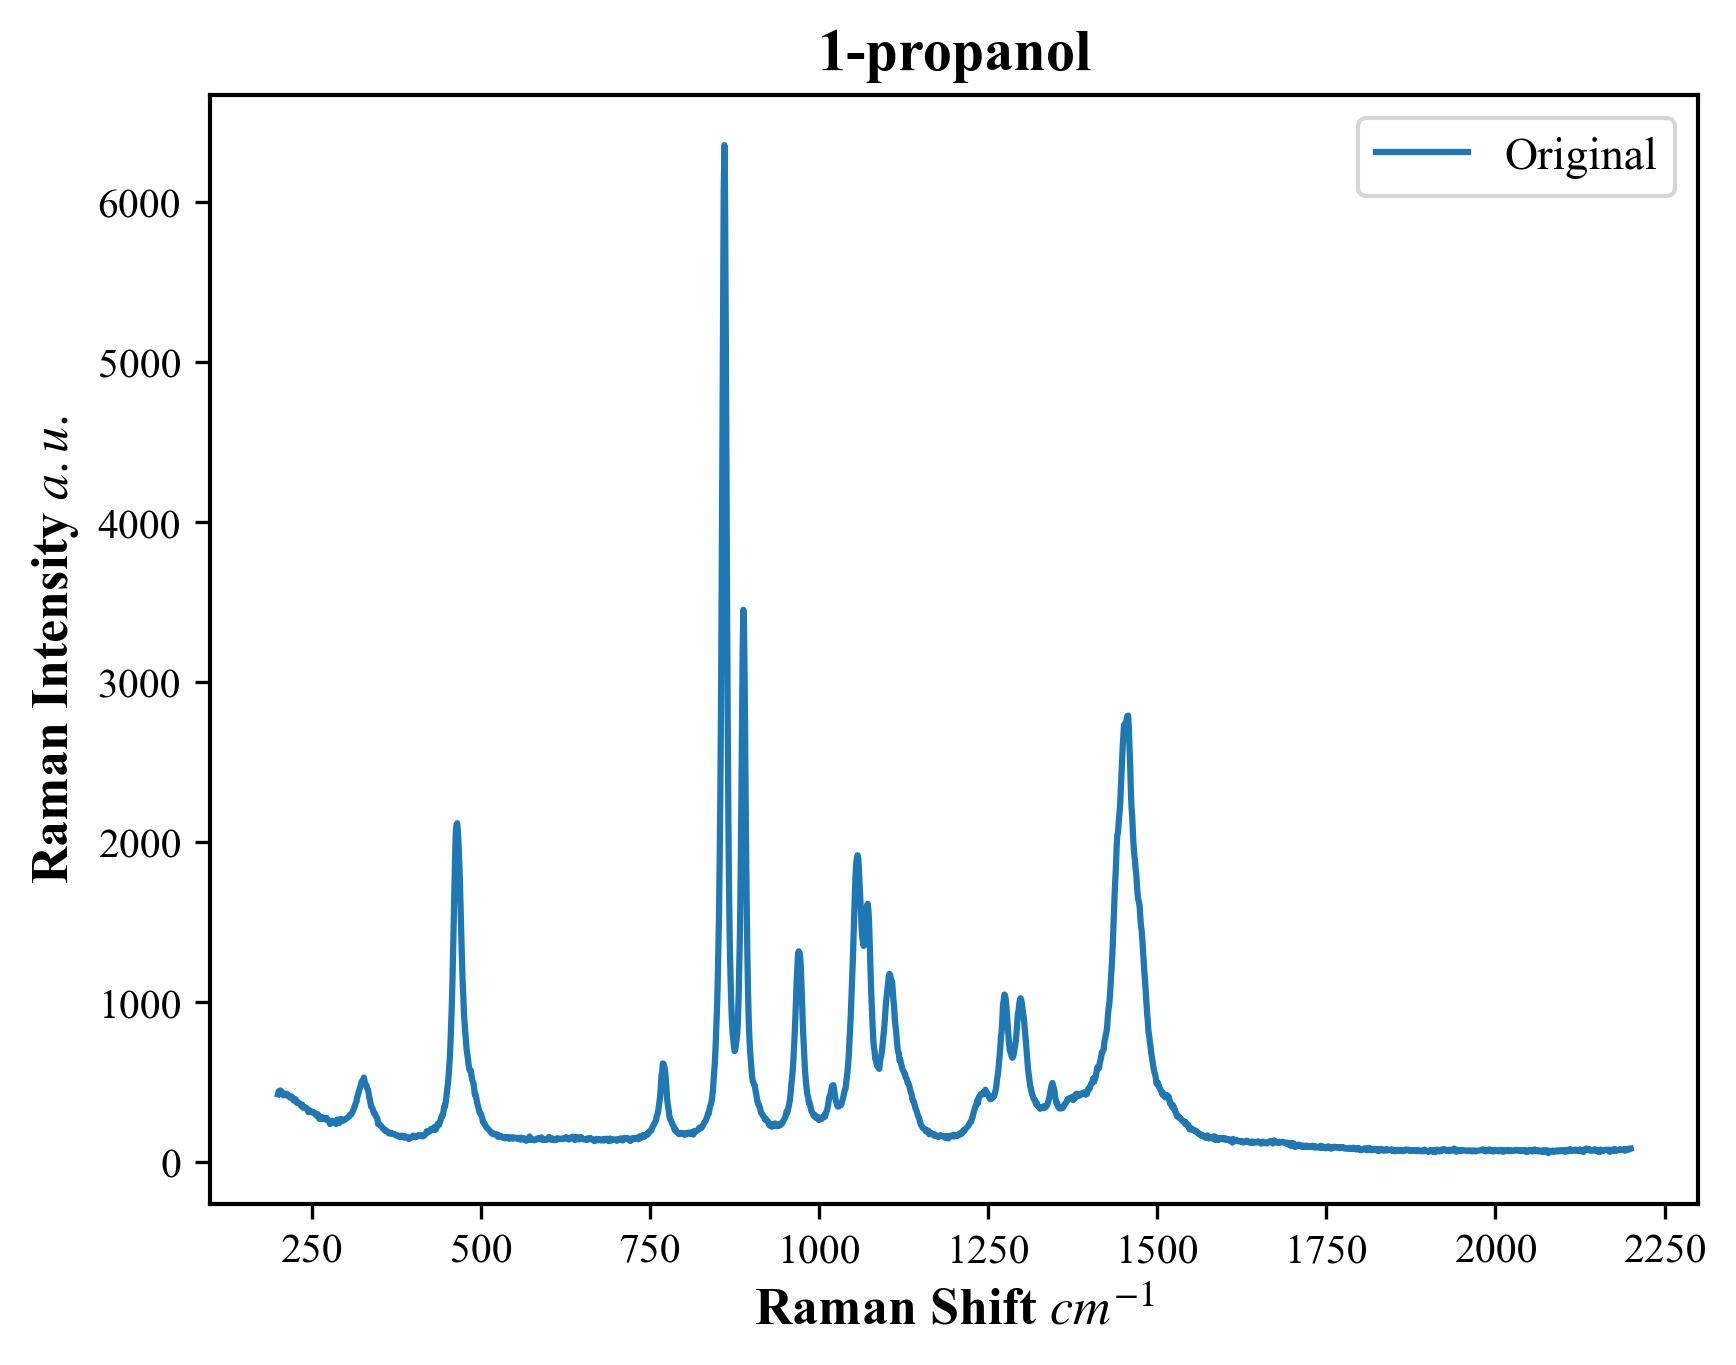

**********************************************
chemical: 正丙醇
输出标签为： [0.032 0.012 0.023 0.013 0.744 0.02  0.018 0.014 0.016 0.022 0.017 0.031
 0.017 0.022]
#######
预测的化学品为： ['正丙醇']
参比分数为： [0.744]
**********************************************


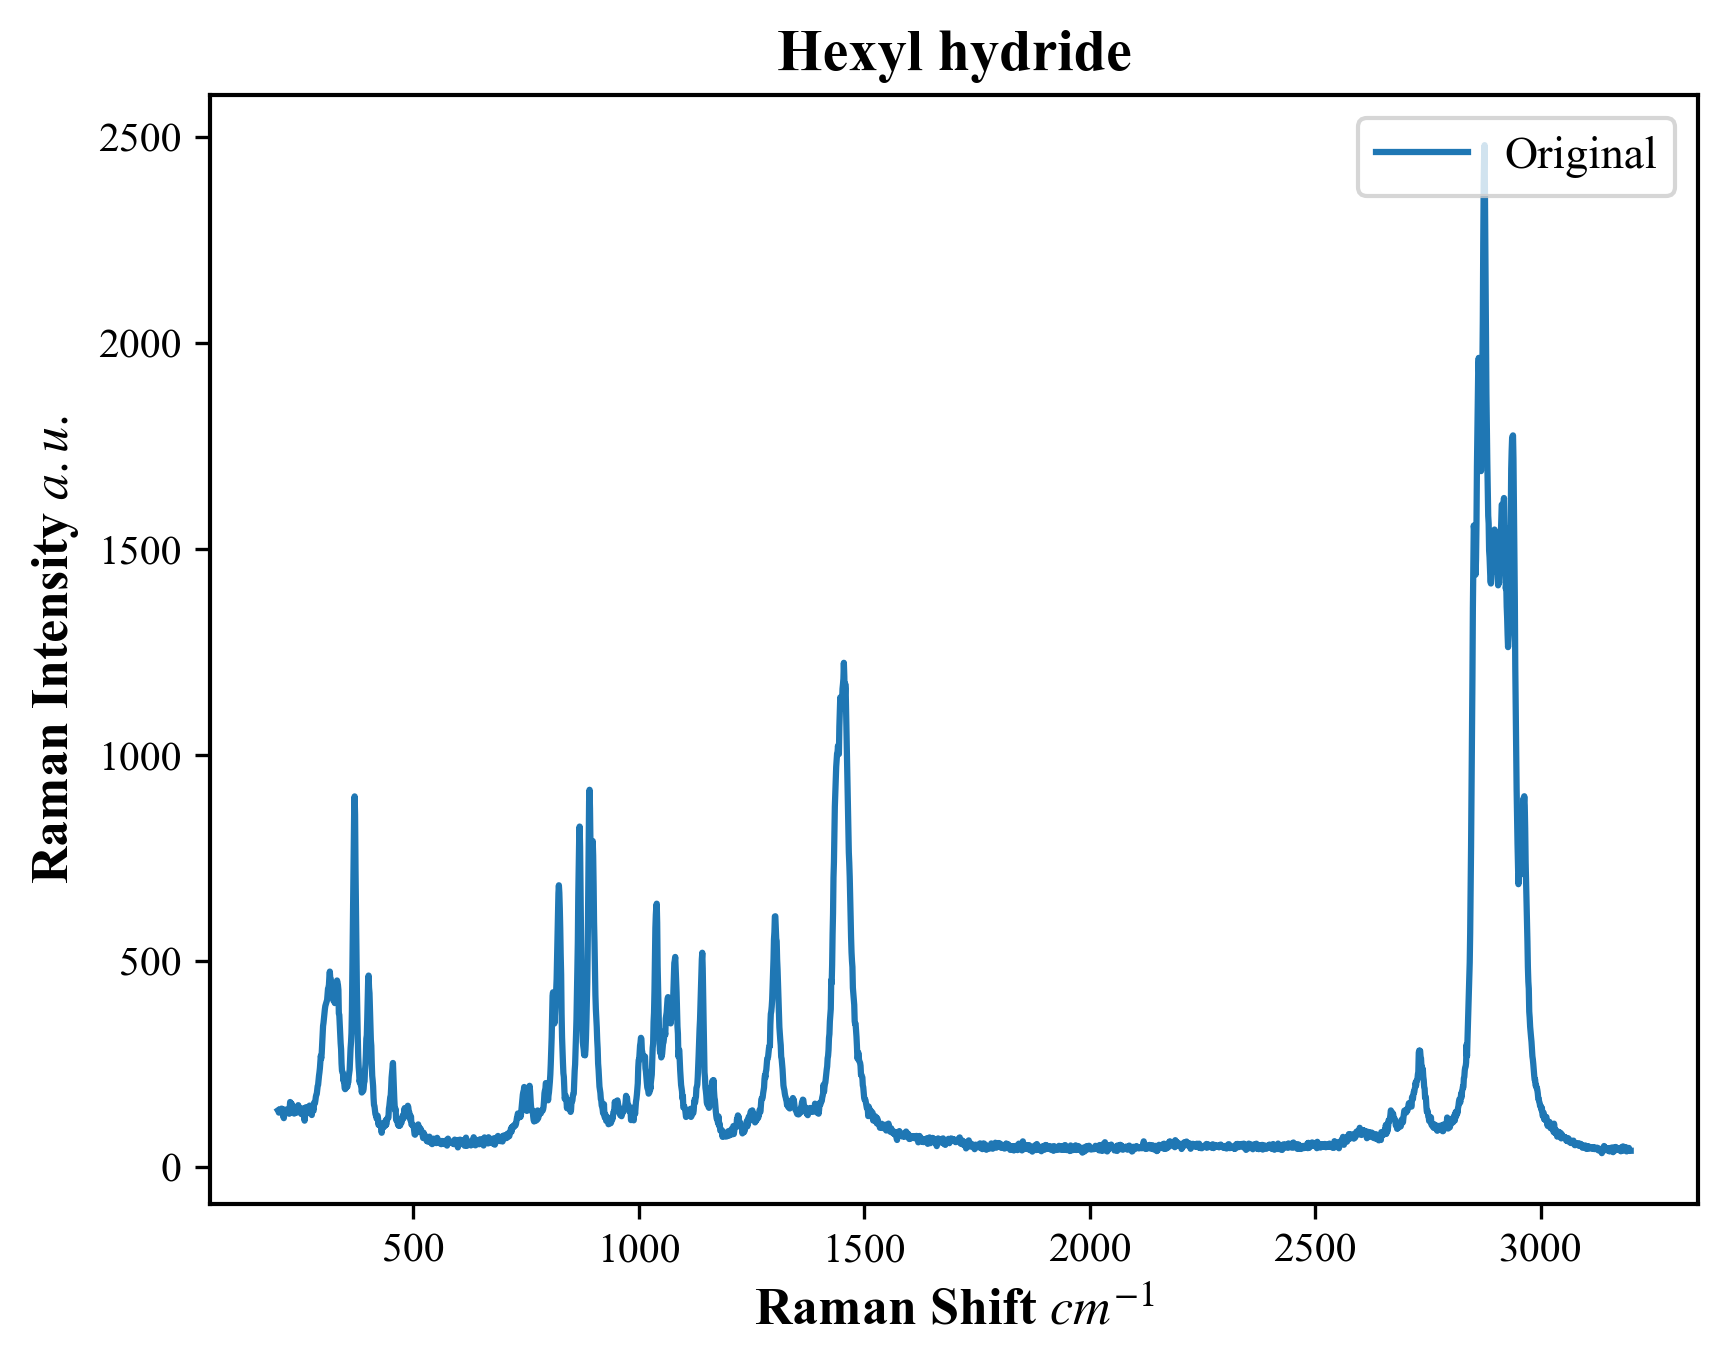

**********************************************
chemical: 正己烷
输出标签为： [0.036 0.019 0.018 0.024 0.019 0.69  0.023 0.024 0.02  0.017 0.037 0.023
 0.028 0.022]
#######
预测的化学品为： ['正己烷']
参比分数为： [0.69]
**********************************************


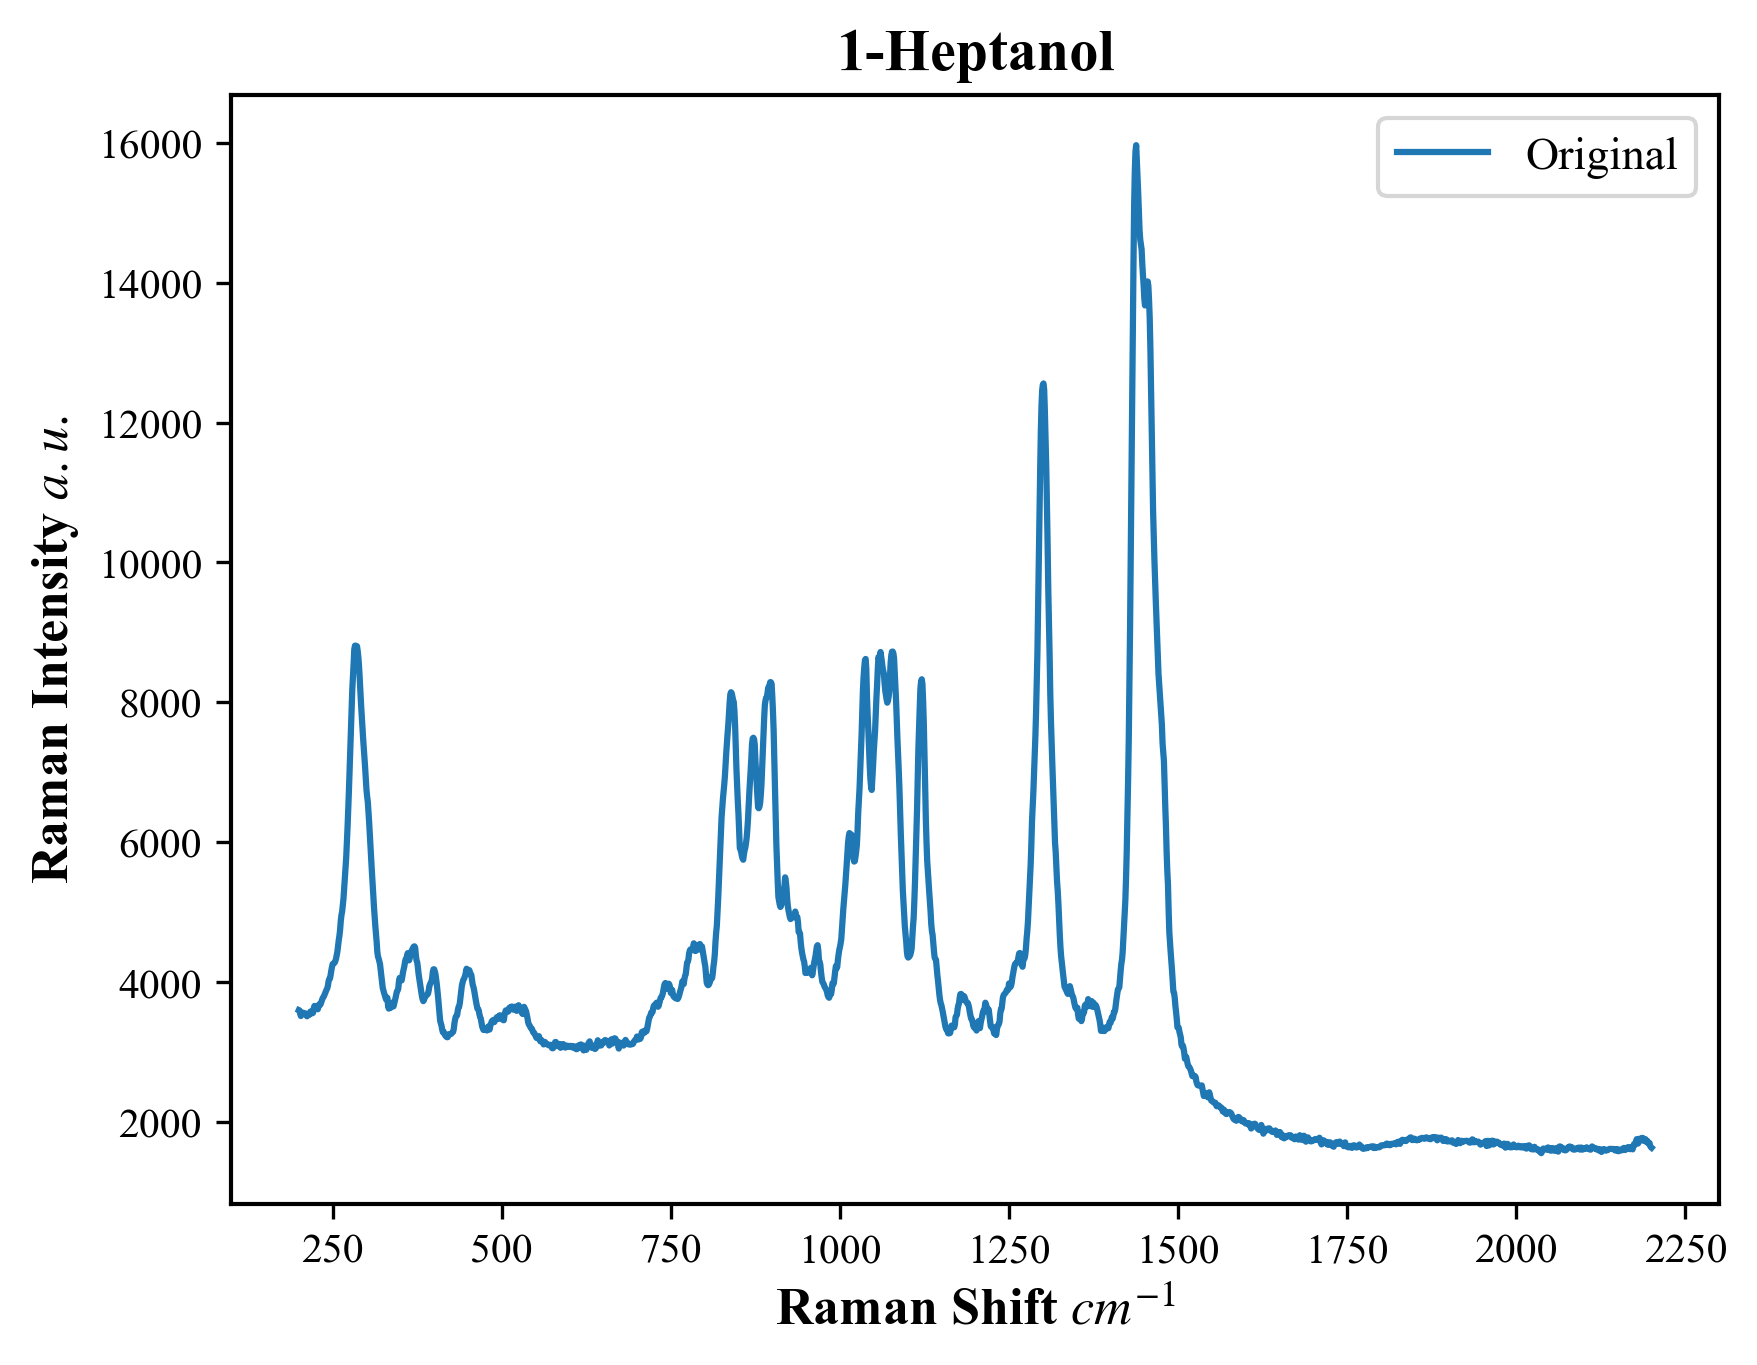

**********************************************
chemical: 正庚醇
输出标签为： [0.027 0.021 0.02  0.023 0.026 0.026 0.018 0.026 0.028 0.019 0.025 0.018
 0.017 0.706]
#######
预测的化学品为： ['正庚醇']
参比分数为： [0.706]
**********************************************


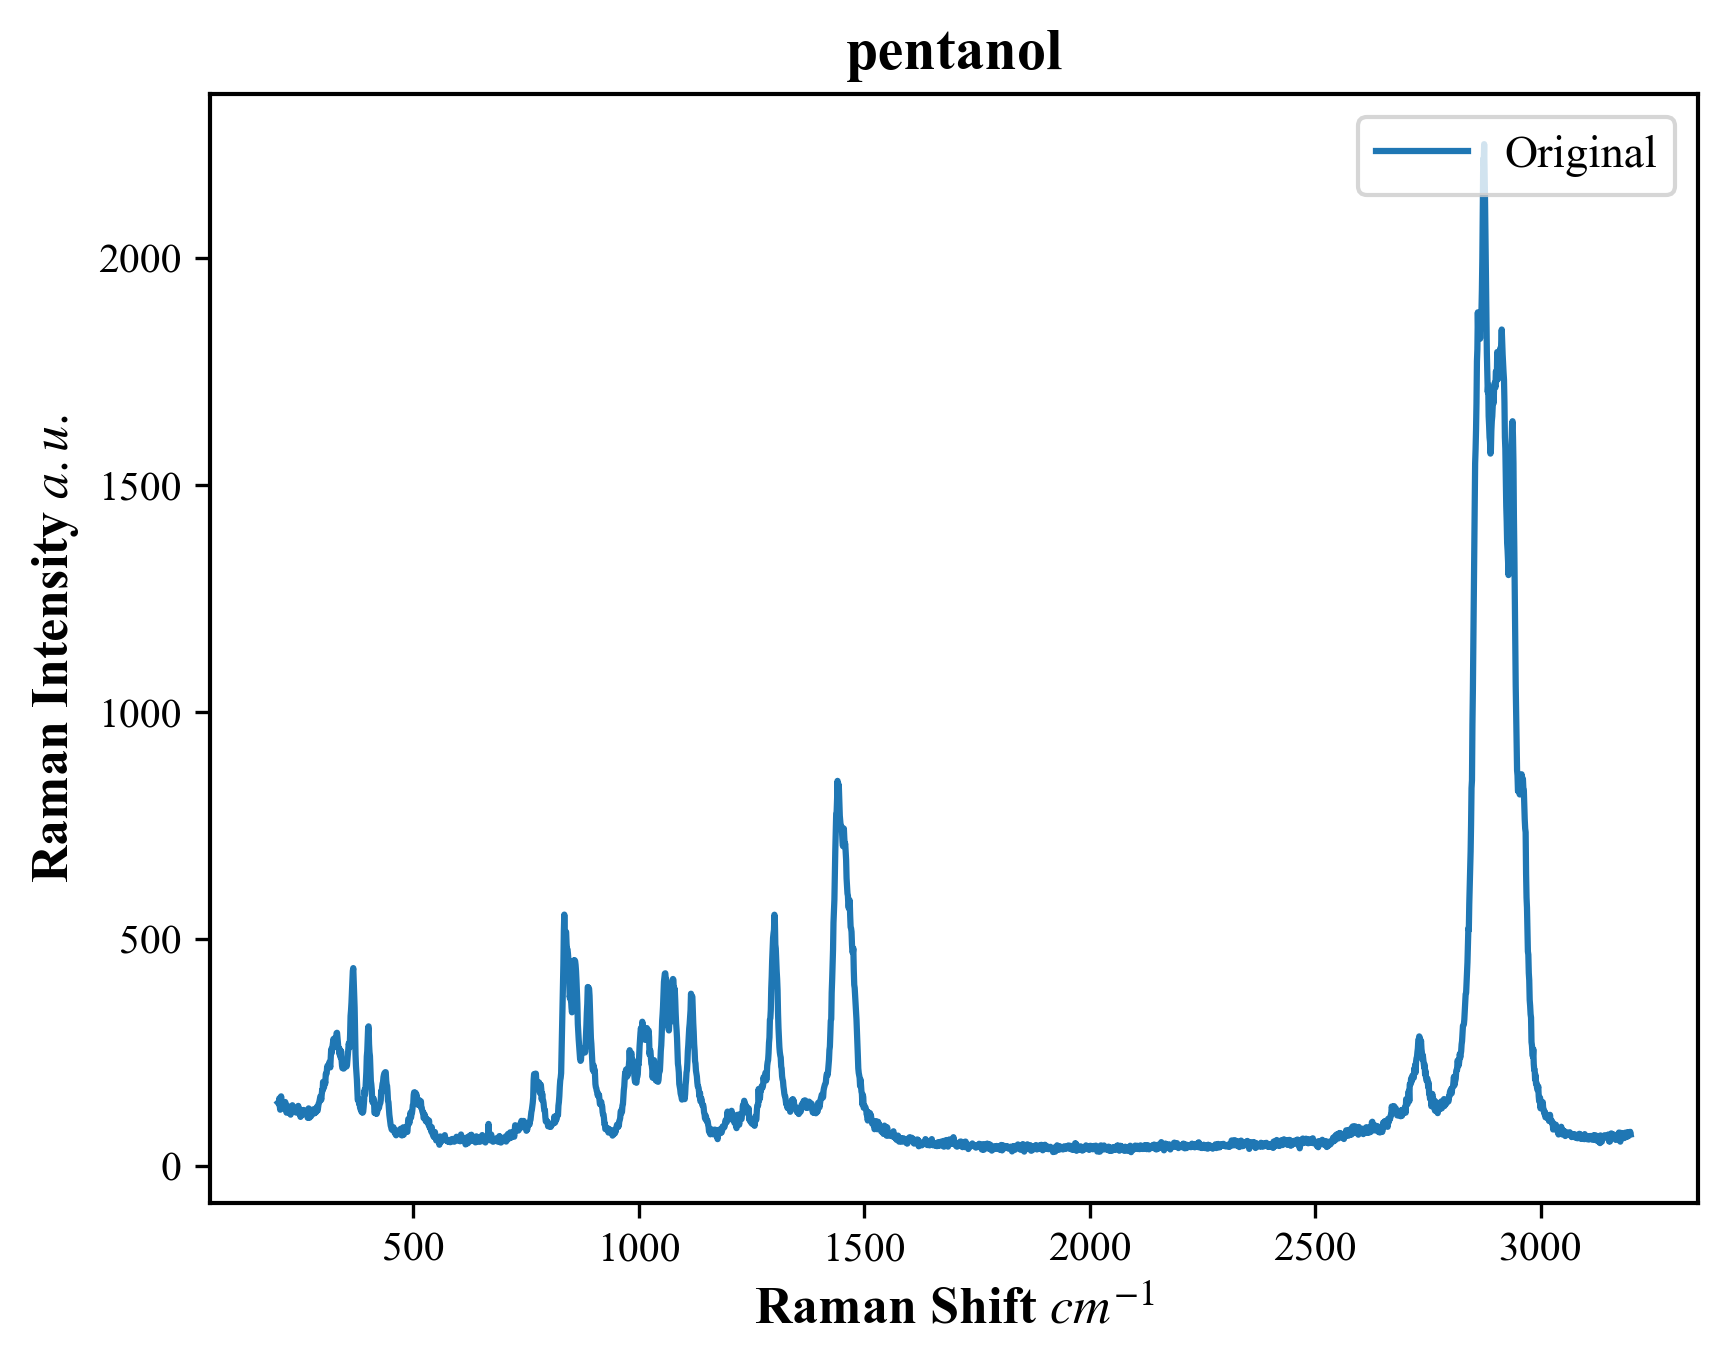

**********************************************
chemical: 正戊醇
输出标签为： [0.037 0.016 0.018 0.018 0.03  0.031 0.67  0.027 0.024 0.021 0.017 0.021
 0.039 0.031]
#######
预测的化学品为： ['正戊醇']
参比分数为： [0.67]
**********************************************


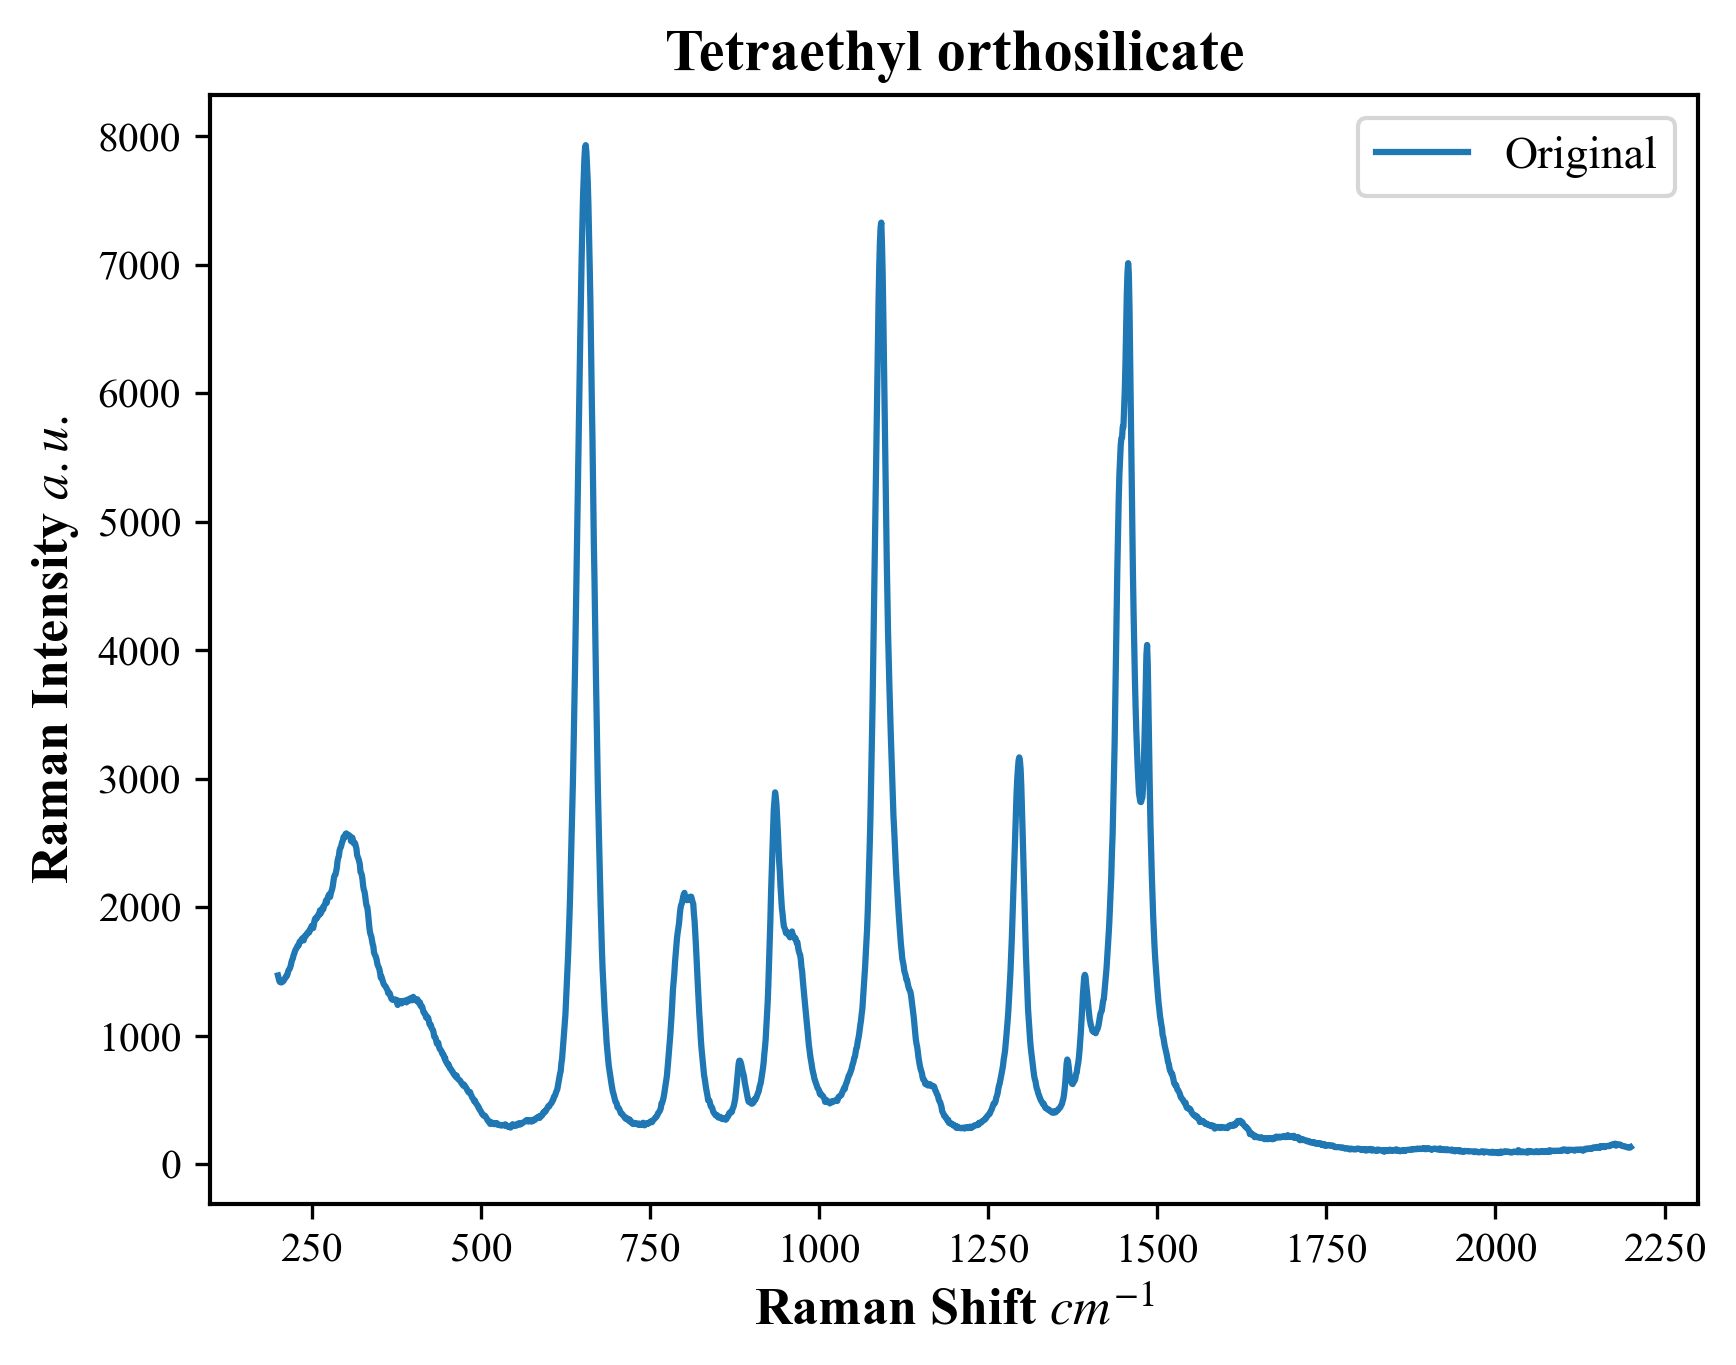

**********************************************
chemical: 正硅酸四乙酯
输出标签为： [0.029 0.014 0.028 0.016 0.018 0.029 0.02  0.722 0.018 0.016 0.023 0.028
 0.021 0.019]
#######
预测的化学品为： ['正硅酸四乙酯']
参比分数为： [0.722]
**********************************************


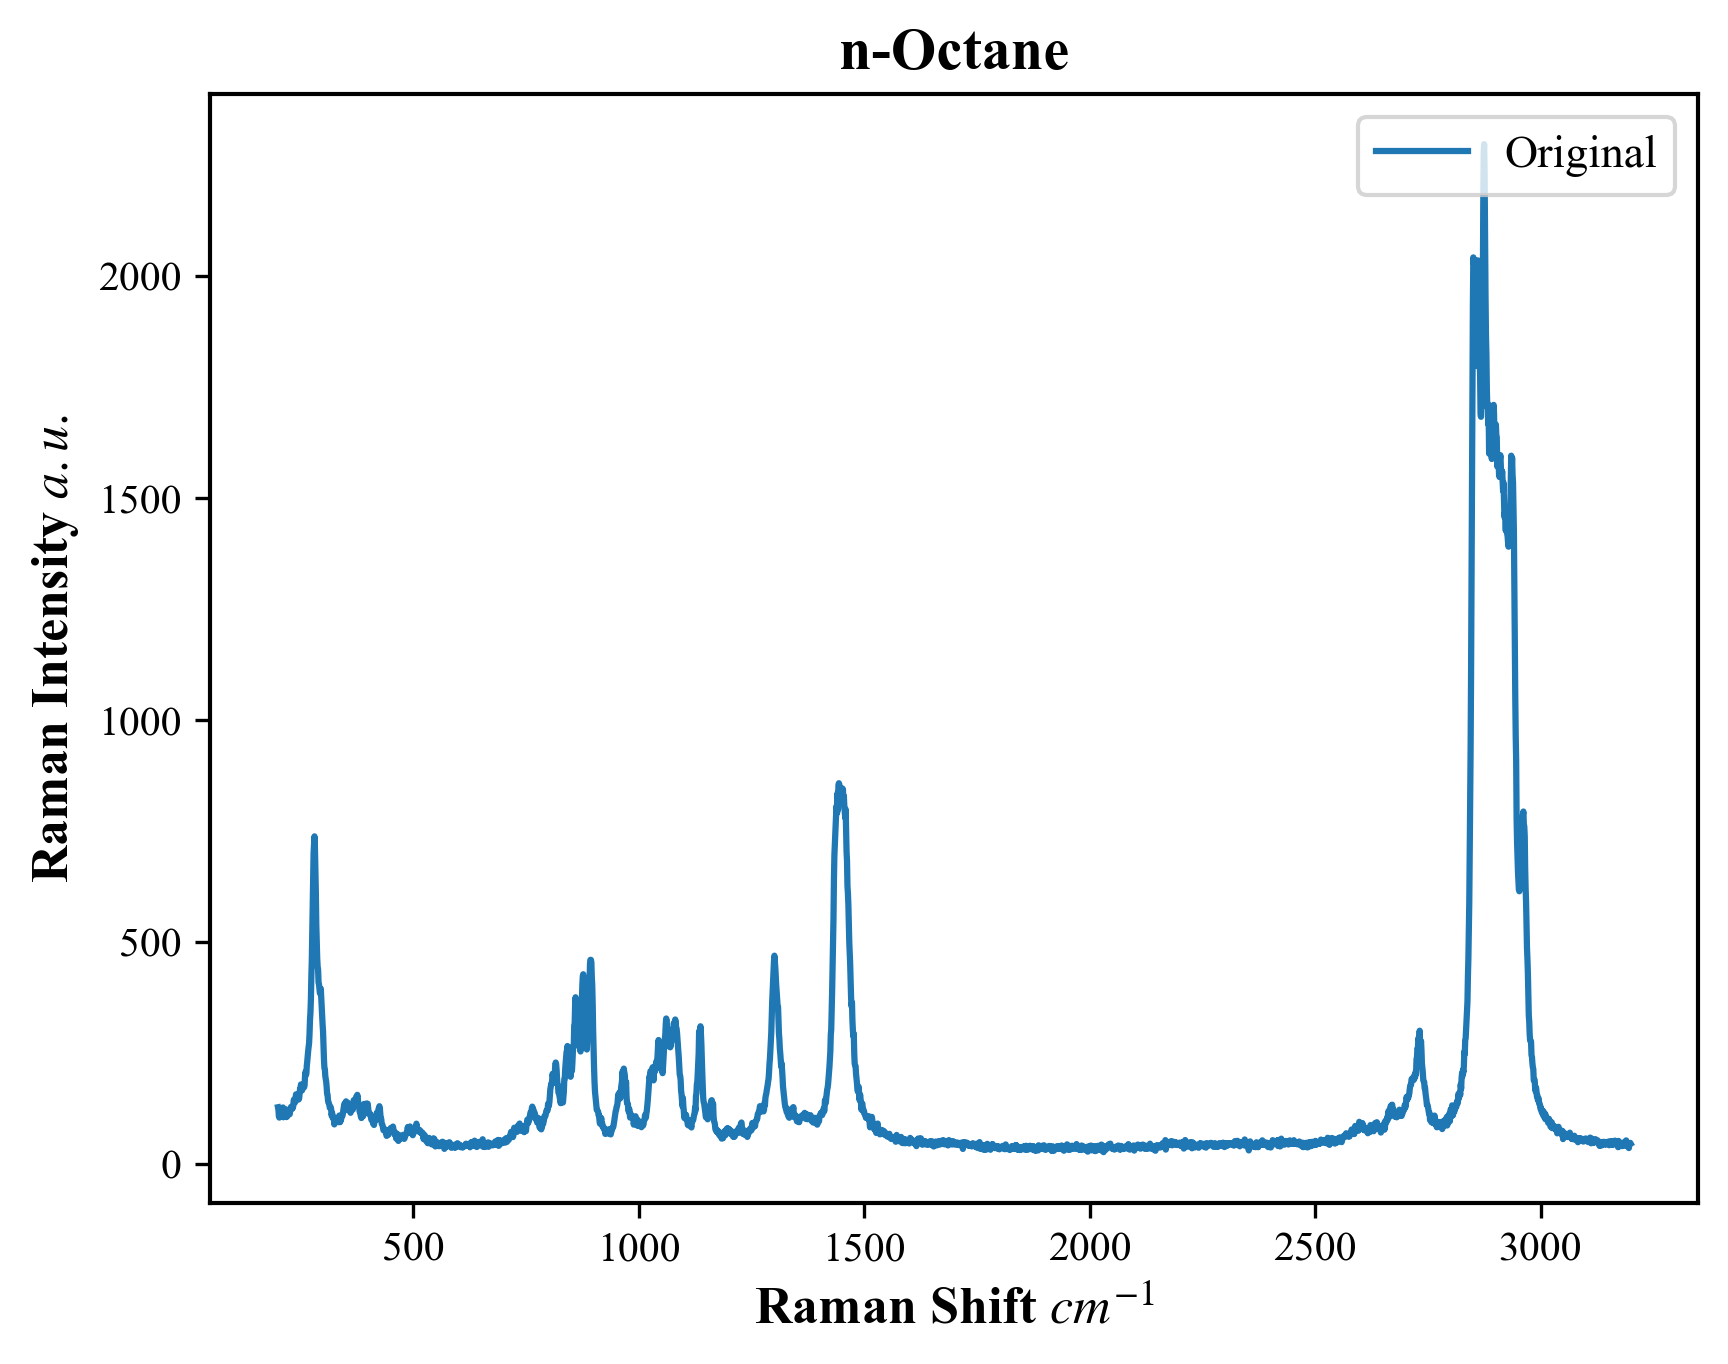

**********************************************
chemical: 正辛烷
输出标签为： [0.033 0.015 0.019 0.018 0.012 0.019 0.02  0.021 0.747 0.013 0.023 0.022
 0.018 0.02 ]
#######
预测的化学品为： ['正辛烷']
参比分数为： [0.747]
**********************************************


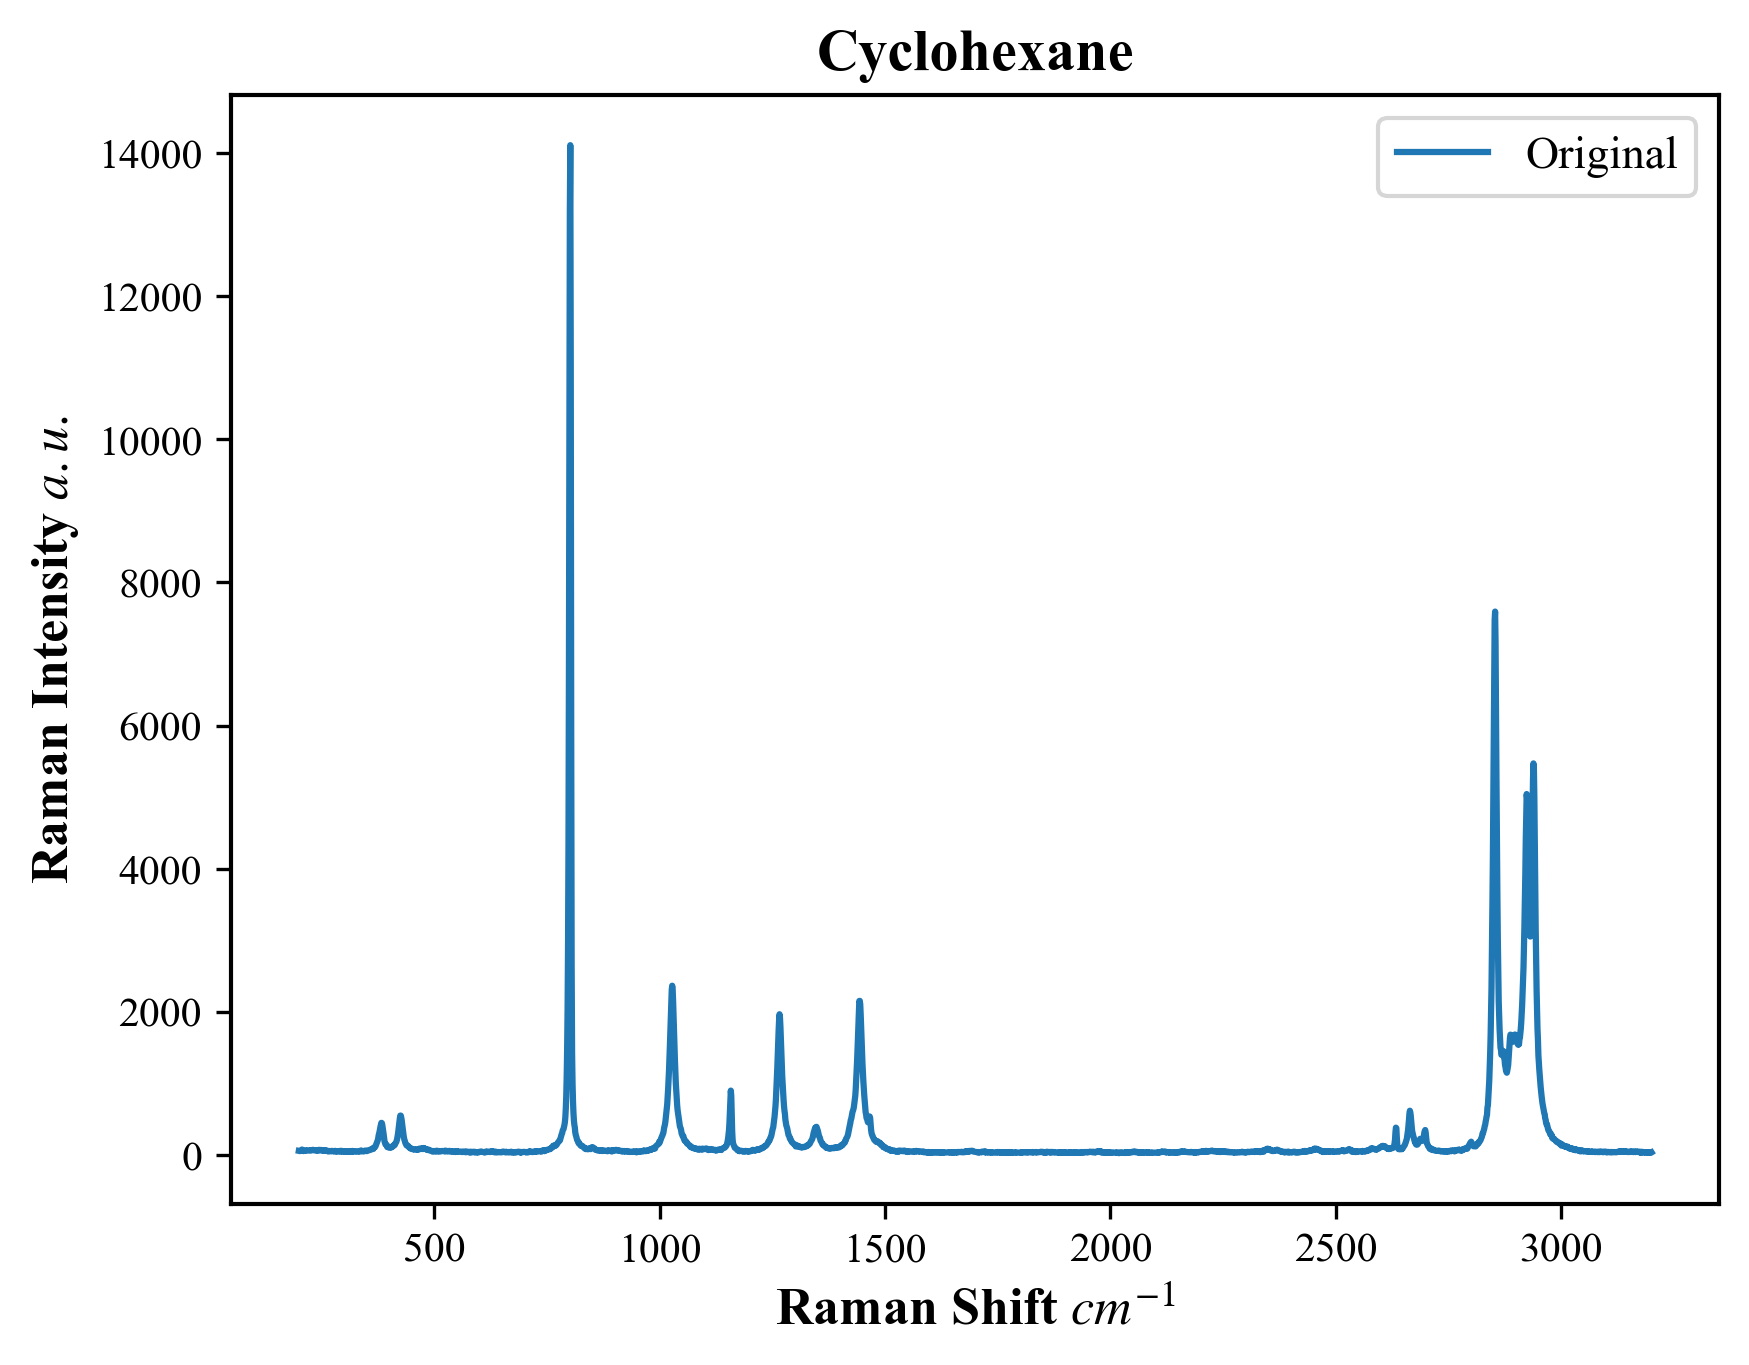

**********************************************
chemical: 环己烷
输出标签为： [0.036 0.017 0.016 0.013 0.018 0.021 0.014 0.017 0.018 0.747 0.018 0.021
 0.025 0.018]
#######
预测的化学品为： ['环己烷']
参比分数为： [0.747]
**********************************************


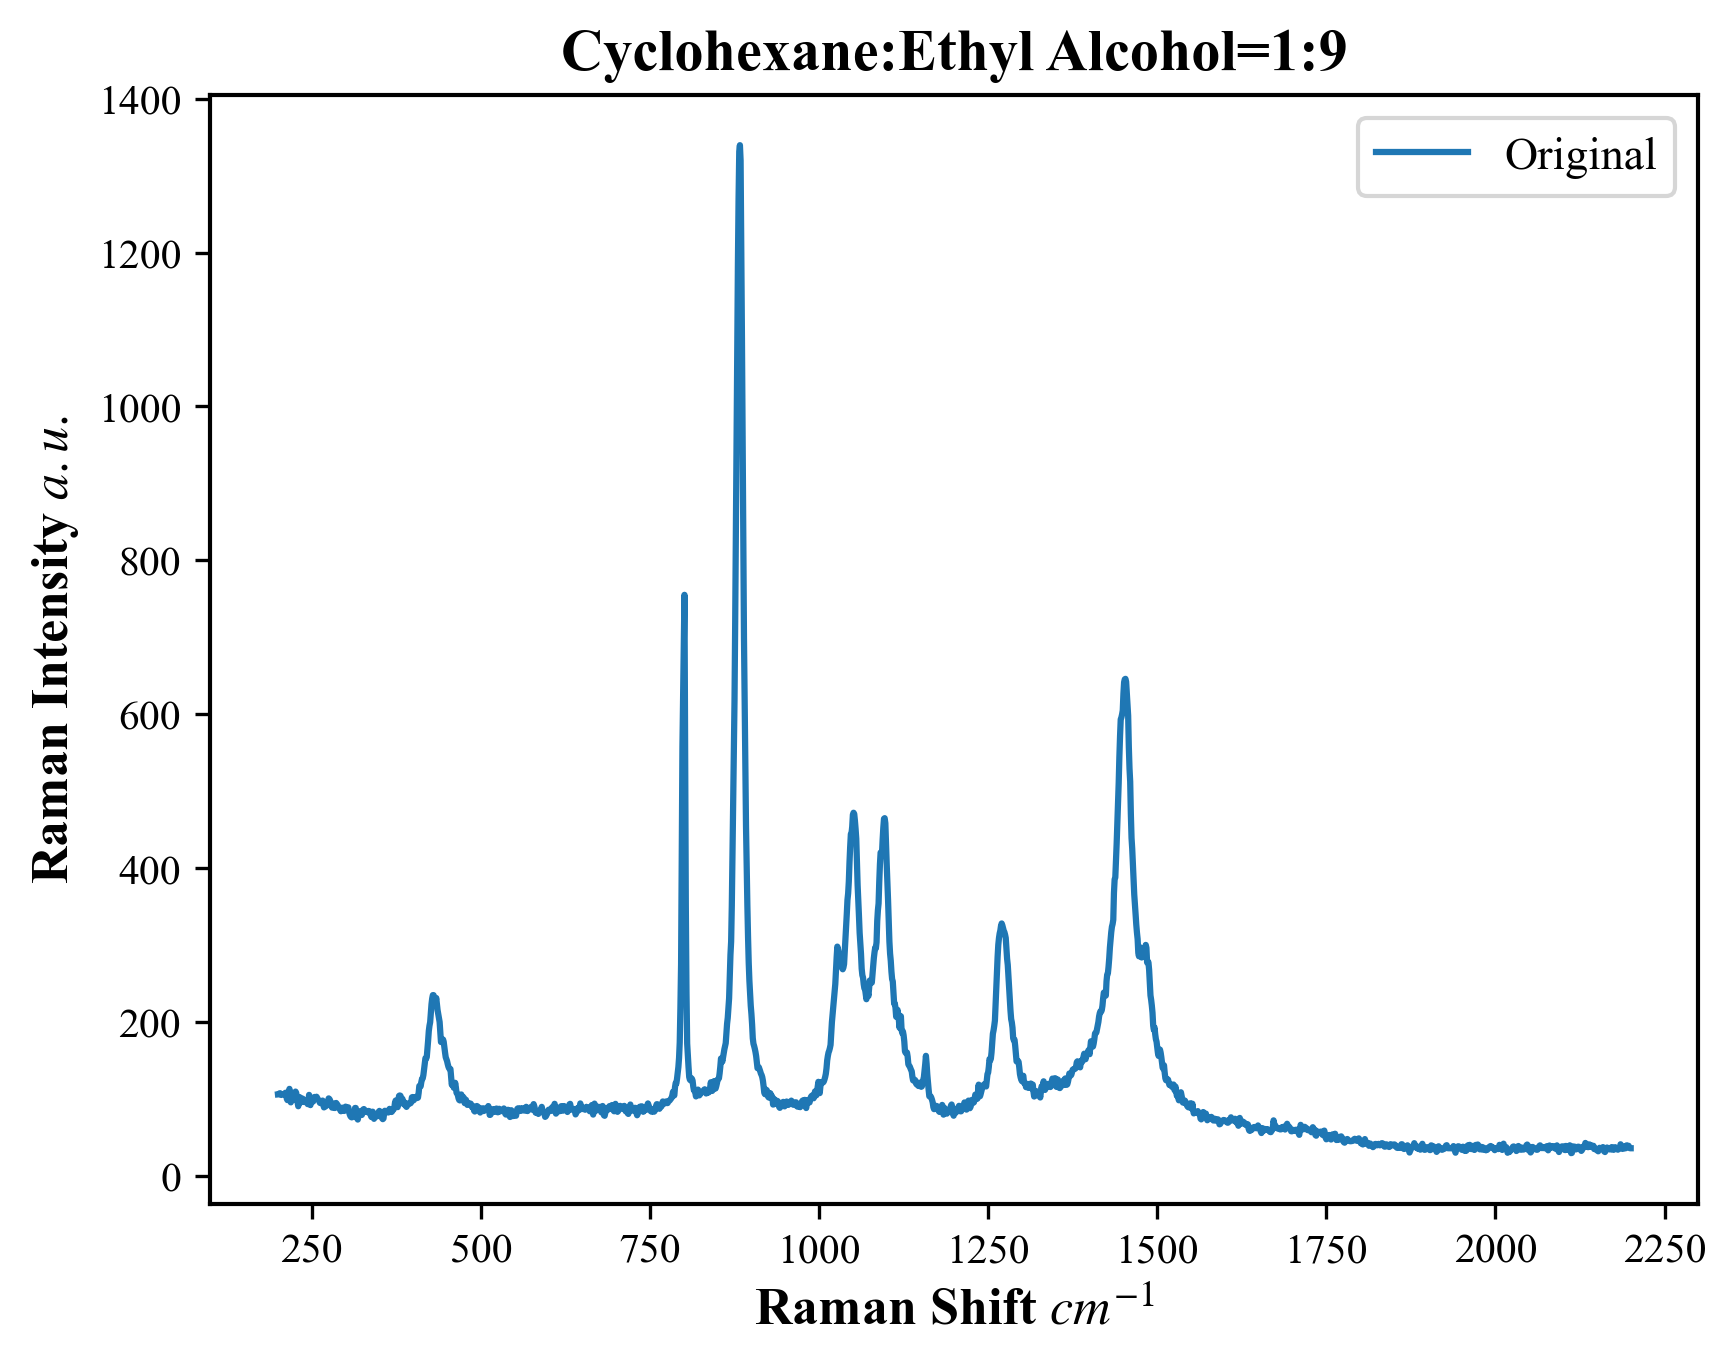

**********************************************
chemical: 环己烷-乙醇#1-9
输出标签为： [0.02  0.023 0.412 0.03  0.024 0.033 0.021 0.016 0.014 0.303 0.028 0.016
 0.017 0.045]
#######
预测的化学品为： ['乙醇', '环己烷']
参比分数为： [0.412, 0.303]
**********************************************


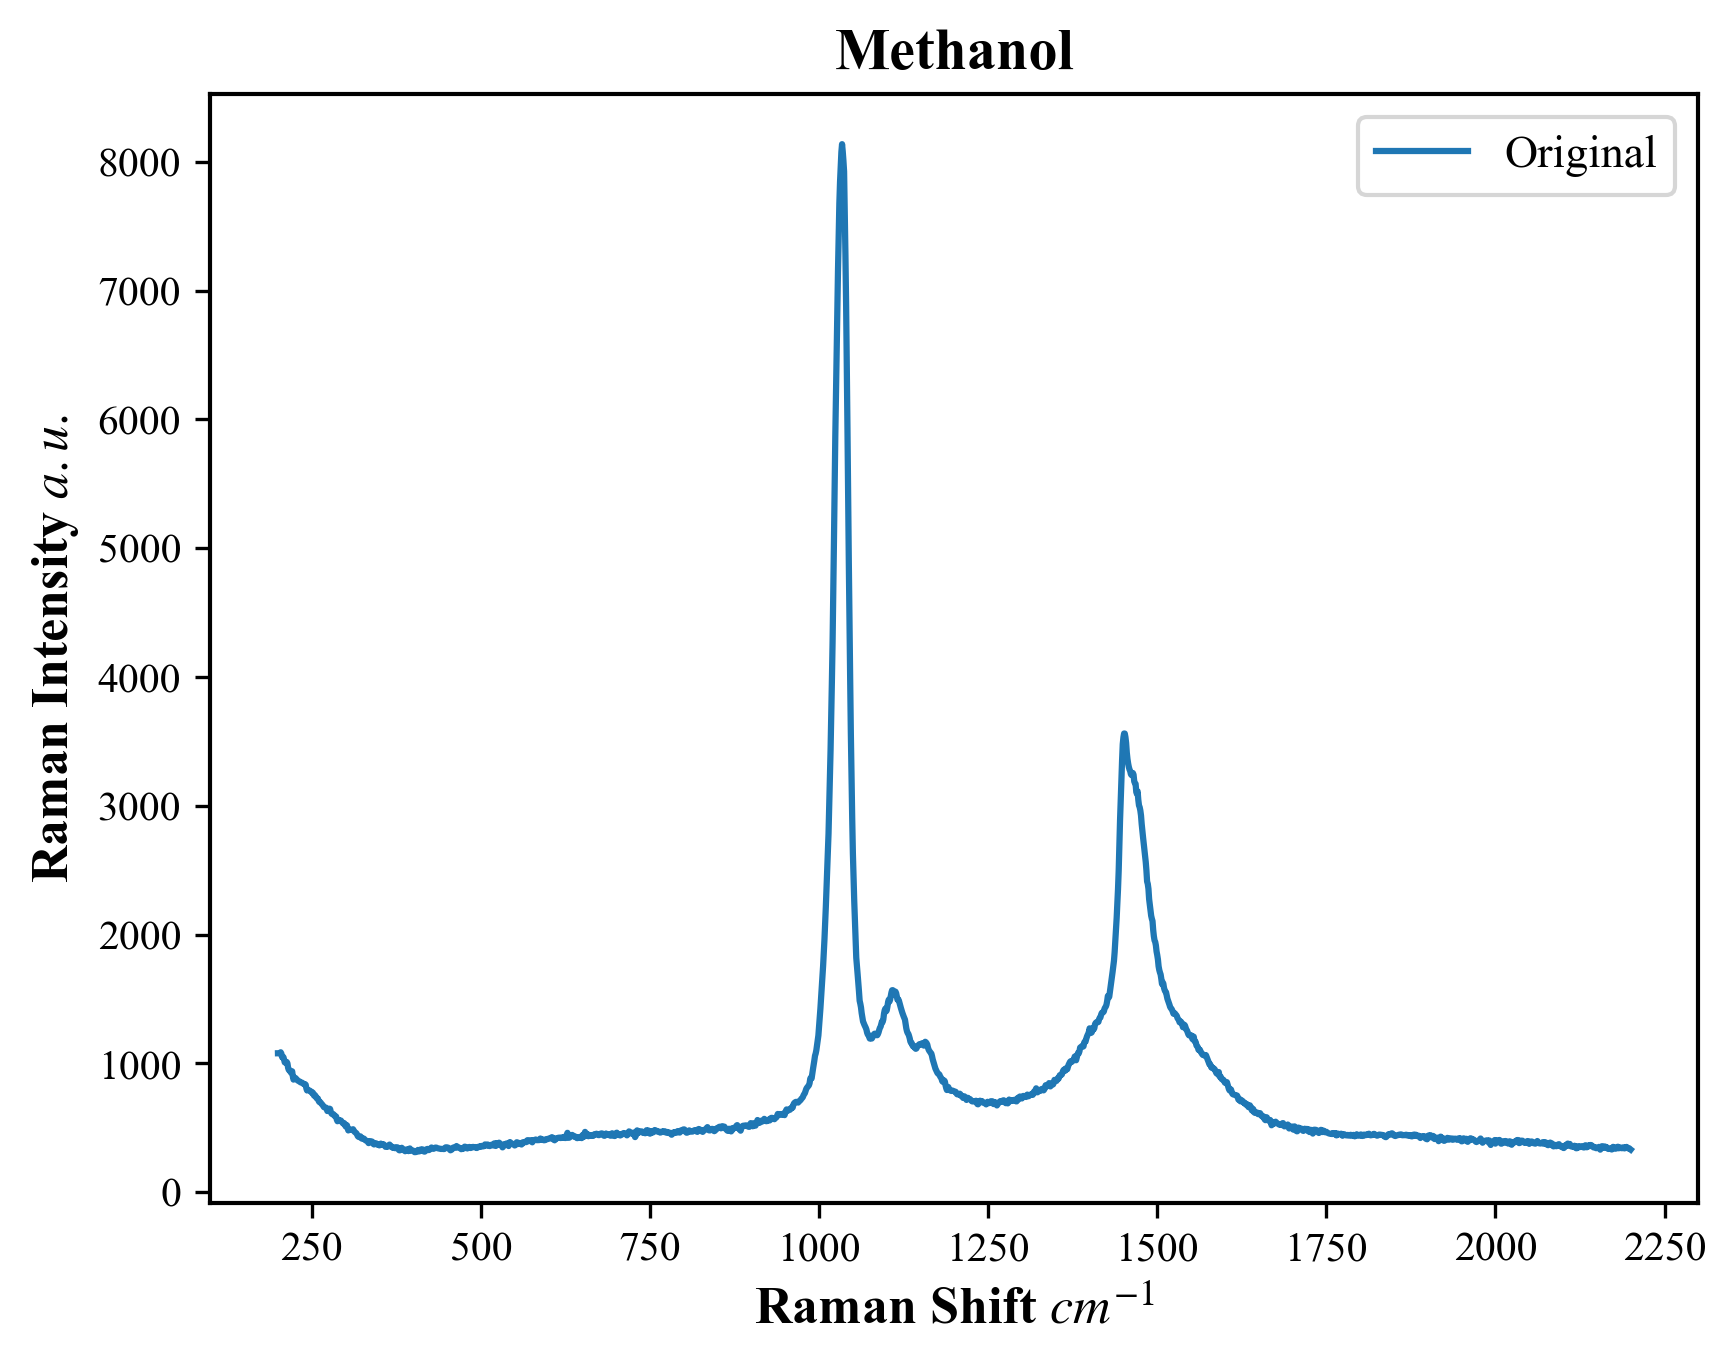

**********************************************
chemical: 甲醇
输出标签为： [0.031 0.015 0.017 0.02  0.015 0.02  0.016 0.017 0.013 0.019 0.762 0.025
 0.017 0.013]
#######
预测的化学品为： ['甲醇']
参比分数为： [0.762]
**********************************************


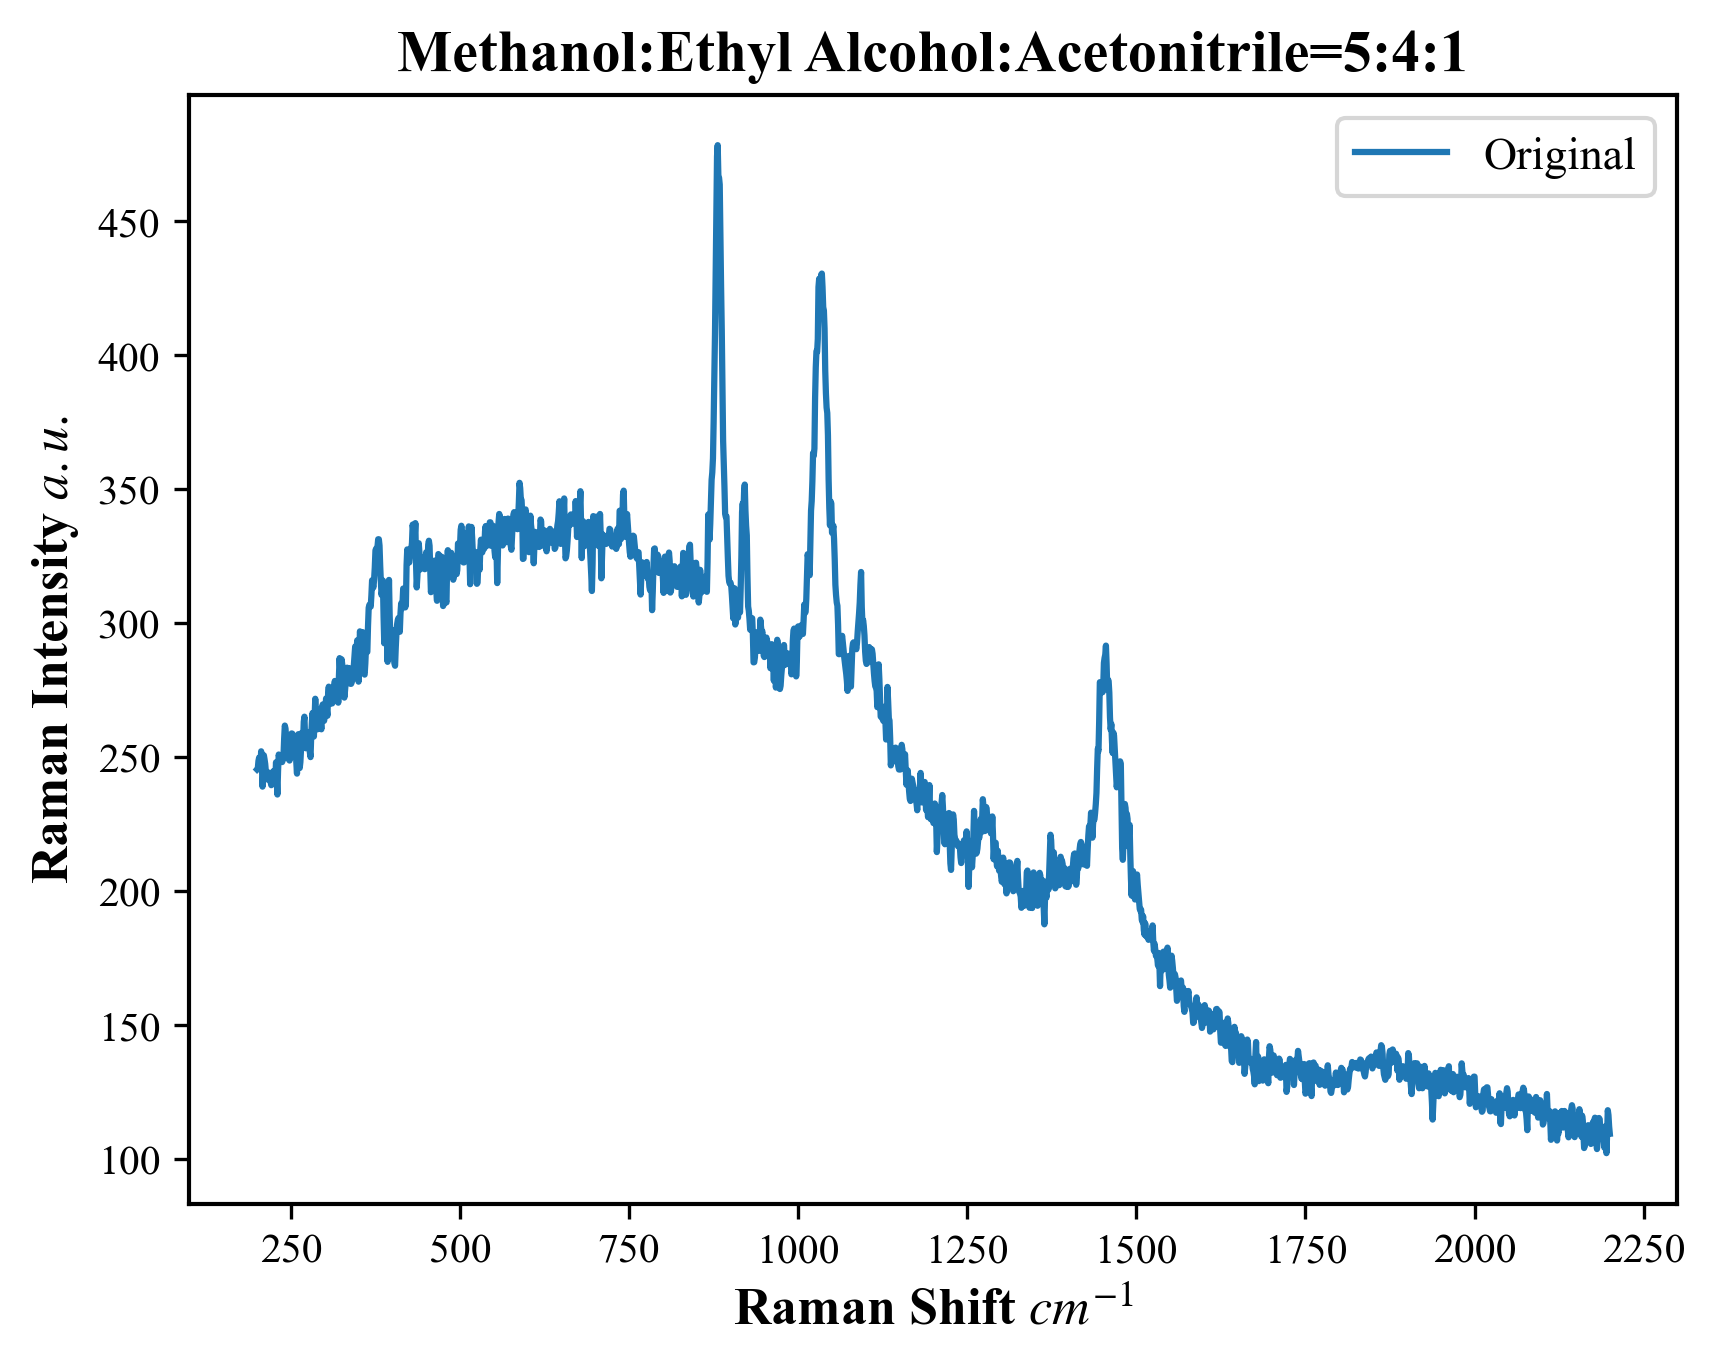

**********************************************
chemical: 甲醇-乙醇-乙腈#5-4-1
输出标签为： [0.054 0.09  0.183 0.049 0.049 0.04  0.082 0.042 0.071 0.031 0.163 0.035
 0.047 0.064]
#######
预测的化学品为： ['乙醇', '甲醇']
参比分数为： [0.183, 0.163]
**********************************************
总共预测46个数据，耗时38.44844126701355秒


In [20]:
if __name__ == '__main__':
    start_time = time.time()
    flag = 0
    
    # 遍历读取，测试模型性能
    floder_path = r'data/' # data/
    floder_set = os.listdir(floder_path) 
    for i in range(len(floder_set)):
        flag += 1
        csvset = os.listdir(floder_path + floder_set[i])
        csvpath = floder_path + floder_set[i] + os.sep + csvset[0]
        eng_name,basename = find_name(csvpath)

        data = pd.read_csv(csvpath, header=None)

        Raman_shift = data.iloc[:,0].values
        Intensity = data.iloc[:,1].values
        #Intensity = pull_baseline(Raman_shift, Intensity)# 预处理

        x, y = inter(Raman_shift, Intensity)
        outputs, name, score , weights, mul_data, final_data = testmodel(y)

        plt.plot(Raman_shift, Intensity, label='Original')
        #plt.plot(x, y_noise, label='With noise')
        #plt.plot(Raman_shift, pre_intensity, label='Preprocessed')
        plt.xlabel('Raman Shift ${cm}^{-1}$',fontsize=12.5,fontweight= 'black')
        plt.ylabel('Raman Intensity ${a.u.}$',fontsize=12.5,fontweight= 'black')
        plt.title(eng_name,fontsize=14,fontweight= 'black')
        plt.legend(prop={'size':11},loc ='upper right')
        plt.savefig('预处理1' + '.png',dpi=300,bbox_inches='tight')#,pad_inches=0.1,pad_inches=0.1
        plt.savefig('预处理1' + '.tif', format="tif",dpi=300,bbox_inches='tight')

        plt.show()
        plt.clf
        
        print('**********************************************')
        print('chemical:', floder_set[i])
        print('输出标签为：', outputs)
        print('#######')
        print('预测的化学品为：', name)
        print('参比分数为：', score)
        print('**********************************************')
    end_time = time.time()# end time
    print('总共预测{}个数据，耗时{}秒'.format(flag+1,(end_time-start_time)))

### Generate .csv weight file

In [21]:

###################################################################################
# 读取单个模型
csvpath = r'data\5_乙醇-环己烷#4-1\5_乙醇-环己烷#4-12.csv'
eng_name,basename = find_name(csvpath)
# data\乙醇-环己烷-正丙醇#5-4-1\10-26-乙醇-环己烷-正丙醇#5-4-1_2.csv
# data\甲醇-乙醇-乙腈#5-4-1\10-26-10-26-甲醇-乙醇-乙腈#5-4-1_21.csv
#csvpath = r'D:\study_data\problem\化学计量学-峰值提取\data\乙二醇\10-26-乙二醇_3.csv'
''''''
data_1 = pd.read_csv(csvpath, header=None)
Raman_shift = data_1.iloc[:,0].values
intensity = data_1.iloc[:,1].values
intensity = ( intensity - np.min(intensity) )/( np.max(intensity) - np.min(intensity) )

#pre_intensity = pull_baseline(Raman_shift, intensity)# 预处理
#pre_intensity = (pre_intensity - np.min(pre_intensity) )/( np.max(pre_intensity) - np.min(pre_intensity) )
#x, y = inter(Raman_shift, pre_intensity)
x, y = inter(Raman_shift, intensity)
outputs, name, score, _  , mul_data, final_data = testmodel(y)
mul_data  = np.squeeze( np.stack(mul_data, axis=1) ) 
csvdata_1 = pd.DataFrame(mul_data)
final_data  = np.squeeze( np.stack(final_data, axis=1) ) 
csvdata_2 = pd.DataFrame(final_data)
csvdata_1.to_csv(basename +'_data_1.csv', header=False, index=False)
csvdata_2.to_csv(basename +'_data_2.csv', header=False, index=False)
end_time = time.time()#

print('##############################')
print('输出标签为：', outputs)
print('#######')
print('预测的化学品为：', name)
print('参比分数为：', score)
print('总共预测{}个数据，耗时{}秒'.format(flag+1,(end_time-start_time)))
print('##############################')

##############################
输出标签为： [0.035 0.027 0.335 0.017 0.02  0.031 0.019 0.017 0.016 0.358 0.027 0.027
 0.027 0.043]
#######
预测的化学品为： ['环己烷', '乙醇']
参比分数为： [0.358, 0.335]
总共预测46个数据，耗时38.7969229221344秒
##############################
